In [1]:
import sys
import os

# Path to the project root (one level above the notebooks folder)
project_root = os.path.abspath("..")

# Add to Python path if not already present
if project_root not in sys.path:
    sys.path.append(project_root)

print("Project root added:", project_root)

Project root added: /home/zervaki/Thesis_New


In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from data.synthetic_data_generation.synthetic_generator import gen_data

from mvpc.mvpc_pipeline import MVPC
from mvpc.ci_tests.gauss_permc import gauss_ci_td, gauss_ci_permc
from mvpc.ci_tests.gauss_drw import gauss_ci_drw




In [4]:
# SHD helper 
def shd_skeleton(G_est, G_true):
    G_est_sym = ((G_est + G_est.T) > 0).astype(int)
    G_true_sym = ((G_true + G_true.T) > 0).astype(int)
    return np.sum(G_est_sym != G_true_sym)

In [5]:
def f1_skeleton(G_est, G_true):
    # symmetrize
    G_est_sym = ((G_est + G_est.T) > 0).astype(int)
    G_true_sym = ((G_true + G_true.T) > 0).astype(int)

    # vectorize upper triangle only (avoid double counting)
    triu_idx = np.triu_indices_from(G_true_sym, k=1)

    est = G_est_sym[triu_idx]
    true = G_true_sym[triu_idx]

    TP = np.sum((est == 1) & (true == 1))
    FP = np.sum((est == 1) & (true == 0))
    FN = np.sum((est == 0) & (true == 1))

    if TP + FP == 0:
        precision = 0.0
    else:
        precision = TP / (TP + FP)

    if TP + FN == 0:
        recall = 0.0
    else:
        recall = TP / (TP + FN)

    if precision + recall == 0:
        return 0.0

    return 2 * precision * recall / (precision + recall)


In [6]:
# Experiment configuration

# Sample sizes to mimic Figure 2 style
sample_sizes = [500, 1000, 2000, 5000, 10000, 50000]
n_reps = 15  # number of DAGs / datasets per n

num_var = 20
num_extra_e = 3
num_m = 6

p_missing_h = 0.9
p_missing_l = 0.1

modes = ["mar", "mnar"]  # missingness mechanisms
methods = ["td", "permc", "drw"]


In [7]:
def run_mvpc_all_methods(X_m, adj_true):
    results = {}

    # TD-PC
    mvpc_td = MVPC(indep_test=gauss_ci_td, corr_test=gauss_ci_td, alpha=0.05)
    res_td = mvpc_td.run(X_m)
    G_td = res_td["G_corrected"]
    results["td"] = {
        "shd": shd_skeleton(G_td, adj_true),
        "f1": f1_skeleton(G_td, adj_true),
    }

    # PermC
    mvpc_permc = MVPC(indep_test=gauss_ci_td, corr_test=gauss_ci_permc, alpha=0.05)
    res_permc = mvpc_permc.run(X_m)
    G_permc = res_permc["G_corrected"]
    results["permc"] = {
        "shd": shd_skeleton(G_permc, adj_true),
        "f1": f1_skeleton(G_permc, adj_true),
    }

    # DRW
    mvpc_drw = MVPC(indep_test=gauss_ci_td, corr_test=gauss_ci_drw, alpha=0.05)
    res_drw = mvpc_drw.run(X_m)
    G_drw = res_drw["G_corrected"]
    results["drw"] = {
        "shd": shd_skeleton(G_drw, adj_true),
        "f1": f1_skeleton(G_drw, adj_true),
    }

    return results


In [8]:
# Main simulation loop (new DAG per repetition)

results = []

for n in sample_sizes:
    for rep in range(n_reps):
        # fresh seed per (n, rep) to vary DAGs but keep reproducible
        base_seed = 1000 * n + rep

        for mode in modes:
            # Generate synthetic data (new DAG each time)
            data_dict = gen_data(
                num_samples=n,
                mode=mode,
                num_var=num_var,
                num_extra_e=num_extra_e,
                num_m=num_m,
                seed=base_seed,
                p_missing_h=p_missing_h,
                p_missing_l=p_missing_l,
            )

            X_m = data_dict["data_m"]
            adj_true = data_dict["ground_truth"]["adj"]

            shd_dict = run_mvpc_all_methods(X_m, adj_true)

            for method, metrics in shd_dict.items():
                results.append({
                    "n": n,
                    "rep": rep,
                    "mode": mode.upper(),
                    "method": method.upper(),
                    "shd": metrics["shd"],
                    "f1": metrics["f1"],
                })


df_results = pd.DataFrame(results)
df_results.head()


[Step 1] m_inds (vars with NaNs): [3, 4, 9, 10, 11, 15]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(7)]


[Step 1] R_ind=4, parents=[np.int64(14)]


[Step 1] R_ind=9, parents=[np.int64(16)]


[Step 1] R_ind=10, parents=[np.int64(13)]


[Step 1] R_ind=11, parents=[np.int64(7)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 320.85it/s]


[Step 1] R_ind=15, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 4, 9, 10, 11, 15]
[Step 1] prt dict: {3: [np.int64(7)], 4: [np.int64(14)], 9: [np.int64(16)], 10: [np.int64(13)], 11: [np.int64(7)], 15: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [3, 4, 9, 10, 11, 15]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(7)]


[Step 1] R_ind=4, parents=[np.int64(14)]


[Step 1] R_ind=9, parents=[np.int64(16)]


[Step 1] R_ind=10, parents=[np.int64(13)]


[Step 1] R_ind=11, parents=[np.int64(7)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 333.71it/s]


[Step 1] R_ind=15, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 4, 9, 10, 11, 15]
[Step 1] prt dict: {3: [np.int64(7)], 4: [np.int64(14)], 9: [np.int64(16)], 10: [np.int64(13)], 11: [np.int64(7)], 15: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [3, 4, 9, 10, 11, 15]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(7)]


[Step 1] R_ind=4, parents=[np.int64(14)]


[Step 1] R_ind=9, parents=[np.int64(16)]


[Step 1] R_ind=10, parents=[np.int64(13)]


[Step 1] R_ind=11, parents=[np.int64(7)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 334.28it/s]


[Step 1] R_ind=15, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 4, 9, 10, 11, 15]
[Step 1] prt dict: {3: [np.int64(7)], 4: [np.int64(14)], 9: [np.int64(16)], 10: [np.int64(13)], 11: [np.int64(7)], 15: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [2, 3, 7, 11, 15]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(19)]


[Step 1] R_ind=3, parents=[np.int64(7)]


[Step 1] R_ind=7, parents=[np.int64(12)]


[Step 1] R_ind=11, parents=[np.int64(7)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 324.22it/s]


[Step 1] R_ind=15, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 3, 7, 11, 15]
[Step 1] prt dict: {2: [np.int64(19)], 3: [np.int64(7)], 7: [np.int64(12)], 11: [np.int64(7)], 15: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [2, 3, 7, 11, 15]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(19)]


[Step 1] R_ind=3, parents=[np.int64(7)]


[Step 1] R_ind=7, parents=[np.int64(12)]


[Step 1] R_ind=11, parents=[np.int64(7)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 325.85it/s]


[Step 1] R_ind=15, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 3, 7, 11, 15]
[Step 1] prt dict: {2: [np.int64(19)], 3: [np.int64(7)], 7: [np.int64(12)], 11: [np.int64(7)], 15: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [2, 3, 7, 11, 15]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(19)]


[Step 1] R_ind=3, parents=[np.int64(7)]


[Step 1] R_ind=7, parents=[np.int64(12)]


[Step 1] R_ind=11, parents=[np.int64(7)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 326.72it/s]


[Step 1] R_ind=15, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 3, 7, 11, 15]
[Step 1] prt dict: {2: [np.int64(19)], 3: [np.int64(7)], 7: [np.int64(12)], 11: [np.int64(7)], 15: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [8, 9, 10, 11, 13, 15]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=8, parents=[np.int64(4)]


[Step 1] R_ind=9, parents=[np.int64(19)]


[Step 1] R_ind=10, parents=[np.int64(5), np.int64(14)]


[Step 1] R_ind=11, parents=[np.int64(6)]


[Step 1] R_ind=13, parents=[np.int64(2)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 279.29it/s]


[Step 1] R_ind=15, parents=[np.int64(11), np.int64(12)]
[Step 1] m_inds_filtered (with ≥1 parent): [8, 9, 10, 11, 13, 15]
[Step 1] prt dict: {8: [np.int64(4)], 9: [np.int64(19)], 10: [np.int64(5), np.int64(14)], 11: [np.int64(6)], 13: [np.int64(2)], 15: [np.int64(11), np.int64(12)]}


[Step 1] m_inds (vars with NaNs): [8, 9, 10, 11, 13, 15]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=8, parents=[np.int64(4)]


[Step 1] R_ind=9, parents=[np.int64(19)]


[Step 1] R_ind=10, parents=[np.int64(5), np.int64(14)]


[Step 1] R_ind=11, parents=[np.int64(6)]


[Step 1] R_ind=13, parents=[np.int64(2)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 278.84it/s]


[Step 1] R_ind=15, parents=[np.int64(11), np.int64(12)]
[Step 1] m_inds_filtered (with ≥1 parent): [8, 9, 10, 11, 13, 15]
[Step 1] prt dict: {8: [np.int64(4)], 9: [np.int64(19)], 10: [np.int64(5), np.int64(14)], 11: [np.int64(6)], 13: [np.int64(2)], 15: [np.int64(11), np.int64(12)]}


[Step 1] m_inds (vars with NaNs): [8, 9, 10, 11, 13, 15]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=8, parents=[np.int64(4)]


[Step 1] R_ind=9, parents=[np.int64(19)]


[Step 1] R_ind=10, parents=[np.int64(5), np.int64(14)]


[Step 1] R_ind=11, parents=[np.int64(6)]


[Step 1] R_ind=13, parents=[np.int64(2)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 278.31it/s]


[Step 1] R_ind=15, parents=[np.int64(11), np.int64(12)]
[Step 1] m_inds_filtered (with ≥1 parent): [8, 9, 10, 11, 13, 15]
[Step 1] prt dict: {8: [np.int64(4)], 9: [np.int64(19)], 10: [np.int64(5), np.int64(14)], 11: [np.int64(6)], 13: [np.int64(2)], 15: [np.int64(11), np.int64(12)]}


[Step 1] m_inds (vars with NaNs): [2, 5, 9, 10, 13, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(5), np.int64(17)]


[Step 1] R_ind=5, parents=[np.int64(16)]


[Step 1] R_ind=9, parents=[np.int64(19)]


[Step 1] R_ind=10, parents=[np.int64(5)]


[Step 1] R_ind=13, parents=[np.int64(2)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 277.85it/s]


[Step 1] R_ind=19, parents=[np.int64(12)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 5, 9, 10, 13, 19]
[Step 1] prt dict: {2: [np.int64(5), np.int64(17)], 5: [np.int64(16)], 9: [np.int64(19)], 10: [np.int64(5)], 13: [np.int64(2)], 19: [np.int64(12)]}


[Step 1] m_inds (vars with NaNs): [2, 5, 9, 10, 13, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(5), np.int64(17)]


[Step 1] R_ind=5, parents=[np.int64(16)]


[Step 1] R_ind=9, parents=[np.int64(19)]


[Step 1] R_ind=10, parents=[np.int64(5)]


[Step 1] R_ind=13, parents=[np.int64(2)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 276.76it/s]


[Step 1] R_ind=19, parents=[np.int64(12)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 5, 9, 10, 13, 19]
[Step 1] prt dict: {2: [np.int64(5), np.int64(17)], 5: [np.int64(16)], 9: [np.int64(19)], 10: [np.int64(5)], 13: [np.int64(2)], 19: [np.int64(12)]}


[Step 1] m_inds (vars with NaNs): [2, 5, 9, 10, 13, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(5), np.int64(17)]


[Step 1] R_ind=5, parents=[np.int64(16)]


[Step 1] R_ind=9, parents=[np.int64(19)]


[Step 1] R_ind=10, parents=[np.int64(5)]


[Step 1] R_ind=13, parents=[np.int64(2)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 278.36it/s]


[Step 1] R_ind=19, parents=[np.int64(12)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 5, 9, 10, 13, 19]
[Step 1] prt dict: {2: [np.int64(5), np.int64(17)], 5: [np.int64(16)], 9: [np.int64(19)], 10: [np.int64(5)], 13: [np.int64(2)], 19: [np.int64(12)]}


[Step 1] m_inds (vars with NaNs): [6, 8, 9, 11, 12, 15]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=6, parents=[np.int64(0), np.int64(7)]


[Step 1] R_ind=8, parents=[np.int64(16)]


[Step 1] R_ind=9, parents=[np.int64(10)]


[Step 1] R_ind=11, parents=[np.int64(1)]


[Step 1] R_ind=12, parents=[np.int64(2)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 255.80it/s]


[Step 1] R_ind=15, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [6, 8, 9, 11, 12, 15]
[Step 1] prt dict: {6: [np.int64(0), np.int64(7)], 8: [np.int64(16)], 9: [np.int64(10)], 11: [np.int64(1)], 12: [np.int64(2)], 15: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [6, 8, 9, 11, 12, 15]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=6, parents=[np.int64(0), np.int64(7)]


[Step 1] R_ind=8, parents=[np.int64(16)]


[Step 1] R_ind=9, parents=[np.int64(10)]


[Step 1] R_ind=11, parents=[np.int64(1)]


[Step 1] R_ind=12, parents=[np.int64(2)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 281.76it/s]


[Step 1] R_ind=15, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [6, 8, 9, 11, 12, 15]
[Step 1] prt dict: {6: [np.int64(0), np.int64(7)], 8: [np.int64(16)], 9: [np.int64(10)], 11: [np.int64(1)], 12: [np.int64(2)], 15: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [6, 8, 9, 11, 12, 15]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=6, parents=[np.int64(0), np.int64(7)]


[Step 1] R_ind=8, parents=[np.int64(16)]


[Step 1] R_ind=9, parents=[np.int64(10)]


[Step 1] R_ind=11, parents=[np.int64(1)]


[Step 1] R_ind=12, parents=[np.int64(2)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 283.71it/s]


[Step 1] R_ind=15, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [6, 8, 9, 11, 12, 15]
[Step 1] prt dict: {6: [np.int64(0), np.int64(7)], 8: [np.int64(16)], 9: [np.int64(10)], 11: [np.int64(1)], 12: [np.int64(2)], 15: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 6, 11, 12]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(8), np.int64(11)]


[Step 1] R_ind=1, parents=[np.int64(4)]


[Step 1] R_ind=2, parents=[np.int64(7)]


[Step 1] R_ind=6, parents=[np.int64(0)]


[Step 1] R_ind=11, parents=[np.int64(1)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 280.10it/s]


[Step 1] R_ind=12, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 2, 6, 11, 12]
[Step 1] prt dict: {0: [np.int64(8), np.int64(11)], 1: [np.int64(4)], 2: [np.int64(7)], 6: [np.int64(0)], 11: [np.int64(1)], 12: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 6, 11, 12]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(8), np.int64(11)]


[Step 1] R_ind=1, parents=[np.int64(4)]


[Step 1] R_ind=2, parents=[np.int64(7)]


[Step 1] R_ind=6, parents=[np.int64(0)]


[Step 1] R_ind=11, parents=[np.int64(1)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 284.17it/s]


[Step 1] R_ind=12, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 2, 6, 11, 12]
[Step 1] prt dict: {0: [np.int64(8), np.int64(11)], 1: [np.int64(4)], 2: [np.int64(7)], 6: [np.int64(0)], 11: [np.int64(1)], 12: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 6, 11, 12]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(8), np.int64(11)]


[Step 1] R_ind=1, parents=[np.int64(4)]


[Step 1] R_ind=2, parents=[np.int64(7)]


[Step 1] R_ind=6, parents=[np.int64(0)]


[Step 1] R_ind=11, parents=[np.int64(1)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 306.38it/s]


[Step 1] R_ind=12, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 2, 6, 11, 12]
[Step 1] prt dict: {0: [np.int64(8), np.int64(11)], 1: [np.int64(4)], 2: [np.int64(7)], 6: [np.int64(0)], 11: [np.int64(1)], 12: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [0, 8, 13, 17, 18, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(12)]


[Step 1] R_ind=8, parents=[np.int64(5), np.int64(17)]


[Step 1] R_ind=13, parents=[np.int64(3)]


[Step 1] R_ind=17, parents=[np.int64(4), np.int64(15)]


[Step 1] R_ind=18, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 272.64it/s]


[Step 1] R_ind=19, parents=[np.int64(16)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 8, 13, 17, 18, 19]
[Step 1] prt dict: {0: [np.int64(12)], 8: [np.int64(5), np.int64(17)], 13: [np.int64(3)], 17: [np.int64(4), np.int64(15)], 18: [np.int64(3)], 19: [np.int64(16)]}


[Step 1] m_inds (vars with NaNs): [0, 8, 13, 17, 18, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(12)]


[Step 1] R_ind=8, parents=[np.int64(5), np.int64(17)]


[Step 1] R_ind=13, parents=[np.int64(3)]


[Step 1] R_ind=17, parents=[np.int64(4), np.int64(15)]


[Step 1] R_ind=18, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 281.19it/s]


[Step 1] R_ind=19, parents=[np.int64(16)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 8, 13, 17, 18, 19]
[Step 1] prt dict: {0: [np.int64(12)], 8: [np.int64(5), np.int64(17)], 13: [np.int64(3)], 17: [np.int64(4), np.int64(15)], 18: [np.int64(3)], 19: [np.int64(16)]}


[Step 1] m_inds (vars with NaNs): [0, 8, 13, 17, 18, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(12)]


[Step 1] R_ind=8, parents=[np.int64(5), np.int64(17)]


[Step 1] R_ind=13, parents=[np.int64(3)]


[Step 1] R_ind=17, parents=[np.int64(4), np.int64(15)]


[Step 1] R_ind=18, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 294.58it/s]


[Step 1] R_ind=19, parents=[np.int64(16)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 8, 13, 17, 18, 19]
[Step 1] prt dict: {0: [np.int64(12)], 8: [np.int64(5), np.int64(17)], 13: [np.int64(3)], 17: [np.int64(4), np.int64(15)], 18: [np.int64(3)], 19: [np.int64(16)]}


[Step 1] m_inds (vars with NaNs): [3, 5, 8, 13, 18]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(4), np.int64(17)]


[Step 1] R_ind=5, parents=[np.int64(4)]


[Step 1] R_ind=8, parents=[np.int64(3), np.int64(5)]


[Step 1] R_ind=13, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 287.46it/s]


[Step 1] R_ind=18, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 5, 8, 13, 18]
[Step 1] prt dict: {3: [np.int64(4), np.int64(17)], 5: [np.int64(4)], 8: [np.int64(3), np.int64(5)], 13: [np.int64(3)], 18: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [3, 5, 8, 13, 18]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(4), np.int64(17)]


[Step 1] R_ind=5, parents=[np.int64(4)]


[Step 1] R_ind=8, parents=[np.int64(3), np.int64(5)]


[Step 1] R_ind=13, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 293.09it/s]


[Step 1] R_ind=18, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 5, 8, 13, 18]
[Step 1] prt dict: {3: [np.int64(4), np.int64(17)], 5: [np.int64(4)], 8: [np.int64(3), np.int64(5)], 13: [np.int64(3)], 18: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [3, 5, 8, 13, 18]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(4), np.int64(17)]


[Step 1] R_ind=5, parents=[np.int64(4)]


[Step 1] R_ind=8, parents=[np.int64(3), np.int64(5)]


[Step 1] R_ind=13, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 289.12it/s]


[Step 1] R_ind=18, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 5, 8, 13, 18]
[Step 1] prt dict: {3: [np.int64(4), np.int64(17)], 5: [np.int64(4)], 8: [np.int64(3), np.int64(5)], 13: [np.int64(3)], 18: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 6, 9, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(3), np.int64(12)]


[Step 1] R_ind=1, parents=[np.int64(8)]


[Step 1] R_ind=3, parents=[np.int64(18)]


[Step 1] R_ind=6, parents=[np.int64(13)]


[Step 1] R_ind=9, parents=[np.int64(16)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 256.40it/s]


[Step 1] R_ind=11, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 3, 6, 9, 11]
[Step 1] prt dict: {0: [np.int64(3), np.int64(12)], 1: [np.int64(8)], 3: [np.int64(18)], 6: [np.int64(13)], 9: [np.int64(16)], 11: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 6, 9, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(3), np.int64(12)]


[Step 1] R_ind=1, parents=[np.int64(8)]


[Step 1] R_ind=3, parents=[np.int64(18)]


[Step 1] R_ind=6, parents=[np.int64(13)]


[Step 1] R_ind=9, parents=[np.int64(16)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 257.62it/s]


[Step 1] R_ind=11, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 3, 6, 9, 11]
[Step 1] prt dict: {0: [np.int64(3), np.int64(12)], 1: [np.int64(8)], 3: [np.int64(18)], 6: [np.int64(13)], 9: [np.int64(16)], 11: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 6, 9, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(3), np.int64(12)]


[Step 1] R_ind=1, parents=[np.int64(8)]


[Step 1] R_ind=3, parents=[np.int64(18)]


[Step 1] R_ind=6, parents=[np.int64(13)]


[Step 1] R_ind=9, parents=[np.int64(16)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 262.06it/s]


[Step 1] R_ind=11, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 3, 6, 9, 11]
[Step 1] prt dict: {0: [np.int64(3), np.int64(12)], 1: [np.int64(8)], 3: [np.int64(18)], 6: [np.int64(13)], 9: [np.int64(16)], 11: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [0, 4, 6, 11, 12, 13]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(3), np.int64(12)]


[Step 1] R_ind=4, parents=[np.int64(18)]


[Step 1] R_ind=6, parents=[np.int64(13)]


[Step 1] R_ind=11, parents=[np.int64(4)]


[Step 1] R_ind=12, parents=[np.int64(7), np.int64(9)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 252.77it/s]


[Step 1] R_ind=13, parents=[np.int64(18)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 4, 6, 11, 12, 13]
[Step 1] prt dict: {0: [np.int64(3), np.int64(12)], 4: [np.int64(18)], 6: [np.int64(13)], 11: [np.int64(4)], 12: [np.int64(7), np.int64(9)], 13: [np.int64(18)]}


[Step 1] m_inds (vars with NaNs): [0, 4, 6, 11, 12, 13]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(3), np.int64(12)]


[Step 1] R_ind=4, parents=[np.int64(18)]


[Step 1] R_ind=6, parents=[np.int64(13)]


[Step 1] R_ind=11, parents=[np.int64(4)]


[Step 1] R_ind=12, parents=[np.int64(7), np.int64(9)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 263.31it/s]


[Step 1] R_ind=13, parents=[np.int64(18)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 4, 6, 11, 12, 13]
[Step 1] prt dict: {0: [np.int64(3), np.int64(12)], 4: [np.int64(18)], 6: [np.int64(13)], 11: [np.int64(4)], 12: [np.int64(7), np.int64(9)], 13: [np.int64(18)]}


[Step 1] m_inds (vars with NaNs): [0, 4, 6, 11, 12, 13]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(3), np.int64(12)]


[Step 1] R_ind=4, parents=[np.int64(18)]


[Step 1] R_ind=6, parents=[np.int64(13)]


[Step 1] R_ind=11, parents=[np.int64(4)]


[Step 1] R_ind=12, parents=[np.int64(7), np.int64(9)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 277.24it/s]


[Step 1] R_ind=13, parents=[np.int64(18)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 4, 6, 11, 12, 13]
[Step 1] prt dict: {0: [np.int64(3), np.int64(12)], 4: [np.int64(18)], 6: [np.int64(13)], 11: [np.int64(4)], 12: [np.int64(7), np.int64(9)], 13: [np.int64(18)]}


[Step 1] m_inds (vars with NaNs): [2, 5, 12, 15, 16, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(3)]


[Step 1] R_ind=5, parents=[np.int64(13)]


[Step 1] R_ind=12, parents=[np.int64(4)]


[Step 1] R_ind=15, parents=[np.int64(4)]


[Step 1] R_ind=16, parents=[np.int64(1)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 249.51it/s]


[Step 1] R_ind=17, parents=[np.int64(18)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 5, 12, 15, 16, 17]
[Step 1] prt dict: {2: [np.int64(3)], 5: [np.int64(13)], 12: [np.int64(4)], 15: [np.int64(4)], 16: [np.int64(1)], 17: [np.int64(18)]}


[Step 1] m_inds (vars with NaNs): [2, 5, 12, 15, 16, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(3)]


[Step 1] R_ind=5, parents=[np.int64(13)]


[Step 1] R_ind=12, parents=[np.int64(4)]


[Step 1] R_ind=15, parents=[np.int64(4)]


[Step 1] R_ind=16, parents=[np.int64(1)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 257.63it/s]


[Step 1] R_ind=17, parents=[np.int64(18)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 5, 12, 15, 16, 17]
[Step 1] prt dict: {2: [np.int64(3)], 5: [np.int64(13)], 12: [np.int64(4)], 15: [np.int64(4)], 16: [np.int64(1)], 17: [np.int64(18)]}


[Step 1] m_inds (vars with NaNs): [2, 5, 12, 15, 16, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(3)]


[Step 1] R_ind=5, parents=[np.int64(13)]


[Step 1] R_ind=12, parents=[np.int64(4)]


[Step 1] R_ind=15, parents=[np.int64(4)]


[Step 1] R_ind=16, parents=[np.int64(1)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 274.92it/s]


[Step 1] R_ind=17, parents=[np.int64(18)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 5, 12, 15, 16, 17]
[Step 1] prt dict: {2: [np.int64(3)], 5: [np.int64(13)], 12: [np.int64(4)], 15: [np.int64(4)], 16: [np.int64(1)], 17: [np.int64(18)]}


[Step 1] m_inds (vars with NaNs): [4, 5, 12, 13, 15]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=4, parents=[np.int64(11), np.int64(19)]


[Step 1] R_ind=5, parents=[np.int64(13)]


[Step 1] R_ind=12, parents=[np.int64(1), np.int64(4)]


[Step 1] R_ind=13, parents=[np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 250.11it/s]


[Step 1] R_ind=15, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [4, 5, 12, 13, 15]
[Step 1] prt dict: {4: [np.int64(11), np.int64(19)], 5: [np.int64(13)], 12: [np.int64(1), np.int64(4)], 13: [np.int64(10)], 15: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [4, 5, 12, 13, 15]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=4, parents=[np.int64(11), np.int64(19)]


[Step 1] R_ind=5, parents=[np.int64(13)]


[Step 1] R_ind=12, parents=[np.int64(1), np.int64(4)]


[Step 1] R_ind=13, parents=[np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 243.42it/s]


[Step 1] R_ind=15, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [4, 5, 12, 13, 15]
[Step 1] prt dict: {4: [np.int64(11), np.int64(19)], 5: [np.int64(13)], 12: [np.int64(1), np.int64(4)], 13: [np.int64(10)], 15: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [4, 5, 12, 13, 15]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=4, parents=[np.int64(11), np.int64(19)]


[Step 1] R_ind=5, parents=[np.int64(13)]


[Step 1] R_ind=12, parents=[np.int64(1), np.int64(4)]


[Step 1] R_ind=13, parents=[np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 263.39it/s]


[Step 1] R_ind=15, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [4, 5, 12, 13, 15]
[Step 1] prt dict: {4: [np.int64(11), np.int64(19)], 5: [np.int64(13)], 12: [np.int64(1), np.int64(4)], 13: [np.int64(10)], 15: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [4, 6, 10, 12, 13, 14]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=4, parents=[np.int64(5), np.int64(15)]


[Step 1] R_ind=6, parents=[np.int64(3)]


[Step 1] R_ind=10, parents=[np.int64(0)]


[Step 1] R_ind=12, parents=[np.int64(15)]


[Step 1] R_ind=13, parents=[np.int64(1)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 247.52it/s]


[Step 1] R_ind=14, parents=[np.int64(0), np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [4, 6, 10, 12, 13, 14]
[Step 1] prt dict: {4: [np.int64(5), np.int64(15)], 6: [np.int64(3)], 10: [np.int64(0)], 12: [np.int64(15)], 13: [np.int64(1)], 14: [np.int64(0), np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [4, 6, 10, 12, 13, 14]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=4, parents=[np.int64(5), np.int64(15)]


[Step 1] R_ind=6, parents=[np.int64(3)]


[Step 1] R_ind=10, parents=[np.int64(0)]


[Step 1] R_ind=12, parents=[np.int64(15)]


[Step 1] R_ind=13, parents=[np.int64(1)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 272.45it/s]


[Step 1] R_ind=14, parents=[np.int64(0), np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [4, 6, 10, 12, 13, 14]
[Step 1] prt dict: {4: [np.int64(5), np.int64(15)], 6: [np.int64(3)], 10: [np.int64(0)], 12: [np.int64(15)], 13: [np.int64(1)], 14: [np.int64(0), np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [4, 6, 10, 12, 13, 14]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=4, parents=[np.int64(5), np.int64(15)]


[Step 1] R_ind=6, parents=[np.int64(3)]


[Step 1] R_ind=10, parents=[np.int64(0)]


[Step 1] R_ind=12, parents=[np.int64(15)]


[Step 1] R_ind=13, parents=[np.int64(1)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 272.02it/s]


[Step 1] R_ind=14, parents=[np.int64(0), np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [4, 6, 10, 12, 13, 14]
[Step 1] prt dict: {4: [np.int64(5), np.int64(15)], 6: [np.int64(3)], 10: [np.int64(0)], 12: [np.int64(15)], 13: [np.int64(1)], 14: [np.int64(0), np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [1, 3, 6, 11, 13, 14]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(7)]


[Step 1] R_ind=3, parents=[np.int64(13), np.int64(19)]


[Step 1] R_ind=6, parents=[np.int64(3)]


[Step 1] R_ind=11, parents=[np.int64(7)]


[Step 1] R_ind=13, parents=[np.int64(1), np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 243.76it/s]


[Step 1] R_ind=14, parents=[np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 3, 6, 11, 13, 14]
[Step 1] prt dict: {1: [np.int64(7)], 3: [np.int64(13), np.int64(19)], 6: [np.int64(3)], 11: [np.int64(7)], 13: [np.int64(1), np.int64(3)], 14: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [1, 3, 6, 11, 13, 14]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(7)]


[Step 1] R_ind=3, parents=[np.int64(13), np.int64(19)]


[Step 1] R_ind=6, parents=[np.int64(3)]


[Step 1] R_ind=11, parents=[np.int64(7)]


[Step 1] R_ind=13, parents=[np.int64(1), np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 259.34it/s]


[Step 1] R_ind=14, parents=[np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 3, 6, 11, 13, 14]
[Step 1] prt dict: {1: [np.int64(7)], 3: [np.int64(13), np.int64(19)], 6: [np.int64(3)], 11: [np.int64(7)], 13: [np.int64(1), np.int64(3)], 14: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [1, 3, 6, 11, 13, 14]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(7)]


[Step 1] R_ind=3, parents=[np.int64(13), np.int64(19)]


[Step 1] R_ind=6, parents=[np.int64(3)]


[Step 1] R_ind=11, parents=[np.int64(7)]


[Step 1] R_ind=13, parents=[np.int64(1), np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 263.29it/s]


[Step 1] R_ind=14, parents=[np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 3, 6, 11, 13, 14]
[Step 1] prt dict: {1: [np.int64(7)], 3: [np.int64(13), np.int64(19)], 6: [np.int64(3)], 11: [np.int64(7)], 13: [np.int64(1), np.int64(3)], 14: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [2, 4, 6, 12, 14, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(15), np.int64(18)]


[Step 1] R_ind=4, parents=[np.int64(8)]


[Step 1] R_ind=6, parents=[np.int64(7), np.int64(13)]


[Step 1] R_ind=12, parents=[np.int64(18)]


[Step 1] R_ind=14, parents=[np.int64(0)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 255.92it/s]


[Step 1] R_ind=19, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 4, 6, 12, 14, 19]
[Step 1] prt dict: {2: [np.int64(15), np.int64(18)], 4: [np.int64(8)], 6: [np.int64(7), np.int64(13)], 12: [np.int64(18)], 14: [np.int64(0)], 19: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [2, 4, 6, 12, 14, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(15), np.int64(18)]


[Step 1] R_ind=4, parents=[np.int64(8)]


[Step 1] R_ind=6, parents=[np.int64(7), np.int64(13)]


[Step 1] R_ind=12, parents=[np.int64(18)]


[Step 1] R_ind=14, parents=[np.int64(0)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 257.50it/s]


[Step 1] R_ind=19, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 4, 6, 12, 14, 19]
[Step 1] prt dict: {2: [np.int64(15), np.int64(18)], 4: [np.int64(8)], 6: [np.int64(7), np.int64(13)], 12: [np.int64(18)], 14: [np.int64(0)], 19: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [2, 4, 6, 12, 14, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(15), np.int64(18)]


[Step 1] R_ind=4, parents=[np.int64(8)]


[Step 1] R_ind=6, parents=[np.int64(7), np.int64(13)]


[Step 1] R_ind=12, parents=[np.int64(18)]


[Step 1] R_ind=14, parents=[np.int64(0)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 255.15it/s]


[Step 1] R_ind=19, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 4, 6, 12, 14, 19]
[Step 1] prt dict: {2: [np.int64(15), np.int64(18)], 4: [np.int64(8)], 6: [np.int64(7), np.int64(13)], 12: [np.int64(18)], 14: [np.int64(0)], 19: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 6, 7, 14, 19]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(5)]


[Step 1] R_ind=6, parents=[np.int64(7)]


[Step 1] R_ind=7, parents=[np.int64(4)]


[Step 1] R_ind=14, parents=[np.int64(0)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 261.47it/s]


[Step 1] R_ind=19, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 6, 7, 14, 19]
[Step 1] prt dict: {0: [np.int64(5)], 6: [np.int64(7)], 7: [np.int64(4)], 14: [np.int64(0)], 19: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 6, 7, 14, 19]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(5)]


[Step 1] R_ind=6, parents=[np.int64(7)]


[Step 1] R_ind=7, parents=[np.int64(4)]


[Step 1] R_ind=14, parents=[np.int64(0)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 277.37it/s]


[Step 1] R_ind=19, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 6, 7, 14, 19]
[Step 1] prt dict: {0: [np.int64(5)], 6: [np.int64(7)], 7: [np.int64(4)], 14: [np.int64(0)], 19: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 6, 7, 14, 19]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(5)]


[Step 1] R_ind=6, parents=[np.int64(7)]


[Step 1] R_ind=7, parents=[np.int64(4)]


[Step 1] R_ind=14, parents=[np.int64(0)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 289.12it/s]


[Step 1] R_ind=19, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 6, 7, 14, 19]
[Step 1] prt dict: {0: [np.int64(5)], 6: [np.int64(7)], 7: [np.int64(4)], 14: [np.int64(0)], 19: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 4, 7, 10, 11, 14]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(13)]


[Step 1] R_ind=4, parents=[np.int64(2), np.int64(16)]


[Step 1] R_ind=7, parents=[np.int64(17)]


[Step 1] R_ind=10, parents=[np.int64(5), np.int64(6)]


[Step 1] R_ind=11, parents=[np.int64(10), np.int64(13)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 272.02it/s]


[Step 1] R_ind=14, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 4, 7, 10, 11, 14]
[Step 1] prt dict: {0: [np.int64(13)], 4: [np.int64(2), np.int64(16)], 7: [np.int64(17)], 10: [np.int64(5), np.int64(6)], 11: [np.int64(10), np.int64(13)], 14: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [0, 4, 7, 10, 11, 14]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(13)]


[Step 1] R_ind=4, parents=[np.int64(2), np.int64(16)]


[Step 1] R_ind=7, parents=[np.int64(17)]


[Step 1] R_ind=10, parents=[np.int64(5), np.int64(6)]


[Step 1] R_ind=11, parents=[np.int64(10), np.int64(13)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 283.64it/s]


[Step 1] R_ind=14, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 4, 7, 10, 11, 14]
[Step 1] prt dict: {0: [np.int64(13)], 4: [np.int64(2), np.int64(16)], 7: [np.int64(17)], 10: [np.int64(5), np.int64(6)], 11: [np.int64(10), np.int64(13)], 14: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [0, 4, 7, 10, 11, 14]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(13)]


[Step 1] R_ind=4, parents=[np.int64(2), np.int64(16)]


[Step 1] R_ind=7, parents=[np.int64(17)]


[Step 1] R_ind=10, parents=[np.int64(5), np.int64(6)]


[Step 1] R_ind=11, parents=[np.int64(10), np.int64(13)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 299.91it/s]


[Step 1] R_ind=14, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 4, 7, 10, 11, 14]
[Step 1] prt dict: {0: [np.int64(13)], 4: [np.int64(2), np.int64(16)], 7: [np.int64(17)], 10: [np.int64(5), np.int64(6)], 11: [np.int64(10), np.int64(13)], 14: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [0, 5, 10, 11, 13]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(9), np.int64(13)]


[Step 1] R_ind=5, parents=[np.int64(12)]


[Step 1] R_ind=10, parents=[np.int64(5), np.int64(6)]


[Step 1] R_ind=11, parents=[np.int64(13)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 264.86it/s]


[Step 1] R_ind=13, parents=[np.int64(9), np.int64(14), np.int64(18)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 5, 10, 11, 13]
[Step 1] prt dict: {0: [np.int64(9), np.int64(13)], 5: [np.int64(12)], 10: [np.int64(5), np.int64(6)], 11: [np.int64(13)], 13: [np.int64(9), np.int64(14), np.int64(18)]}


[Step 1] m_inds (vars with NaNs): [0, 5, 10, 11, 13]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(9), np.int64(13)]


[Step 1] R_ind=5, parents=[np.int64(12)]


[Step 1] R_ind=10, parents=[np.int64(5), np.int64(6)]


[Step 1] R_ind=11, parents=[np.int64(13)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 283.81it/s]


[Step 1] R_ind=13, parents=[np.int64(9), np.int64(14), np.int64(18)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 5, 10, 11, 13]
[Step 1] prt dict: {0: [np.int64(9), np.int64(13)], 5: [np.int64(12)], 10: [np.int64(5), np.int64(6)], 11: [np.int64(13)], 13: [np.int64(9), np.int64(14), np.int64(18)]}


[Step 1] m_inds (vars with NaNs): [0, 5, 10, 11, 13]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(9), np.int64(13)]


[Step 1] R_ind=5, parents=[np.int64(12)]


[Step 1] R_ind=10, parents=[np.int64(5), np.int64(6)]


[Step 1] R_ind=11, parents=[np.int64(13)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 280.95it/s]


[Step 1] R_ind=13, parents=[np.int64(9), np.int64(14), np.int64(18)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 5, 10, 11, 13]
[Step 1] prt dict: {0: [np.int64(9), np.int64(13)], 5: [np.int64(12)], 10: [np.int64(5), np.int64(6)], 11: [np.int64(13)], 13: [np.int64(9), np.int64(14), np.int64(18)]}


[Step 1] m_inds (vars with NaNs): [1, 3, 4, 5, 11, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(6)]


[Step 1] R_ind=3, parents=[np.int64(16)]


[Step 1] R_ind=4, parents=[np.int64(13)]


[Step 1] R_ind=5, parents=[np.int64(8)]


[Step 1] R_ind=11, parents=[np.int64(6)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 341.15it/s]


[Step 1] R_ind=19, parents=[np.int64(9)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 3, 4, 5, 11, 19]
[Step 1] prt dict: {1: [np.int64(6)], 3: [np.int64(16)], 4: [np.int64(13)], 5: [np.int64(8)], 11: [np.int64(6)], 19: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [1, 3, 4, 5, 11, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(6)]


[Step 1] R_ind=3, parents=[np.int64(16)]


[Step 1] R_ind=4, parents=[np.int64(13)]


[Step 1] R_ind=5, parents=[np.int64(8)]


[Step 1] R_ind=11, parents=[np.int64(6)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 343.33it/s]


[Step 1] R_ind=19, parents=[np.int64(9)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 3, 4, 5, 11, 19]
[Step 1] prt dict: {1: [np.int64(6)], 3: [np.int64(16)], 4: [np.int64(13)], 5: [np.int64(8)], 11: [np.int64(6)], 19: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [1, 3, 4, 5, 11, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(6)]


[Step 1] R_ind=3, parents=[np.int64(16)]


[Step 1] R_ind=4, parents=[np.int64(13)]


[Step 1] R_ind=5, parents=[np.int64(8)]


[Step 1] R_ind=11, parents=[np.int64(6)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 340.82it/s]


[Step 1] R_ind=19, parents=[np.int64(9)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 3, 4, 5, 11, 19]
[Step 1] prt dict: {1: [np.int64(6)], 3: [np.int64(16)], 4: [np.int64(13)], 5: [np.int64(8)], 11: [np.int64(6)], 19: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [1, 6, 9, 11, 19]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(6)]


[Step 1] R_ind=6, parents=[np.int64(7), np.int64(8)]


[Step 1] R_ind=9, parents=[np.int64(11), np.int64(14)]


[Step 1] R_ind=11, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 212.73it/s]


[Step 1] R_ind=19, parents=[np.int64(9)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 6, 9, 19]
[Step 1] prt dict: {1: [np.int64(6)], 6: [np.int64(7), np.int64(8)], 9: [np.int64(11), np.int64(14)], 19: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [1, 6, 9, 11, 19]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(6)]


[Step 1] R_ind=6, parents=[np.int64(7), np.int64(8)]


[Step 1] R_ind=9, parents=[np.int64(11), np.int64(14)]


[Step 1] R_ind=11, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 271.65it/s]


[Step 1] R_ind=19, parents=[np.int64(9)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 6, 9, 19]
[Step 1] prt dict: {1: [np.int64(6)], 6: [np.int64(7), np.int64(8)], 9: [np.int64(11), np.int64(14)], 19: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [1, 6, 9, 11, 19]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(6)]


[Step 1] R_ind=6, parents=[np.int64(7), np.int64(8)]


[Step 1] R_ind=9, parents=[np.int64(11), np.int64(14)]


[Step 1] R_ind=11, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 291.91it/s]


[Step 1] R_ind=19, parents=[np.int64(9)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 6, 9, 19]
[Step 1] prt dict: {1: [np.int64(6)], 6: [np.int64(7), np.int64(8)], 9: [np.int64(11), np.int64(14)], 19: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [7, 8, 10, 11, 12, 13]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=7, parents=[np.int64(14), np.int64(18)]


[Step 1] R_ind=8, parents=[np.int64(5)]


[Step 1] R_ind=10, parents=[np.int64(19)]


[Step 1] R_ind=11, parents=[np.int64(14)]


[Step 1] R_ind=12, parents=[np.int64(0), np.int64(18)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 283.09it/s]


[Step 1] R_ind=13, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [7, 8, 10, 11, 12, 13]
[Step 1] prt dict: {7: [np.int64(14), np.int64(18)], 8: [np.int64(5)], 10: [np.int64(19)], 11: [np.int64(14)], 12: [np.int64(0), np.int64(18)], 13: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [7, 8, 10, 11, 12, 13]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=7, parents=[np.int64(14), np.int64(18)]


[Step 1] R_ind=8, parents=[np.int64(5)]


[Step 1] R_ind=10, parents=[np.int64(19)]


[Step 1] R_ind=11, parents=[np.int64(14)]


[Step 1] R_ind=12, parents=[np.int64(0), np.int64(18)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 279.82it/s]


[Step 1] R_ind=13, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [7, 8, 10, 11, 12, 13]
[Step 1] prt dict: {7: [np.int64(14), np.int64(18)], 8: [np.int64(5)], 10: [np.int64(19)], 11: [np.int64(14)], 12: [np.int64(0), np.int64(18)], 13: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [7, 8, 10, 11, 12, 13]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=7, parents=[np.int64(14), np.int64(18)]


[Step 1] R_ind=8, parents=[np.int64(5)]


[Step 1] R_ind=10, parents=[np.int64(19)]


[Step 1] R_ind=11, parents=[np.int64(14)]


[Step 1] R_ind=12, parents=[np.int64(0), np.int64(18)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 286.31it/s]


[Step 1] R_ind=13, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [7, 8, 10, 11, 12, 13]
[Step 1] prt dict: {7: [np.int64(14), np.int64(18)], 8: [np.int64(5)], 10: [np.int64(19)], 11: [np.int64(14)], 12: [np.int64(0), np.int64(18)], 13: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 5, 8, 12, 13]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(5), np.int64(10)]


[Step 1] R_ind=5, parents=[np.int64(11)]


[Step 1] R_ind=8, parents=[np.int64(5)]


[Step 1] R_ind=12, parents=[np.int64(0)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 258.51it/s]


[Step 1] R_ind=13, parents=[np.int64(0), np.int64(12)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 5, 8, 12, 13]
[Step 1] prt dict: {0: [np.int64(5), np.int64(10)], 5: [np.int64(11)], 8: [np.int64(5)], 12: [np.int64(0)], 13: [np.int64(0), np.int64(12)]}


[Step 1] m_inds (vars with NaNs): [0, 5, 8, 12, 13]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(5), np.int64(10)]


[Step 1] R_ind=5, parents=[np.int64(11)]


[Step 1] R_ind=8, parents=[np.int64(5)]


[Step 1] R_ind=12, parents=[np.int64(0)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 270.28it/s]


[Step 1] R_ind=13, parents=[np.int64(0), np.int64(12)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 5, 8, 12, 13]
[Step 1] prt dict: {0: [np.int64(5), np.int64(10)], 5: [np.int64(11)], 8: [np.int64(5)], 12: [np.int64(0)], 13: [np.int64(0), np.int64(12)]}


[Step 1] m_inds (vars with NaNs): [0, 5, 8, 12, 13]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(5), np.int64(10)]


[Step 1] R_ind=5, parents=[np.int64(11)]


[Step 1] R_ind=8, parents=[np.int64(5)]


[Step 1] R_ind=12, parents=[np.int64(0)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 282.38it/s]


[Step 1] R_ind=13, parents=[np.int64(0), np.int64(12)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 5, 8, 12, 13]
[Step 1] prt dict: {0: [np.int64(5), np.int64(10)], 5: [np.int64(11)], 8: [np.int64(5)], 12: [np.int64(0)], 13: [np.int64(0), np.int64(12)]}


[Step 1] m_inds (vars with NaNs): [1, 3, 11, 15, 17, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(14)]


[Step 1] R_ind=3, parents=[np.int64(10)]


[Step 1] R_ind=11, parents=[np.int64(12)]


[Step 1] R_ind=15, parents=[np.int64(13)]


[Step 1] R_ind=17, parents=[np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 302.35it/s]


[Step 1] R_ind=18, parents=[np.int64(16)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 3, 11, 15, 17, 18]
[Step 1] prt dict: {1: [np.int64(14)], 3: [np.int64(10)], 11: [np.int64(12)], 15: [np.int64(13)], 17: [np.int64(10)], 18: [np.int64(16)]}


[Step 1] m_inds (vars with NaNs): [1, 3, 11, 15, 17, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(14)]


[Step 1] R_ind=3, parents=[np.int64(10)]


[Step 1] R_ind=11, parents=[np.int64(12)]


[Step 1] R_ind=15, parents=[np.int64(13)]


[Step 1] R_ind=17, parents=[np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 308.98it/s]


[Step 1] R_ind=18, parents=[np.int64(16)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 3, 11, 15, 17, 18]
[Step 1] prt dict: {1: [np.int64(14)], 3: [np.int64(10)], 11: [np.int64(12)], 15: [np.int64(13)], 17: [np.int64(10)], 18: [np.int64(16)]}


[Step 1] m_inds (vars with NaNs): [1, 3, 11, 15, 17, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(14)]


[Step 1] R_ind=3, parents=[np.int64(10)]


[Step 1] R_ind=11, parents=[np.int64(12)]


[Step 1] R_ind=15, parents=[np.int64(13)]


[Step 1] R_ind=17, parents=[np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 324.72it/s]


[Step 1] R_ind=18, parents=[np.int64(16)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 3, 11, 15, 17, 18]
[Step 1] prt dict: {1: [np.int64(14)], 3: [np.int64(10)], 11: [np.int64(12)], 15: [np.int64(13)], 17: [np.int64(10)], 18: [np.int64(16)]}


[Step 1] m_inds (vars with NaNs): [3, 10, 16, 17, 18]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(10)]


[Step 1] R_ind=10, parents=[np.int64(7), np.int64(9)]


[Step 1] R_ind=16, parents=[np.int64(4)]


[Step 1] R_ind=17, parents=[np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 293.16it/s]


[Step 1] R_ind=18, parents=[np.int64(16)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 10, 16, 17, 18]
[Step 1] prt dict: {3: [np.int64(10)], 10: [np.int64(7), np.int64(9)], 16: [np.int64(4)], 17: [np.int64(10)], 18: [np.int64(16)]}


[Step 1] m_inds (vars with NaNs): [3, 10, 16, 17, 18]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(10)]


[Step 1] R_ind=10, parents=[np.int64(7), np.int64(9)]


[Step 1] R_ind=16, parents=[np.int64(4)]


[Step 1] R_ind=17, parents=[np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 289.07it/s]


[Step 1] R_ind=18, parents=[np.int64(16)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 10, 16, 17, 18]
[Step 1] prt dict: {3: [np.int64(10)], 10: [np.int64(7), np.int64(9)], 16: [np.int64(4)], 17: [np.int64(10)], 18: [np.int64(16)]}


[Step 1] m_inds (vars with NaNs): [3, 10, 16, 17, 18]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(10)]


[Step 1] R_ind=10, parents=[np.int64(7), np.int64(9)]


[Step 1] R_ind=16, parents=[np.int64(4)]


[Step 1] R_ind=17, parents=[np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 315.44it/s]


[Step 1] R_ind=18, parents=[np.int64(16)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 10, 16, 17, 18]
[Step 1] prt dict: {3: [np.int64(10)], 10: [np.int64(7), np.int64(9)], 16: [np.int64(4)], 17: [np.int64(10)], 18: [np.int64(16)]}


[Step 1] m_inds (vars with NaNs): [2, 6, 9, 11, 14, 15]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(4)]


[Step 1] R_ind=6, parents=[np.int64(0)]


[Step 1] R_ind=9, parents=[np.int64(5)]


[Step 1] R_ind=11, parents=[np.int64(8)]


[Step 1] R_ind=14, parents=[np.int64(1)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 251.12it/s]


[Step 1] R_ind=15, parents=[np.int64(10)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 6, 9, 11, 14, 15]
[Step 1] prt dict: {2: [np.int64(4)], 6: [np.int64(0)], 9: [np.int64(5)], 11: [np.int64(8)], 14: [np.int64(1)], 15: [np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [2, 6, 9, 11, 14, 15]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(4)]


[Step 1] R_ind=6, parents=[np.int64(0)]


[Step 1] R_ind=9, parents=[np.int64(5)]


[Step 1] R_ind=11, parents=[np.int64(8)]


[Step 1] R_ind=14, parents=[np.int64(1)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 250.33it/s]


[Step 1] R_ind=15, parents=[np.int64(10)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 6, 9, 11, 14, 15]
[Step 1] prt dict: {2: [np.int64(4)], 6: [np.int64(0)], 9: [np.int64(5)], 11: [np.int64(8)], 14: [np.int64(1)], 15: [np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [2, 6, 9, 11, 14, 15]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(4)]


[Step 1] R_ind=6, parents=[np.int64(0)]


[Step 1] R_ind=9, parents=[np.int64(5)]


[Step 1] R_ind=11, parents=[np.int64(8)]


[Step 1] R_ind=14, parents=[np.int64(1)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 237.02it/s]


[Step 1] R_ind=15, parents=[np.int64(10)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 6, 9, 11, 14, 15]
[Step 1] prt dict: {2: [np.int64(4)], 6: [np.int64(0)], 9: [np.int64(5)], 11: [np.int64(8)], 14: [np.int64(1)], 15: [np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 5, 9, 14]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(15)]


[Step 1] R_ind=2, parents=[np.int64(4)]


[Step 1] R_ind=4, parents=[np.int64(16)]


[Step 1] R_ind=5, parents=[np.int64(19)]


[Step 1] R_ind=9, parents=[np.int64(5)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 249.01it/s]


[Step 1] R_ind=14, parents=[np.int64(1)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 4, 5, 9, 14]
[Step 1] prt dict: {1: [np.int64(15)], 2: [np.int64(4)], 4: [np.int64(16)], 5: [np.int64(19)], 9: [np.int64(5)], 14: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 5, 9, 14]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(15)]


[Step 1] R_ind=2, parents=[np.int64(4)]


[Step 1] R_ind=4, parents=[np.int64(16)]


[Step 1] R_ind=5, parents=[np.int64(19)]


[Step 1] R_ind=9, parents=[np.int64(5)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 241.96it/s]


[Step 1] R_ind=14, parents=[np.int64(1)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 4, 5, 9, 14]
[Step 1] prt dict: {1: [np.int64(15)], 2: [np.int64(4)], 4: [np.int64(16)], 5: [np.int64(19)], 9: [np.int64(5)], 14: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 5, 9, 14]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(15)]


[Step 1] R_ind=2, parents=[np.int64(4)]


[Step 1] R_ind=4, parents=[np.int64(16)]


[Step 1] R_ind=5, parents=[np.int64(19)]


[Step 1] R_ind=9, parents=[np.int64(5)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 254.27it/s]


[Step 1] R_ind=14, parents=[np.int64(1)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 4, 5, 9, 14]
[Step 1] prt dict: {1: [np.int64(15)], 2: [np.int64(4)], 4: [np.int64(16)], 5: [np.int64(19)], 9: [np.int64(5)], 14: [np.int64(1)]}


[Step 1] m_inds (vars with NaNs): [9, 11, 12, 13, 15, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=9, parents=[np.int64(4)]


[Step 1] R_ind=11, parents=[np.int64(10)]


[Step 1] R_ind=12, parents=[np.int64(1)]


[Step 1] R_ind=13, parents=[np.int64(7)]


[Step 1] R_ind=15, parents=[np.int64(16)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 289.55it/s]


[Step 1] R_ind=18, parents=[np.int64(6)]
[Step 1] m_inds_filtered (with ≥1 parent): [9, 11, 12, 13, 15, 18]
[Step 1] prt dict: {9: [np.int64(4)], 11: [np.int64(10)], 12: [np.int64(1)], 13: [np.int64(7)], 15: [np.int64(16)], 18: [np.int64(6)]}


[Step 1] m_inds (vars with NaNs): [9, 11, 12, 13, 15, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=9, parents=[np.int64(4)]


[Step 1] R_ind=11, parents=[np.int64(10)]


[Step 1] R_ind=12, parents=[np.int64(1)]


[Step 1] R_ind=13, parents=[np.int64(7)]


[Step 1] R_ind=15, parents=[np.int64(16)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 291.53it/s]


[Step 1] R_ind=18, parents=[np.int64(6)]
[Step 1] m_inds_filtered (with ≥1 parent): [9, 11, 12, 13, 15, 18]
[Step 1] prt dict: {9: [np.int64(4)], 11: [np.int64(10)], 12: [np.int64(1)], 13: [np.int64(7)], 15: [np.int64(16)], 18: [np.int64(6)]}


[Step 1] m_inds (vars with NaNs): [9, 11, 12, 13, 15, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=9, parents=[np.int64(4)]


[Step 1] R_ind=11, parents=[np.int64(10)]


[Step 1] R_ind=12, parents=[np.int64(1)]


[Step 1] R_ind=13, parents=[np.int64(7)]


[Step 1] R_ind=15, parents=[np.int64(16)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 309.88it/s]


[Step 1] R_ind=18, parents=[np.int64(6)]
[Step 1] m_inds_filtered (with ≥1 parent): [9, 11, 12, 13, 15, 18]
[Step 1] prt dict: {9: [np.int64(4)], 11: [np.int64(10)], 12: [np.int64(1)], 13: [np.int64(7)], 15: [np.int64(16)], 18: [np.int64(6)]}


[Step 1] m_inds (vars with NaNs): [1, 4, 7, 9, 12, 13]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(18)]


[Step 1] R_ind=4, parents=[np.int64(1), np.int64(18)]


[Step 1] R_ind=7, parents=[np.int64(15)]


[Step 1] R_ind=9, parents=[np.int64(4)]


[Step 1] R_ind=12, parents=[np.int64(1)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 326.10it/s]


[Step 1] R_ind=13, parents=[np.int64(7)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 4, 7, 9, 12, 13]
[Step 1] prt dict: {1: [np.int64(18)], 4: [np.int64(1), np.int64(18)], 7: [np.int64(15)], 9: [np.int64(4)], 12: [np.int64(1)], 13: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [1, 4, 7, 9, 12, 13]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(18)]


[Step 1] R_ind=4, parents=[np.int64(1), np.int64(18)]


[Step 1] R_ind=7, parents=[np.int64(15)]


[Step 1] R_ind=9, parents=[np.int64(4)]


[Step 1] R_ind=12, parents=[np.int64(1)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 329.51it/s]


[Step 1] R_ind=13, parents=[np.int64(7)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 4, 7, 9, 12, 13]
[Step 1] prt dict: {1: [np.int64(18)], 4: [np.int64(1), np.int64(18)], 7: [np.int64(15)], 9: [np.int64(4)], 12: [np.int64(1)], 13: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [1, 4, 7, 9, 12, 13]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(18)]


[Step 1] R_ind=4, parents=[np.int64(1), np.int64(18)]


[Step 1] R_ind=7, parents=[np.int64(15)]


[Step 1] R_ind=9, parents=[np.int64(4)]


[Step 1] R_ind=12, parents=[np.int64(1)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 328.81it/s]


[Step 1] R_ind=13, parents=[np.int64(7)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 4, 7, 9, 12, 13]
[Step 1] prt dict: {1: [np.int64(18)], 4: [np.int64(1), np.int64(18)], 7: [np.int64(15)], 9: [np.int64(4)], 12: [np.int64(1)], 13: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [0, 4, 6, 9, 15, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(10), np.int64(11)]


[Step 1] R_ind=4, parents=[np.int64(18)]


[Step 1] R_ind=6, parents=[np.int64(2), np.int64(4)]


[Step 1] R_ind=9, parents=[np.int64(1)]


[Step 1] R_ind=15, parents=[np.int64(5)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 244.73it/s]


[Step 1] R_ind=19, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 4, 6, 9, 15, 19]
[Step 1] prt dict: {0: [np.int64(10), np.int64(11)], 4: [np.int64(18)], 6: [np.int64(2), np.int64(4)], 9: [np.int64(1)], 15: [np.int64(5)], 19: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [0, 4, 6, 9, 15, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(10), np.int64(11)]


[Step 1] R_ind=4, parents=[np.int64(18)]


[Step 1] R_ind=6, parents=[np.int64(2), np.int64(4)]


[Step 1] R_ind=9, parents=[np.int64(1)]


[Step 1] R_ind=15, parents=[np.int64(5)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 248.10it/s]


[Step 1] R_ind=19, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 4, 6, 9, 15, 19]
[Step 1] prt dict: {0: [np.int64(10), np.int64(11)], 4: [np.int64(18)], 6: [np.int64(2), np.int64(4)], 9: [np.int64(1)], 15: [np.int64(5)], 19: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [0, 4, 6, 9, 15, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(10), np.int64(11)]


[Step 1] R_ind=4, parents=[np.int64(18)]


[Step 1] R_ind=6, parents=[np.int64(2), np.int64(4)]


[Step 1] R_ind=9, parents=[np.int64(1)]


[Step 1] R_ind=15, parents=[np.int64(5)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 242.33it/s]


[Step 1] R_ind=19, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 4, 6, 9, 15, 19]
[Step 1] prt dict: {0: [np.int64(10), np.int64(11)], 4: [np.int64(18)], 6: [np.int64(2), np.int64(4)], 9: [np.int64(1)], 15: [np.int64(5)], 19: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 5, 6, 11, 15]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(11)]


[Step 1] R_ind=2, parents=[np.int64(10)]


[Step 1] R_ind=5, parents=[np.int64(13)]


[Step 1] R_ind=6, parents=[np.int64(2), np.int64(4)]


[Step 1] R_ind=11, parents=[np.int64(17)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 228.08it/s]


[Step 1] R_ind=15, parents=[np.int64(5), np.int64(6)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 5, 6, 11, 15]
[Step 1] prt dict: {0: [np.int64(11)], 2: [np.int64(10)], 5: [np.int64(13)], 6: [np.int64(2), np.int64(4)], 11: [np.int64(17)], 15: [np.int64(5), np.int64(6)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 5, 6, 11, 15]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(11)]


[Step 1] R_ind=2, parents=[np.int64(10)]


[Step 1] R_ind=5, parents=[np.int64(13)]


[Step 1] R_ind=6, parents=[np.int64(2), np.int64(4)]


[Step 1] R_ind=11, parents=[np.int64(17)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 223.46it/s]


[Step 1] R_ind=15, parents=[np.int64(5), np.int64(6)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 5, 6, 11, 15]
[Step 1] prt dict: {0: [np.int64(11)], 2: [np.int64(10)], 5: [np.int64(13)], 6: [np.int64(2), np.int64(4)], 11: [np.int64(17)], 15: [np.int64(5), np.int64(6)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 5, 6, 11, 15]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(11)]


[Step 1] R_ind=2, parents=[np.int64(10)]


[Step 1] R_ind=5, parents=[np.int64(13)]


[Step 1] R_ind=6, parents=[np.int64(2), np.int64(4)]


[Step 1] R_ind=11, parents=[np.int64(17)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 227.29it/s]


[Step 1] R_ind=15, parents=[np.int64(5), np.int64(6)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 5, 6, 11, 15]
[Step 1] prt dict: {0: [np.int64(11)], 2: [np.int64(10)], 5: [np.int64(13)], 6: [np.int64(2), np.int64(4)], 11: [np.int64(17)], 15: [np.int64(5), np.int64(6)]}


[Step 1] m_inds (vars with NaNs): [0, 4, 6, 11, 12, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(5)]


[Step 1] R_ind=4, parents=[np.int64(7)]


[Step 1] R_ind=6, parents=[np.int64(5)]


[Step 1] R_ind=11, parents=[np.int64(10), np.int64(13)]


[Step 1] R_ind=12, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 213.01it/s]


[Step 1] R_ind=18, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 4, 6, 11, 12, 18]
[Step 1] prt dict: {0: [np.int64(5)], 4: [np.int64(7)], 6: [np.int64(5)], 11: [np.int64(10), np.int64(13)], 12: [np.int64(3)], 18: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [0, 4, 6, 11, 12, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(5)]


[Step 1] R_ind=4, parents=[np.int64(7)]


[Step 1] R_ind=6, parents=[np.int64(5)]


[Step 1] R_ind=11, parents=[np.int64(10), np.int64(13)]


[Step 1] R_ind=12, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 211.39it/s]


[Step 1] R_ind=18, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 4, 6, 11, 12, 18]
[Step 1] prt dict: {0: [np.int64(5)], 4: [np.int64(7)], 6: [np.int64(5)], 11: [np.int64(10), np.int64(13)], 12: [np.int64(3)], 18: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [0, 4, 6, 11, 12, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(5)]


[Step 1] R_ind=4, parents=[np.int64(7)]


[Step 1] R_ind=6, parents=[np.int64(5)]


[Step 1] R_ind=11, parents=[np.int64(10), np.int64(13)]


[Step 1] R_ind=12, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 211.80it/s]


[Step 1] R_ind=18, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 4, 6, 11, 12, 18]
[Step 1] prt dict: {0: [np.int64(5)], 4: [np.int64(7)], 6: [np.int64(5)], 11: [np.int64(10), np.int64(13)], 12: [np.int64(3)], 18: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [0, 5, 6, 11, 13]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(5), np.int64(6)]


[Step 1] R_ind=5, parents=[np.int64(4), np.int64(15)]


[Step 1] R_ind=6, parents=[np.int64(5)]


[Step 1] R_ind=11, parents=[np.int64(13)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 195.02it/s]


[Step 1] R_ind=13, parents=[np.int64(8)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 5, 6, 11, 13]
[Step 1] prt dict: {0: [np.int64(5), np.int64(6)], 5: [np.int64(4), np.int64(15)], 6: [np.int64(5)], 11: [np.int64(13)], 13: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 5, 6, 11, 13]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(5), np.int64(6)]


[Step 1] R_ind=5, parents=[np.int64(4), np.int64(15)]


[Step 1] R_ind=6, parents=[np.int64(5)]


[Step 1] R_ind=11, parents=[np.int64(13)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 209.22it/s]


[Step 1] R_ind=13, parents=[np.int64(8)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 5, 6, 11, 13]
[Step 1] prt dict: {0: [np.int64(5), np.int64(6)], 5: [np.int64(4), np.int64(15)], 6: [np.int64(5)], 11: [np.int64(13)], 13: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 5, 6, 11, 13]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(5), np.int64(6)]


[Step 1] R_ind=5, parents=[np.int64(4), np.int64(15)]


[Step 1] R_ind=6, parents=[np.int64(5)]


[Step 1] R_ind=11, parents=[np.int64(13)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 211.95it/s]


[Step 1] R_ind=13, parents=[np.int64(8)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 5, 6, 11, 13]
[Step 1] prt dict: {0: [np.int64(5), np.int64(6)], 5: [np.int64(4), np.int64(15)], 6: [np.int64(5)], 11: [np.int64(13)], 13: [np.int64(8)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 4, 5, 7, 9]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(14)]


[Step 1] R_ind=2, parents=[np.int64(11)]


[Step 1] R_ind=4, parents=[np.int64(8)]


[Step 1] R_ind=5, parents=[np.int64(1)]


[Step 1] R_ind=7, parents=[np.int64(6), np.int64(18)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 228.57it/s]


[Step 1] R_ind=9, parents=[np.int64(17)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 4, 5, 7, 9]
[Step 1] prt dict: {0: [np.int64(14)], 2: [np.int64(11)], 4: [np.int64(8)], 5: [np.int64(1)], 7: [np.int64(6), np.int64(18)], 9: [np.int64(17)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 4, 5, 7, 9]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(14)]


[Step 1] R_ind=2, parents=[np.int64(11)]


[Step 1] R_ind=4, parents=[np.int64(8)]


[Step 1] R_ind=5, parents=[np.int64(1)]


[Step 1] R_ind=7, parents=[np.int64(6), np.int64(18)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 231.47it/s]


[Step 1] R_ind=9, parents=[np.int64(17)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 4, 5, 7, 9]
[Step 1] prt dict: {0: [np.int64(14)], 2: [np.int64(11)], 4: [np.int64(8)], 5: [np.int64(1)], 7: [np.int64(6), np.int64(18)], 9: [np.int64(17)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 4, 5, 7, 9]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(14)]


[Step 1] R_ind=2, parents=[np.int64(11)]


[Step 1] R_ind=4, parents=[np.int64(8)]


[Step 1] R_ind=5, parents=[np.int64(1)]


[Step 1] R_ind=7, parents=[np.int64(6), np.int64(18)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 247.94it/s]


[Step 1] R_ind=9, parents=[np.int64(17)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 4, 5, 7, 9]
[Step 1] prt dict: {0: [np.int64(14)], 2: [np.int64(11)], 4: [np.int64(8)], 5: [np.int64(1)], 7: [np.int64(6), np.int64(18)], 9: [np.int64(17)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 6, 7, 11, 14]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(14)]


[Step 1] R_ind=2, parents=[np.int64(11)]


[Step 1] R_ind=6, parents=[np.int64(12)]


[Step 1] R_ind=7, parents=[np.int64(6), np.int64(18)]


[Step 1] R_ind=11, parents=[np.int64(9)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 199.13it/s]


[Step 1] R_ind=14, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 6, 7, 11, 14]
[Step 1] prt dict: {0: [np.int64(14)], 2: [np.int64(11)], 6: [np.int64(12)], 7: [np.int64(6), np.int64(18)], 11: [np.int64(9)], 14: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 6, 7, 11, 14]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(14)]


[Step 1] R_ind=2, parents=[np.int64(11)]


[Step 1] R_ind=6, parents=[np.int64(12)]


[Step 1] R_ind=7, parents=[np.int64(6), np.int64(18)]


[Step 1] R_ind=11, parents=[np.int64(9)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 258.15it/s]


[Step 1] R_ind=14, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 6, 7, 11, 14]
[Step 1] prt dict: {0: [np.int64(14)], 2: [np.int64(11)], 6: [np.int64(12)], 7: [np.int64(6), np.int64(18)], 11: [np.int64(9)], 14: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 6, 7, 11, 14]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(14)]


[Step 1] R_ind=2, parents=[np.int64(11)]


[Step 1] R_ind=6, parents=[np.int64(12)]


[Step 1] R_ind=7, parents=[np.int64(6), np.int64(18)]


[Step 1] R_ind=11, parents=[np.int64(9)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 268.36it/s]


[Step 1] R_ind=14, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 6, 7, 11, 14]
[Step 1] prt dict: {0: [np.int64(14)], 2: [np.int64(11)], 6: [np.int64(12)], 7: [np.int64(6), np.int64(18)], 11: [np.int64(9)], 14: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [1, 8, 13, 14, 18, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(0)]


[Step 1] R_ind=8, parents=[np.int64(11)]


[Step 1] R_ind=13, parents=[np.int64(5), np.int64(6)]


[Step 1] R_ind=14, parents=[np.int64(17)]


[Step 1] R_ind=18, parents=[np.int64(12)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 214.62it/s]


[Step 1] R_ind=19, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 8, 13, 14, 18, 19]
[Step 1] prt dict: {1: [np.int64(0)], 8: [np.int64(11)], 13: [np.int64(5), np.int64(6)], 14: [np.int64(17)], 18: [np.int64(12)], 19: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [1, 8, 13, 14, 18, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(0)]


[Step 1] R_ind=8, parents=[np.int64(11)]


[Step 1] R_ind=13, parents=[np.int64(5), np.int64(6)]


[Step 1] R_ind=14, parents=[np.int64(17)]


[Step 1] R_ind=18, parents=[np.int64(12)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 257.51it/s]


[Step 1] R_ind=19, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 8, 13, 14, 18, 19]
[Step 1] prt dict: {1: [np.int64(0)], 8: [np.int64(11)], 13: [np.int64(5), np.int64(6)], 14: [np.int64(17)], 18: [np.int64(12)], 19: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [1, 8, 13, 14, 18, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(0)]


[Step 1] R_ind=8, parents=[np.int64(11)]


[Step 1] R_ind=13, parents=[np.int64(5), np.int64(6)]


[Step 1] R_ind=14, parents=[np.int64(17)]


[Step 1] R_ind=18, parents=[np.int64(12)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 264.54it/s]


[Step 1] R_ind=19, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 8, 13, 14, 18, 19]
[Step 1] prt dict: {1: [np.int64(0)], 8: [np.int64(11)], 13: [np.int64(5), np.int64(6)], 14: [np.int64(17)], 18: [np.int64(12)], 19: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 14, 17, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(11)]


[Step 1] R_ind=1, parents=[np.int64(0), np.int64(7)]


[Step 1] R_ind=3, parents=[np.int64(10), np.int64(19)]


[Step 1] R_ind=14, parents=[np.int64(17)]


[Step 1] R_ind=17, parents=[np.int64(8)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 254.34it/s]


[Step 1] R_ind=19, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 3, 14, 17, 19]
[Step 1] prt dict: {0: [np.int64(11)], 1: [np.int64(0), np.int64(7)], 3: [np.int64(10), np.int64(19)], 14: [np.int64(17)], 17: [np.int64(8)], 19: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 14, 17, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(11)]


[Step 1] R_ind=1, parents=[np.int64(0), np.int64(7)]


[Step 1] R_ind=3, parents=[np.int64(10), np.int64(19)]


[Step 1] R_ind=14, parents=[np.int64(17)]


[Step 1] R_ind=17, parents=[np.int64(8)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 270.71it/s]


[Step 1] R_ind=19, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 3, 14, 17, 19]
[Step 1] prt dict: {0: [np.int64(11)], 1: [np.int64(0), np.int64(7)], 3: [np.int64(10), np.int64(19)], 14: [np.int64(17)], 17: [np.int64(8)], 19: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 3, 14, 17, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(11)]


[Step 1] R_ind=1, parents=[np.int64(0), np.int64(7)]


[Step 1] R_ind=3, parents=[np.int64(10), np.int64(19)]


[Step 1] R_ind=14, parents=[np.int64(17)]


[Step 1] R_ind=17, parents=[np.int64(8)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 287.52it/s]


[Step 1] R_ind=19, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 3, 14, 17, 19]
[Step 1] prt dict: {0: [np.int64(11)], 1: [np.int64(0), np.int64(7)], 3: [np.int64(10), np.int64(19)], 14: [np.int64(17)], 17: [np.int64(8)], 19: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [4, 5, 7, 15, 16, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=4, parents=[np.int64(9)]


[Step 1] R_ind=5, parents=[np.int64(1)]


[Step 1] R_ind=7, parents=[np.int64(17)]


[Step 1] R_ind=15, parents=[np.int64(12)]


[Step 1] R_ind=16, parents=[np.int64(6)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 237.16it/s]


[Step 1] R_ind=19, parents=[np.int64(18)]
[Step 1] m_inds_filtered (with ≥1 parent): [4, 5, 7, 15, 16, 19]
[Step 1] prt dict: {4: [np.int64(9)], 5: [np.int64(1)], 7: [np.int64(17)], 15: [np.int64(12)], 16: [np.int64(6)], 19: [np.int64(18)]}


[Step 1] m_inds (vars with NaNs): [4, 5, 7, 15, 16, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=4, parents=[np.int64(9)]


[Step 1] R_ind=5, parents=[np.int64(1)]


[Step 1] R_ind=7, parents=[np.int64(17)]


[Step 1] R_ind=15, parents=[np.int64(12)]


[Step 1] R_ind=16, parents=[np.int64(6)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 242.38it/s]


[Step 1] R_ind=19, parents=[np.int64(18)]
[Step 1] m_inds_filtered (with ≥1 parent): [4, 5, 7, 15, 16, 19]
[Step 1] prt dict: {4: [np.int64(9)], 5: [np.int64(1)], 7: [np.int64(17)], 15: [np.int64(12)], 16: [np.int64(6)], 19: [np.int64(18)]}


[Step 1] m_inds (vars with NaNs): [4, 5, 7, 15, 16, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=4, parents=[np.int64(9)]


[Step 1] R_ind=5, parents=[np.int64(1)]


[Step 1] R_ind=7, parents=[np.int64(17)]


[Step 1] R_ind=15, parents=[np.int64(12)]


[Step 1] R_ind=16, parents=[np.int64(6)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 242.19it/s]


[Step 1] R_ind=19, parents=[np.int64(18)]
[Step 1] m_inds_filtered (with ≥1 parent): [4, 5, 7, 15, 16, 19]
[Step 1] prt dict: {4: [np.int64(9)], 5: [np.int64(1)], 7: [np.int64(17)], 15: [np.int64(12)], 16: [np.int64(6)], 19: [np.int64(18)]}


[Step 1] m_inds (vars with NaNs): [1, 4, 5, 6, 9, 16]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(12)]


[Step 1] R_ind=4, parents=[np.int64(9)]


[Step 1] R_ind=5, parents=[np.int64(1)]


[Step 1] R_ind=6, parents=[np.int64(8)]


[Step 1] R_ind=9, parents=[np.int64(2)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 255.83it/s]


[Step 1] R_ind=16, parents=[np.int64(6)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 4, 5, 6, 9, 16]
[Step 1] prt dict: {1: [np.int64(12)], 4: [np.int64(9)], 5: [np.int64(1)], 6: [np.int64(8)], 9: [np.int64(2)], 16: [np.int64(6)]}


[Step 1] m_inds (vars with NaNs): [1, 4, 5, 6, 9, 16]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(12)]


[Step 1] R_ind=4, parents=[np.int64(9)]


[Step 1] R_ind=5, parents=[np.int64(1)]


[Step 1] R_ind=6, parents=[np.int64(8)]


[Step 1] R_ind=9, parents=[np.int64(2)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 268.79it/s]


[Step 1] R_ind=16, parents=[np.int64(6)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 4, 5, 6, 9, 16]
[Step 1] prt dict: {1: [np.int64(12)], 4: [np.int64(9)], 5: [np.int64(1)], 6: [np.int64(8)], 9: [np.int64(2)], 16: [np.int64(6)]}


[Step 1] m_inds (vars with NaNs): [1, 4, 5, 6, 9, 16]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(12)]


[Step 1] R_ind=4, parents=[np.int64(9)]


[Step 1] R_ind=5, parents=[np.int64(1)]


[Step 1] R_ind=6, parents=[np.int64(8)]


[Step 1] R_ind=9, parents=[np.int64(2)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 277.18it/s]


[Step 1] R_ind=16, parents=[np.int64(6)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 4, 5, 6, 9, 16]
[Step 1] prt dict: {1: [np.int64(12)], 4: [np.int64(9)], 5: [np.int64(1)], 6: [np.int64(8)], 9: [np.int64(2)], 16: [np.int64(6)]}


[Step 1] m_inds (vars with NaNs): [3, 4, 9, 10, 14, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(12), np.int64(15)]


[Step 1] R_ind=4, parents=[np.int64(15)]


[Step 1] R_ind=9, parents=[np.int64(7)]


[Step 1] R_ind=10, parents=[np.int64(4), np.int64(5)]


[Step 1] R_ind=14, parents=[np.int64(0), np.int64(11)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 219.80it/s]


[Step 1] R_ind=17, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 4, 9, 10, 14, 17]
[Step 1] prt dict: {3: [np.int64(12), np.int64(15)], 4: [np.int64(15)], 9: [np.int64(7)], 10: [np.int64(4), np.int64(5)], 14: [np.int64(0), np.int64(11)], 17: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [3, 4, 9, 10, 14, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(12), np.int64(15)]


[Step 1] R_ind=4, parents=[np.int64(15)]


[Step 1] R_ind=9, parents=[np.int64(7)]


[Step 1] R_ind=10, parents=[np.int64(4), np.int64(5)]


[Step 1] R_ind=14, parents=[np.int64(0), np.int64(11)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 235.39it/s]


[Step 1] R_ind=17, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 4, 9, 10, 14, 17]
[Step 1] prt dict: {3: [np.int64(12), np.int64(15)], 4: [np.int64(15)], 9: [np.int64(7)], 10: [np.int64(4), np.int64(5)], 14: [np.int64(0), np.int64(11)], 17: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [3, 4, 9, 10, 14, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(12), np.int64(15)]


[Step 1] R_ind=4, parents=[np.int64(15)]


[Step 1] R_ind=9, parents=[np.int64(7)]


[Step 1] R_ind=10, parents=[np.int64(4), np.int64(5)]


[Step 1] R_ind=14, parents=[np.int64(0), np.int64(11)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 236.02it/s]


[Step 1] R_ind=17, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 4, 9, 10, 14, 17]
[Step 1] prt dict: {3: [np.int64(12), np.int64(15)], 4: [np.int64(15)], 9: [np.int64(7)], 10: [np.int64(4), np.int64(5)], 14: [np.int64(0), np.int64(11)], 17: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 5, 10, 14, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(7)]


[Step 1] R_ind=2, parents=[np.int64(15), np.int64(18)]


[Step 1] R_ind=5, parents=[np.int64(19)]


[Step 1] R_ind=10, parents=[np.int64(4), np.int64(5)]


[Step 1] R_ind=14, parents=[np.int64(0), np.int64(11)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 109.99it/s]


[Step 1] R_ind=17, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 5, 10, 14, 17]
[Step 1] prt dict: {0: [np.int64(7)], 2: [np.int64(15), np.int64(18)], 5: [np.int64(19)], 10: [np.int64(4), np.int64(5)], 14: [np.int64(0), np.int64(11)], 17: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 5, 10, 14, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(7)]


[Step 1] R_ind=2, parents=[np.int64(15), np.int64(18)]


[Step 1] R_ind=5, parents=[np.int64(19)]


[Step 1] R_ind=10, parents=[np.int64(4), np.int64(5)]


[Step 1] R_ind=14, parents=[np.int64(0), np.int64(11)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 218.22it/s]


[Step 1] R_ind=17, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 5, 10, 14, 17]
[Step 1] prt dict: {0: [np.int64(7)], 2: [np.int64(15), np.int64(18)], 5: [np.int64(19)], 10: [np.int64(4), np.int64(5)], 14: [np.int64(0), np.int64(11)], 17: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 5, 10, 14, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(7)]


[Step 1] R_ind=2, parents=[np.int64(15), np.int64(18)]


[Step 1] R_ind=5, parents=[np.int64(19)]


[Step 1] R_ind=10, parents=[np.int64(4), np.int64(5)]


[Step 1] R_ind=14, parents=[np.int64(0), np.int64(11)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 222.54it/s]


[Step 1] R_ind=17, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 5, 10, 14, 17]
[Step 1] prt dict: {0: [np.int64(7)], 2: [np.int64(15), np.int64(18)], 5: [np.int64(19)], 10: [np.int64(4), np.int64(5)], 14: [np.int64(0), np.int64(11)], 17: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [2, 6, 8, 10, 17, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=6, parents=[np.int64(5)]


[Step 1] R_ind=8, parents=[np.int64(14)]


[Step 1] R_ind=10, parents=[np.int64(4), np.int64(19)]


[Step 1] R_ind=17, parents=[np.int64(11)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 194.19it/s]


[Step 1] R_ind=18, parents=[np.int64(7)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 6, 8, 10, 17, 18]
[Step 1] prt dict: {2: [np.int64(1)], 6: [np.int64(5)], 8: [np.int64(14)], 10: [np.int64(4), np.int64(19)], 17: [np.int64(11)], 18: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [2, 6, 8, 10, 17, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=6, parents=[np.int64(5)]


[Step 1] R_ind=8, parents=[np.int64(14)]


[Step 1] R_ind=10, parents=[np.int64(4), np.int64(19)]


[Step 1] R_ind=17, parents=[np.int64(11)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 262.32it/s]


[Step 1] R_ind=18, parents=[np.int64(7)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 6, 8, 10, 17, 18]
[Step 1] prt dict: {2: [np.int64(1)], 6: [np.int64(5)], 8: [np.int64(14)], 10: [np.int64(4), np.int64(19)], 17: [np.int64(11)], 18: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [2, 6, 8, 10, 17, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=6, parents=[np.int64(5)]


[Step 1] R_ind=8, parents=[np.int64(14)]


[Step 1] R_ind=10, parents=[np.int64(4), np.int64(19)]


[Step 1] R_ind=17, parents=[np.int64(11)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 269.73it/s]


[Step 1] R_ind=18, parents=[np.int64(7)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 6, 8, 10, 17, 18]
[Step 1] prt dict: {2: [np.int64(1)], 6: [np.int64(5)], 8: [np.int64(14)], 10: [np.int64(4), np.int64(19)], 17: [np.int64(11)], 18: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 8, 10, 14]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(4), np.int64(17)]


[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=4, parents=[np.int64(11)]


[Step 1] R_ind=8, parents=[np.int64(14)]


[Step 1] R_ind=10, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 269.54it/s]


[Step 1] R_ind=14, parents=[np.int64(16)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 4, 8, 10, 14]
[Step 1] prt dict: {1: [np.int64(4), np.int64(17)], 2: [np.int64(1)], 4: [np.int64(11)], 8: [np.int64(14)], 10: [np.int64(4)], 14: [np.int64(16)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 8, 10, 14]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(4), np.int64(17)]


[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=4, parents=[np.int64(11)]


[Step 1] R_ind=8, parents=[np.int64(14)]


[Step 1] R_ind=10, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 286.65it/s]


[Step 1] R_ind=14, parents=[np.int64(16)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 4, 8, 10, 14]
[Step 1] prt dict: {1: [np.int64(4), np.int64(17)], 2: [np.int64(1)], 4: [np.int64(11)], 8: [np.int64(14)], 10: [np.int64(4)], 14: [np.int64(16)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 8, 10, 14]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(4), np.int64(17)]


[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=4, parents=[np.int64(11)]


[Step 1] R_ind=8, parents=[np.int64(14)]


[Step 1] R_ind=10, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 292.33it/s]


[Step 1] R_ind=14, parents=[np.int64(16)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 4, 8, 10, 14]
[Step 1] prt dict: {1: [np.int64(4), np.int64(17)], 2: [np.int64(1)], 4: [np.int64(11)], 8: [np.int64(14)], 10: [np.int64(4)], 14: [np.int64(16)]}


[Step 1] m_inds (vars with NaNs): [6, 8, 9, 10, 11, 12]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=6, parents=[np.int64(5), np.int64(10)]


[Step 1] R_ind=8, parents=[np.int64(18)]


[Step 1] R_ind=9, parents=[np.int64(13)]


[Step 1] R_ind=10, parents=[np.int64(5), np.int64(15)]


[Step 1] R_ind=11, parents=[np.int64(0)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 200.35it/s]


[Step 1] R_ind=12, parents=[np.int64(13), np.int64(19)]
[Step 1] m_inds_filtered (with ≥1 parent): [6, 8, 9, 10, 11, 12]
[Step 1] prt dict: {6: [np.int64(5), np.int64(10)], 8: [np.int64(18)], 9: [np.int64(13)], 10: [np.int64(5), np.int64(15)], 11: [np.int64(0)], 12: [np.int64(13), np.int64(19)]}


[Step 1] m_inds (vars with NaNs): [6, 8, 9, 10, 11, 12]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=6, parents=[np.int64(5), np.int64(10)]


[Step 1] R_ind=8, parents=[np.int64(18)]


[Step 1] R_ind=9, parents=[np.int64(13)]


[Step 1] R_ind=10, parents=[np.int64(5), np.int64(15)]


[Step 1] R_ind=11, parents=[np.int64(0)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 208.90it/s]


[Step 1] R_ind=12, parents=[np.int64(13), np.int64(19)]
[Step 1] m_inds_filtered (with ≥1 parent): [6, 8, 9, 10, 11, 12]
[Step 1] prt dict: {6: [np.int64(5), np.int64(10)], 8: [np.int64(18)], 9: [np.int64(13)], 10: [np.int64(5), np.int64(15)], 11: [np.int64(0)], 12: [np.int64(13), np.int64(19)]}


[Step 1] m_inds (vars with NaNs): [6, 8, 9, 10, 11, 12]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=6, parents=[np.int64(5), np.int64(10)]


[Step 1] R_ind=8, parents=[np.int64(18)]


[Step 1] R_ind=9, parents=[np.int64(13)]


[Step 1] R_ind=10, parents=[np.int64(5), np.int64(15)]


[Step 1] R_ind=11, parents=[np.int64(0)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 209.54it/s]


[Step 1] R_ind=12, parents=[np.int64(13), np.int64(19)]
[Step 1] m_inds_filtered (with ≥1 parent): [6, 8, 9, 10, 11, 12]
[Step 1] prt dict: {6: [np.int64(5), np.int64(10)], 8: [np.int64(18)], 9: [np.int64(13)], 10: [np.int64(5), np.int64(15)], 11: [np.int64(0)], 12: [np.int64(13), np.int64(19)]}


[Step 1] m_inds (vars with NaNs): [9, 10, 12, 13, 15, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=9, parents=[np.int64(13)]


[Step 1] R_ind=10, parents=[np.int64(5), np.int64(15)]


[Step 1] R_ind=12, parents=[np.int64(19)]


[Step 1] R_ind=13, parents=[np.int64(0), np.int64(5)]


[Step 1] R_ind=15, parents=[np.int64(1)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 228.87it/s]


[Step 1] R_ind=19, parents=[np.int64(14)]
[Step 1] m_inds_filtered (with ≥1 parent): [9, 10, 12, 13, 15, 19]
[Step 1] prt dict: {9: [np.int64(13)], 10: [np.int64(5), np.int64(15)], 12: [np.int64(19)], 13: [np.int64(0), np.int64(5)], 15: [np.int64(1)], 19: [np.int64(14)]}


[Step 1] m_inds (vars with NaNs): [9, 10, 12, 13, 15, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=9, parents=[np.int64(13)]


[Step 1] R_ind=10, parents=[np.int64(5), np.int64(15)]


[Step 1] R_ind=12, parents=[np.int64(19)]


[Step 1] R_ind=13, parents=[np.int64(0), np.int64(5)]


[Step 1] R_ind=15, parents=[np.int64(1)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 236.85it/s]


[Step 1] R_ind=19, parents=[np.int64(14)]
[Step 1] m_inds_filtered (with ≥1 parent): [9, 10, 12, 13, 15, 19]
[Step 1] prt dict: {9: [np.int64(13)], 10: [np.int64(5), np.int64(15)], 12: [np.int64(19)], 13: [np.int64(0), np.int64(5)], 15: [np.int64(1)], 19: [np.int64(14)]}


[Step 1] m_inds (vars with NaNs): [9, 10, 12, 13, 15, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=9, parents=[np.int64(13)]


[Step 1] R_ind=10, parents=[np.int64(5), np.int64(15)]


[Step 1] R_ind=12, parents=[np.int64(19)]


[Step 1] R_ind=13, parents=[np.int64(0), np.int64(5)]


[Step 1] R_ind=15, parents=[np.int64(1)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 229.86it/s]


[Step 1] R_ind=19, parents=[np.int64(14)]
[Step 1] m_inds_filtered (with ≥1 parent): [9, 10, 12, 13, 15, 19]
[Step 1] prt dict: {9: [np.int64(13)], 10: [np.int64(5), np.int64(15)], 12: [np.int64(19)], 13: [np.int64(0), np.int64(5)], 15: [np.int64(1)], 19: [np.int64(14)]}


[Step 1] m_inds (vars with NaNs): [4, 7, 8, 12, 16, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=4, parents=[np.int64(1), np.int64(5)]


[Step 1] R_ind=7, parents=[np.int64(3)]


[Step 1] R_ind=8, parents=[np.int64(13), np.int64(14)]


[Step 1] R_ind=12, parents=[np.int64(8), np.int64(9)]


[Step 1] R_ind=16, parents=[np.int64(6), np.int64(15)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 229.00it/s]


[Step 1] R_ind=17, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [4, 7, 8, 12, 16, 17]
[Step 1] prt dict: {4: [np.int64(1), np.int64(5)], 7: [np.int64(3)], 8: [np.int64(13), np.int64(14)], 12: [np.int64(8), np.int64(9)], 16: [np.int64(6), np.int64(15)], 17: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [4, 7, 8, 12, 16, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=4, parents=[np.int64(1), np.int64(5)]


[Step 1] R_ind=7, parents=[np.int64(3)]


[Step 1] R_ind=8, parents=[np.int64(13), np.int64(14)]


[Step 1] R_ind=12, parents=[np.int64(8), np.int64(9)]


[Step 1] R_ind=16, parents=[np.int64(6), np.int64(15)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 234.73it/s]


[Step 1] R_ind=17, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [4, 7, 8, 12, 16, 17]
[Step 1] prt dict: {4: [np.int64(1), np.int64(5)], 7: [np.int64(3)], 8: [np.int64(13), np.int64(14)], 12: [np.int64(8), np.int64(9)], 16: [np.int64(6), np.int64(15)], 17: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [4, 7, 8, 12, 16, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=4, parents=[np.int64(1), np.int64(5)]


[Step 1] R_ind=7, parents=[np.int64(3)]


[Step 1] R_ind=8, parents=[np.int64(13), np.int64(14)]


[Step 1] R_ind=12, parents=[np.int64(8), np.int64(9)]


[Step 1] R_ind=16, parents=[np.int64(6), np.int64(15)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 227.90it/s]


[Step 1] R_ind=17, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [4, 7, 8, 12, 16, 17]
[Step 1] prt dict: {4: [np.int64(1), np.int64(5)], 7: [np.int64(3)], 8: [np.int64(13), np.int64(14)], 12: [np.int64(8), np.int64(9)], 16: [np.int64(6), np.int64(15)], 17: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 8, 13, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(2)]


[Step 1] R_ind=1, parents=[np.int64(12)]


[Step 1] R_ind=4, parents=[np.int64(1), np.int64(5)]


[Step 1] R_ind=8, parents=[np.int64(13)]


[Step 1] R_ind=13, parents=[np.int64(2)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 95.97it/s]


[Step 1] R_ind=17, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 4, 8, 13, 17]
[Step 1] prt dict: {0: [np.int64(2)], 1: [np.int64(12)], 4: [np.int64(1), np.int64(5)], 8: [np.int64(13)], 13: [np.int64(2)], 17: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 8, 13, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(2)]


[Step 1] R_ind=1, parents=[np.int64(12)]


[Step 1] R_ind=4, parents=[np.int64(1), np.int64(5)]


[Step 1] R_ind=8, parents=[np.int64(13)]


[Step 1] R_ind=13, parents=[np.int64(2)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 252.46it/s]


[Step 1] R_ind=17, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 4, 8, 13, 17]
[Step 1] prt dict: {0: [np.int64(2)], 1: [np.int64(12)], 4: [np.int64(1), np.int64(5)], 8: [np.int64(13)], 13: [np.int64(2)], 17: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 4, 8, 13, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(2)]


[Step 1] R_ind=1, parents=[np.int64(12)]


[Step 1] R_ind=4, parents=[np.int64(1), np.int64(5)]


[Step 1] R_ind=8, parents=[np.int64(13)]


[Step 1] R_ind=13, parents=[np.int64(2)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 252.87it/s]


[Step 1] R_ind=17, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 4, 8, 13, 17]
[Step 1] prt dict: {0: [np.int64(2)], 1: [np.int64(12)], 4: [np.int64(1), np.int64(5)], 8: [np.int64(13)], 13: [np.int64(2)], 17: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 9, 13, 16, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(15)]


[Step 1] R_ind=2, parents=[np.int64(10)]


[Step 1] R_ind=9, parents=[np.int64(11)]


[Step 1] R_ind=13, parents=[np.int64(19)]


[Step 1] R_ind=16, parents=[np.int64(17)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 267.17it/s]


[Step 1] R_ind=18, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 9, 13, 16, 18]
[Step 1] prt dict: {0: [np.int64(15)], 2: [np.int64(10)], 9: [np.int64(11)], 13: [np.int64(19)], 16: [np.int64(17)], 18: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 9, 13, 16, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(15)]


[Step 1] R_ind=2, parents=[np.int64(10)]


[Step 1] R_ind=9, parents=[np.int64(11)]


[Step 1] R_ind=13, parents=[np.int64(19)]


[Step 1] R_ind=16, parents=[np.int64(17)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 267.40it/s]


[Step 1] R_ind=18, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 9, 13, 16, 18]
[Step 1] prt dict: {0: [np.int64(15)], 2: [np.int64(10)], 9: [np.int64(11)], 13: [np.int64(19)], 16: [np.int64(17)], 18: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 9, 13, 16, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(15)]


[Step 1] R_ind=2, parents=[np.int64(10)]


[Step 1] R_ind=9, parents=[np.int64(11)]


[Step 1] R_ind=13, parents=[np.int64(19)]


[Step 1] R_ind=16, parents=[np.int64(17)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 263.84it/s]


[Step 1] R_ind=18, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 9, 13, 16, 18]
[Step 1] prt dict: {0: [np.int64(15)], 2: [np.int64(10)], 9: [np.int64(11)], 13: [np.int64(19)], 16: [np.int64(17)], 18: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [2, 4, 10, 13, 18, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(10)]


[Step 1] R_ind=4, parents=[np.int64(0), np.int64(18)]


[Step 1] R_ind=10, parents=[np.int64(14)]


[Step 1] R_ind=13, parents=[np.int64(19)]


[Step 1] R_ind=18, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 230.58it/s]


[Step 1] R_ind=19, parents=[np.int64(1), np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 4, 10, 13, 18, 19]
[Step 1] prt dict: {2: [np.int64(10)], 4: [np.int64(0), np.int64(18)], 10: [np.int64(14)], 13: [np.int64(19)], 18: [np.int64(4)], 19: [np.int64(1), np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [2, 4, 10, 13, 18, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(10)]


[Step 1] R_ind=4, parents=[np.int64(0), np.int64(18)]


[Step 1] R_ind=10, parents=[np.int64(14)]


[Step 1] R_ind=13, parents=[np.int64(19)]


[Step 1] R_ind=18, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 232.40it/s]


[Step 1] R_ind=19, parents=[np.int64(1), np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 4, 10, 13, 18, 19]
[Step 1] prt dict: {2: [np.int64(10)], 4: [np.int64(0), np.int64(18)], 10: [np.int64(14)], 13: [np.int64(19)], 18: [np.int64(4)], 19: [np.int64(1), np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [2, 4, 10, 13, 18, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(10)]


[Step 1] R_ind=4, parents=[np.int64(0), np.int64(18)]


[Step 1] R_ind=10, parents=[np.int64(14)]


[Step 1] R_ind=13, parents=[np.int64(19)]


[Step 1] R_ind=18, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 256.46it/s]


[Step 1] R_ind=19, parents=[np.int64(1), np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 4, 10, 13, 18, 19]
[Step 1] prt dict: {2: [np.int64(10)], 4: [np.int64(0), np.int64(18)], 10: [np.int64(14)], 13: [np.int64(19)], 18: [np.int64(4)], 19: [np.int64(1), np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [8, 12, 13, 15, 16, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=8, parents=[np.int64(19)]


[Step 1] R_ind=12, parents=[np.int64(11)]


[Step 1] R_ind=13, parents=[np.int64(0)]


[Step 1] R_ind=15, parents=[np.int64(17)]


[Step 1] R_ind=16, parents=[np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 276.80it/s]


[Step 1] R_ind=18, parents=[np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [8, 12, 13, 15, 16, 18]
[Step 1] prt dict: {8: [np.int64(19)], 12: [np.int64(11)], 13: [np.int64(0)], 15: [np.int64(17)], 16: [np.int64(10)], 18: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [8, 12, 13, 15, 16, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=8, parents=[np.int64(19)]


[Step 1] R_ind=12, parents=[np.int64(11)]


[Step 1] R_ind=13, parents=[np.int64(0)]


[Step 1] R_ind=15, parents=[np.int64(17)]


[Step 1] R_ind=16, parents=[np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 276.69it/s]


[Step 1] R_ind=18, parents=[np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [8, 12, 13, 15, 16, 18]
[Step 1] prt dict: {8: [np.int64(19)], 12: [np.int64(11)], 13: [np.int64(0)], 15: [np.int64(17)], 16: [np.int64(10)], 18: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [8, 12, 13, 15, 16, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=8, parents=[np.int64(19)]


[Step 1] R_ind=12, parents=[np.int64(11)]


[Step 1] R_ind=13, parents=[np.int64(0)]


[Step 1] R_ind=15, parents=[np.int64(17)]


[Step 1] R_ind=16, parents=[np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 286.16it/s]


[Step 1] R_ind=18, parents=[np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [8, 12, 13, 15, 16, 18]
[Step 1] prt dict: {8: [np.int64(19)], 12: [np.int64(11)], 13: [np.int64(0)], 15: [np.int64(17)], 16: [np.int64(10)], 18: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [6, 10, 11, 12, 18]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=6, parents=[np.int64(2)]


[Step 1] R_ind=10, parents=[np.int64(1)]


[Step 1] R_ind=11, parents=[np.int64(6), np.int64(10)]


[Step 1] R_ind=12, parents=[np.int64(11)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 270.86it/s]


[Step 1] R_ind=18, parents=[np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [6, 10, 11, 12, 18]
[Step 1] prt dict: {6: [np.int64(2)], 10: [np.int64(1)], 11: [np.int64(6), np.int64(10)], 12: [np.int64(11)], 18: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [6, 10, 11, 12, 18]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=6, parents=[np.int64(2)]


[Step 1] R_ind=10, parents=[np.int64(1)]


[Step 1] R_ind=11, parents=[np.int64(6), np.int64(10)]


[Step 1] R_ind=12, parents=[np.int64(11)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 273.63it/s]


[Step 1] R_ind=18, parents=[np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [6, 10, 11, 12, 18]
[Step 1] prt dict: {6: [np.int64(2)], 10: [np.int64(1)], 11: [np.int64(6), np.int64(10)], 12: [np.int64(11)], 18: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [6, 10, 11, 12, 18]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=6, parents=[np.int64(2)]


[Step 1] R_ind=10, parents=[np.int64(1)]


[Step 1] R_ind=11, parents=[np.int64(6), np.int64(10)]


[Step 1] R_ind=12, parents=[np.int64(11)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 279.31it/s]


[Step 1] R_ind=18, parents=[np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [6, 10, 11, 12, 18]
[Step 1] prt dict: {6: [np.int64(2)], 10: [np.int64(1)], 11: [np.int64(6), np.int64(10)], 12: [np.int64(11)], 18: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [8, 11, 14, 15, 17, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=8, parents=[np.int64(12)]


[Step 1] R_ind=11, parents=[np.int64(16)]


[Step 1] R_ind=14, parents=[np.int64(9)]


[Step 1] R_ind=15, parents=[np.int64(4)]


[Step 1] R_ind=17, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 291.04it/s]


[Step 1] R_ind=18, parents=[np.int64(7), np.int64(13)]
[Step 1] m_inds_filtered (with ≥1 parent): [8, 11, 14, 15, 17, 18]
[Step 1] prt dict: {8: [np.int64(12)], 11: [np.int64(16)], 14: [np.int64(9)], 15: [np.int64(4)], 17: [np.int64(3)], 18: [np.int64(7), np.int64(13)]}


[Step 1] m_inds (vars with NaNs): [8, 11, 14, 15, 17, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=8, parents=[np.int64(12)]


[Step 1] R_ind=11, parents=[np.int64(16)]


[Step 1] R_ind=14, parents=[np.int64(9)]


[Step 1] R_ind=15, parents=[np.int64(4)]


[Step 1] R_ind=17, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 303.03it/s]


[Step 1] R_ind=18, parents=[np.int64(7), np.int64(13)]
[Step 1] m_inds_filtered (with ≥1 parent): [8, 11, 14, 15, 17, 18]
[Step 1] prt dict: {8: [np.int64(12)], 11: [np.int64(16)], 14: [np.int64(9)], 15: [np.int64(4)], 17: [np.int64(3)], 18: [np.int64(7), np.int64(13)]}


[Step 1] m_inds (vars with NaNs): [8, 11, 14, 15, 17, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=8, parents=[np.int64(12)]


[Step 1] R_ind=11, parents=[np.int64(16)]


[Step 1] R_ind=14, parents=[np.int64(9)]


[Step 1] R_ind=15, parents=[np.int64(4)]


[Step 1] R_ind=17, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 291.07it/s]


[Step 1] R_ind=18, parents=[np.int64(7), np.int64(13)]
[Step 1] m_inds_filtered (with ≥1 parent): [8, 11, 14, 15, 17, 18]
[Step 1] prt dict: {8: [np.int64(12)], 11: [np.int64(16)], 14: [np.int64(9)], 15: [np.int64(4)], 17: [np.int64(3)], 18: [np.int64(7), np.int64(13)]}


[Step 1] m_inds (vars with NaNs): [3, 8, 11, 12, 16, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(4)]


[Step 1] R_ind=8, parents=[np.int64(12)]


[Step 1] R_ind=11, parents=[np.int64(16)]


[Step 1] R_ind=12, parents=[np.int64(14)]


[Step 1] R_ind=16, parents=[np.int64(9)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 258.27it/s]


[Step 1] R_ind=17, parents=[np.int64(3), np.int64(19)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 8, 11, 12, 16, 17]
[Step 1] prt dict: {3: [np.int64(4)], 8: [np.int64(12)], 11: [np.int64(16)], 12: [np.int64(14)], 16: [np.int64(9)], 17: [np.int64(3), np.int64(19)]}


[Step 1] m_inds (vars with NaNs): [3, 8, 11, 12, 16, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(4)]


[Step 1] R_ind=8, parents=[np.int64(12)]


[Step 1] R_ind=11, parents=[np.int64(16)]


[Step 1] R_ind=12, parents=[np.int64(14)]


[Step 1] R_ind=16, parents=[np.int64(9)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 282.60it/s]


[Step 1] R_ind=17, parents=[np.int64(3), np.int64(19)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 8, 11, 12, 16, 17]
[Step 1] prt dict: {3: [np.int64(4)], 8: [np.int64(12)], 11: [np.int64(16)], 12: [np.int64(14)], 16: [np.int64(9)], 17: [np.int64(3), np.int64(19)]}


[Step 1] m_inds (vars with NaNs): [3, 8, 11, 12, 16, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(4)]


[Step 1] R_ind=8, parents=[np.int64(12)]


[Step 1] R_ind=11, parents=[np.int64(16)]


[Step 1] R_ind=12, parents=[np.int64(14)]


[Step 1] R_ind=16, parents=[np.int64(9)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 284.80it/s]


[Step 1] R_ind=17, parents=[np.int64(3), np.int64(19)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 8, 11, 12, 16, 17]
[Step 1] prt dict: {3: [np.int64(4)], 8: [np.int64(12)], 11: [np.int64(16)], 12: [np.int64(14)], 16: [np.int64(9)], 17: [np.int64(3), np.int64(19)]}


[Step 1] m_inds (vars with NaNs): [1, 12, 13, 16, 18, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(7)]


[Step 1] R_ind=12, parents=[np.int64(8)]


[Step 1] R_ind=13, parents=[np.int64(6)]


[Step 1] R_ind=16, parents=[np.int64(17)]


[Step 1] R_ind=18, parents=[np.int64(7)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 197.77it/s]


[Step 1] R_ind=19, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 12, 13, 16, 18, 19]
[Step 1] prt dict: {1: [np.int64(7)], 12: [np.int64(8)], 13: [np.int64(6)], 16: [np.int64(17)], 18: [np.int64(7)], 19: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [1, 12, 13, 16, 18, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(7)]


[Step 1] R_ind=12, parents=[np.int64(8)]


[Step 1] R_ind=13, parents=[np.int64(6)]


[Step 1] R_ind=16, parents=[np.int64(17)]


[Step 1] R_ind=18, parents=[np.int64(7)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 197.99it/s]


[Step 1] R_ind=19, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 12, 13, 16, 18, 19]
[Step 1] prt dict: {1: [np.int64(7)], 12: [np.int64(8)], 13: [np.int64(6)], 16: [np.int64(17)], 18: [np.int64(7)], 19: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [1, 12, 13, 16, 18, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(7)]


[Step 1] R_ind=12, parents=[np.int64(8)]


[Step 1] R_ind=13, parents=[np.int64(6)]


[Step 1] R_ind=16, parents=[np.int64(17)]


[Step 1] R_ind=18, parents=[np.int64(7)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 189.79it/s]


[Step 1] R_ind=19, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 12, 13, 16, 18, 19]
[Step 1] prt dict: {1: [np.int64(7)], 12: [np.int64(8)], 13: [np.int64(6)], 16: [np.int64(17)], 18: [np.int64(7)], 19: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [1, 7, 8, 12, 18]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(7)]


[Step 1] R_ind=7, parents=[np.int64(0), np.int64(10)]


[Step 1] R_ind=8, parents=[np.int64(0)]


[Step 1] R_ind=12, parents=[np.int64(8)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 174.34it/s]


[Step 1] R_ind=18, parents=[np.int64(7)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 7, 8, 12, 18]
[Step 1] prt dict: {1: [np.int64(7)], 7: [np.int64(0), np.int64(10)], 8: [np.int64(0)], 12: [np.int64(8)], 18: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [1, 7, 8, 12, 18]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(7)]


[Step 1] R_ind=7, parents=[np.int64(0), np.int64(10)]


[Step 1] R_ind=8, parents=[np.int64(0)]


[Step 1] R_ind=12, parents=[np.int64(8)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 184.45it/s]


[Step 1] R_ind=18, parents=[np.int64(7)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 7, 8, 12, 18]
[Step 1] prt dict: {1: [np.int64(7)], 7: [np.int64(0), np.int64(10)], 8: [np.int64(0)], 12: [np.int64(8)], 18: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [1, 7, 8, 12, 18]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(7)]


[Step 1] R_ind=7, parents=[np.int64(0), np.int64(10)]


[Step 1] R_ind=8, parents=[np.int64(0)]


[Step 1] R_ind=12, parents=[np.int64(8)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 186.36it/s]


[Step 1] R_ind=18, parents=[np.int64(7)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 7, 8, 12, 18]
[Step 1] prt dict: {1: [np.int64(7)], 7: [np.int64(0), np.int64(10)], 8: [np.int64(0)], 12: [np.int64(8)], 18: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 6, 14, 16, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(7)]


[Step 1] R_ind=1, parents=[np.int64(12)]


[Step 1] R_ind=6, parents=[np.int64(11), np.int64(13)]


[Step 1] R_ind=14, parents=[np.int64(2)]


[Step 1] R_ind=16, parents=[np.int64(8)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 238.76it/s]


[Step 1] R_ind=17, parents=[np.int64(10)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 6, 14, 16, 17]
[Step 1] prt dict: {0: [np.int64(7)], 1: [np.int64(12)], 6: [np.int64(11), np.int64(13)], 14: [np.int64(2)], 16: [np.int64(8)], 17: [np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 6, 14, 16, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(7)]


[Step 1] R_ind=1, parents=[np.int64(12)]


[Step 1] R_ind=6, parents=[np.int64(11), np.int64(13)]


[Step 1] R_ind=14, parents=[np.int64(2)]


[Step 1] R_ind=16, parents=[np.int64(8)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 244.99it/s]


[Step 1] R_ind=17, parents=[np.int64(10)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 6, 14, 16, 17]
[Step 1] prt dict: {0: [np.int64(7)], 1: [np.int64(12)], 6: [np.int64(11), np.int64(13)], 14: [np.int64(2)], 16: [np.int64(8)], 17: [np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 6, 14, 16, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(7)]


[Step 1] R_ind=1, parents=[np.int64(12)]


[Step 1] R_ind=6, parents=[np.int64(11), np.int64(13)]


[Step 1] R_ind=14, parents=[np.int64(2)]


[Step 1] R_ind=16, parents=[np.int64(8)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 258.00it/s]


[Step 1] R_ind=17, parents=[np.int64(10)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 6, 14, 16, 17]
[Step 1] prt dict: {0: [np.int64(7)], 1: [np.int64(12)], 6: [np.int64(11), np.int64(13)], 14: [np.int64(2)], 16: [np.int64(8)], 17: [np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 7, 10, 14, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(7)]


[Step 1] R_ind=2, parents=[np.int64(5)]


[Step 1] R_ind=7, parents=[np.int64(18)]


[Step 1] R_ind=10, parents=[np.int64(9)]


[Step 1] R_ind=14, parents=[np.int64(2)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 260.86it/s]


[Step 1] R_ind=17, parents=[np.int64(10)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 7, 10, 14, 17]
[Step 1] prt dict: {0: [np.int64(7)], 2: [np.int64(5)], 7: [np.int64(18)], 10: [np.int64(9)], 14: [np.int64(2)], 17: [np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 7, 10, 14, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(7)]


[Step 1] R_ind=2, parents=[np.int64(5)]


[Step 1] R_ind=7, parents=[np.int64(18)]


[Step 1] R_ind=10, parents=[np.int64(9)]


[Step 1] R_ind=14, parents=[np.int64(2)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 256.21it/s]


[Step 1] R_ind=17, parents=[np.int64(10)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 7, 10, 14, 17]
[Step 1] prt dict: {0: [np.int64(7)], 2: [np.int64(5)], 7: [np.int64(18)], 10: [np.int64(9)], 14: [np.int64(2)], 17: [np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 7, 10, 14, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(7)]


[Step 1] R_ind=2, parents=[np.int64(5)]


[Step 1] R_ind=7, parents=[np.int64(18)]


[Step 1] R_ind=10, parents=[np.int64(9)]


[Step 1] R_ind=14, parents=[np.int64(2)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 255.34it/s]


[Step 1] R_ind=17, parents=[np.int64(10)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 7, 10, 14, 17]
[Step 1] prt dict: {0: [np.int64(7)], 2: [np.int64(5)], 7: [np.int64(18)], 10: [np.int64(9)], 14: [np.int64(2)], 17: [np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 9, 10, 16]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(7)]


[Step 1] R_ind=2, parents=[np.int64(5)]


[Step 1] R_ind=3, parents=[np.int64(10), np.int64(15)]


[Step 1] R_ind=9, parents=[np.int64(13)]


[Step 1] R_ind=10, parents=[np.int64(11)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 268.05it/s]


[Step 1] R_ind=16, parents=[np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 3, 9, 10, 16]
[Step 1] prt dict: {0: [np.int64(7)], 2: [np.int64(5)], 3: [np.int64(10), np.int64(15)], 9: [np.int64(13)], 10: [np.int64(11)], 16: [np.int64(5)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 9, 10, 16]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(7)]


[Step 1] R_ind=2, parents=[np.int64(5)]


[Step 1] R_ind=3, parents=[np.int64(10), np.int64(15)]


[Step 1] R_ind=9, parents=[np.int64(13)]


[Step 1] R_ind=10, parents=[np.int64(11)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 279.21it/s]


[Step 1] R_ind=16, parents=[np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 3, 9, 10, 16]
[Step 1] prt dict: {0: [np.int64(7)], 2: [np.int64(5)], 3: [np.int64(10), np.int64(15)], 9: [np.int64(13)], 10: [np.int64(11)], 16: [np.int64(5)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 9, 10, 16]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(7)]


[Step 1] R_ind=2, parents=[np.int64(5)]


[Step 1] R_ind=3, parents=[np.int64(10), np.int64(15)]


[Step 1] R_ind=9, parents=[np.int64(13)]


[Step 1] R_ind=10, parents=[np.int64(11)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 296.08it/s]


[Step 1] R_ind=16, parents=[np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 3, 9, 10, 16]
[Step 1] prt dict: {0: [np.int64(7)], 2: [np.int64(5)], 3: [np.int64(10), np.int64(15)], 9: [np.int64(13)], 10: [np.int64(11)], 16: [np.int64(5)]}


[Step 1] m_inds (vars with NaNs): [2, 5, 9, 13, 16]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(1), np.int64(5)]


[Step 1] R_ind=5, parents=[np.int64(7), np.int64(17)]


[Step 1] R_ind=9, parents=[np.int64(13)]


[Step 1] R_ind=13, parents=[np.int64(17)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 226.07it/s]


[Step 1] R_ind=16, parents=[np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 5, 9, 13, 16]
[Step 1] prt dict: {2: [np.int64(1), np.int64(5)], 5: [np.int64(7), np.int64(17)], 9: [np.int64(13)], 13: [np.int64(17)], 16: [np.int64(5)]}


[Step 1] m_inds (vars with NaNs): [2, 5, 9, 13, 16]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(1), np.int64(5)]


[Step 1] R_ind=5, parents=[np.int64(7), np.int64(17)]


[Step 1] R_ind=9, parents=[np.int64(13)]


[Step 1] R_ind=13, parents=[np.int64(17)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 230.45it/s]


[Step 1] R_ind=16, parents=[np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 5, 9, 13, 16]
[Step 1] prt dict: {2: [np.int64(1), np.int64(5)], 5: [np.int64(7), np.int64(17)], 9: [np.int64(13)], 13: [np.int64(17)], 16: [np.int64(5)]}


[Step 1] m_inds (vars with NaNs): [2, 5, 9, 13, 16]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(1), np.int64(5)]


[Step 1] R_ind=5, parents=[np.int64(7), np.int64(17)]


[Step 1] R_ind=9, parents=[np.int64(13)]


[Step 1] R_ind=13, parents=[np.int64(17)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 230.27it/s]


[Step 1] R_ind=16, parents=[np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 5, 9, 13, 16]
[Step 1] prt dict: {2: [np.int64(1), np.int64(5)], 5: [np.int64(7), np.int64(17)], 9: [np.int64(13)], 13: [np.int64(17)], 16: [np.int64(5)]}


[Step 1] m_inds (vars with NaNs): [1, 6, 11, 14, 17, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(15)]


[Step 1] R_ind=6, parents=[np.int64(12)]


[Step 1] R_ind=11, parents=[np.int64(0)]


[Step 1] R_ind=14, parents=[np.int64(10)]


[Step 1] R_ind=17, parents=[np.int64(2)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 207.65it/s]


[Step 1] R_ind=19, parents=[np.int64(7)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 6, 11, 14, 17, 19]
[Step 1] prt dict: {1: [np.int64(15)], 6: [np.int64(12)], 11: [np.int64(0)], 14: [np.int64(10)], 17: [np.int64(2)], 19: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [1, 6, 11, 14, 17, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(15)]


[Step 1] R_ind=6, parents=[np.int64(12)]


[Step 1] R_ind=11, parents=[np.int64(0)]


[Step 1] R_ind=14, parents=[np.int64(10)]


[Step 1] R_ind=17, parents=[np.int64(2)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 201.20it/s]


[Step 1] R_ind=19, parents=[np.int64(7)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 6, 11, 14, 17, 19]
[Step 1] prt dict: {1: [np.int64(15)], 6: [np.int64(12)], 11: [np.int64(0)], 14: [np.int64(10)], 17: [np.int64(2)], 19: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [1, 6, 11, 14, 17, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(15)]


[Step 1] R_ind=6, parents=[np.int64(12)]


[Step 1] R_ind=11, parents=[np.int64(0)]


[Step 1] R_ind=14, parents=[np.int64(10)]


[Step 1] R_ind=17, parents=[np.int64(2)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 209.51it/s]


[Step 1] R_ind=19, parents=[np.int64(7)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 6, 11, 14, 17, 19]
[Step 1] prt dict: {1: [np.int64(15)], 6: [np.int64(12)], 11: [np.int64(0)], 14: [np.int64(10)], 17: [np.int64(2)], 19: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [2, 7, 10, 14, 17, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(6)]


[Step 1] R_ind=7, parents=[np.int64(4)]


[Step 1] R_ind=10, parents=[np.int64(4)]


[Step 1] R_ind=14, parents=[np.int64(9), np.int64(10)]


[Step 1] R_ind=17, parents=[np.int64(2)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 204.78it/s]


[Step 1] R_ind=19, parents=[np.int64(7)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 7, 10, 14, 17, 19]
[Step 1] prt dict: {2: [np.int64(6)], 7: [np.int64(4)], 10: [np.int64(4)], 14: [np.int64(9), np.int64(10)], 17: [np.int64(2)], 19: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [2, 7, 10, 14, 17, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(6)]


[Step 1] R_ind=7, parents=[np.int64(4)]


[Step 1] R_ind=10, parents=[np.int64(4)]


[Step 1] R_ind=14, parents=[np.int64(9), np.int64(10)]


[Step 1] R_ind=17, parents=[np.int64(2)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 218.17it/s]


[Step 1] R_ind=19, parents=[np.int64(7)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 7, 10, 14, 17, 19]
[Step 1] prt dict: {2: [np.int64(6)], 7: [np.int64(4)], 10: [np.int64(4)], 14: [np.int64(9), np.int64(10)], 17: [np.int64(2)], 19: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [2, 7, 10, 14, 17, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(6)]


[Step 1] R_ind=7, parents=[np.int64(4)]


[Step 1] R_ind=10, parents=[np.int64(4)]


[Step 1] R_ind=14, parents=[np.int64(9), np.int64(10)]


[Step 1] R_ind=17, parents=[np.int64(2)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 222.42it/s]


[Step 1] R_ind=19, parents=[np.int64(7)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 7, 10, 14, 17, 19]
[Step 1] prt dict: {2: [np.int64(6)], 7: [np.int64(4)], 10: [np.int64(4)], 14: [np.int64(9), np.int64(10)], 17: [np.int64(2)], 19: [np.int64(7)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 8, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(18)]


[Step 1] R_ind=2, parents=[np.int64(17)]


[Step 1] R_ind=8, parents=[np.int64(6)]


[Step 1] R_ind=9, parents=[np.int64(3), np.int64(5)]


[Step 1] R_ind=10, parents=[np.int64(6)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 157.20it/s]


[Step 1] R_ind=11, parents=[np.int64(12)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 8, 9, 10, 11]
[Step 1] prt dict: {0: [np.int64(18)], 2: [np.int64(17)], 8: [np.int64(6)], 9: [np.int64(3), np.int64(5)], 10: [np.int64(6)], 11: [np.int64(12)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 8, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(18)]


[Step 1] R_ind=2, parents=[np.int64(17)]


[Step 1] R_ind=8, parents=[np.int64(6)]


[Step 1] R_ind=9, parents=[np.int64(3), np.int64(5)]


[Step 1] R_ind=10, parents=[np.int64(6)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 201.11it/s]


[Step 1] R_ind=11, parents=[np.int64(12)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 8, 9, 10, 11]
[Step 1] prt dict: {0: [np.int64(18)], 2: [np.int64(17)], 8: [np.int64(6)], 9: [np.int64(3), np.int64(5)], 10: [np.int64(6)], 11: [np.int64(12)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 8, 9, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(18)]


[Step 1] R_ind=2, parents=[np.int64(17)]


[Step 1] R_ind=8, parents=[np.int64(6)]


[Step 1] R_ind=9, parents=[np.int64(3), np.int64(5)]


[Step 1] R_ind=10, parents=[np.int64(6)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 196.31it/s]


[Step 1] R_ind=11, parents=[np.int64(12)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 8, 9, 10, 11]
[Step 1] prt dict: {0: [np.int64(18)], 2: [np.int64(17)], 8: [np.int64(6)], 9: [np.int64(3), np.int64(5)], 10: [np.int64(6)], 11: [np.int64(12)]}


[Step 1] m_inds (vars with NaNs): [5, 6, 8, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=5, parents=[np.int64(1), np.int64(19)]


[Step 1] R_ind=6, parents=[np.int64(2), np.int64(13), np.int64(17), np.int64(19)]


[Step 1] R_ind=8, parents=[np.int64(6)]


[Step 1] R_ind=9, parents=[np.int64(5)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 132.28it/s]


[Step 1] R_ind=10, parents=[np.int64(6)]
[Step 1] m_inds_filtered (with ≥1 parent): [5, 6, 8, 9, 10]
[Step 1] prt dict: {5: [np.int64(1), np.int64(19)], 6: [np.int64(2), np.int64(13), np.int64(17), np.int64(19)], 8: [np.int64(6)], 9: [np.int64(5)], 10: [np.int64(6)]}


[Step 1] m_inds (vars with NaNs): [5, 6, 8, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=5, parents=[np.int64(1), np.int64(19)]


[Step 1] R_ind=6, parents=[np.int64(2), np.int64(13), np.int64(17), np.int64(19)]


[Step 1] R_ind=8, parents=[np.int64(6)]


[Step 1] R_ind=9, parents=[np.int64(5)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 161.80it/s]


[Step 1] R_ind=10, parents=[np.int64(6)]
[Step 1] m_inds_filtered (with ≥1 parent): [5, 6, 8, 9, 10]
[Step 1] prt dict: {5: [np.int64(1), np.int64(19)], 6: [np.int64(2), np.int64(13), np.int64(17), np.int64(19)], 8: [np.int64(6)], 9: [np.int64(5)], 10: [np.int64(6)]}


[Step 1] m_inds (vars with NaNs): [5, 6, 8, 9, 10]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=5, parents=[np.int64(1), np.int64(19)]


[Step 1] R_ind=6, parents=[np.int64(2), np.int64(13), np.int64(17), np.int64(19)]


[Step 1] R_ind=8, parents=[np.int64(6)]


[Step 1] R_ind=9, parents=[np.int64(5)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 154.92it/s]


[Step 1] R_ind=10, parents=[np.int64(6)]
[Step 1] m_inds_filtered (with ≥1 parent): [5, 6, 8, 9, 10]
[Step 1] prt dict: {5: [np.int64(1), np.int64(19)], 6: [np.int64(2), np.int64(13), np.int64(17), np.int64(19)], 8: [np.int64(6)], 9: [np.int64(5)], 10: [np.int64(6)]}


[Step 1] m_inds (vars with NaNs): [0, 3, 5, 9, 14, 15]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(11)]


[Step 1] R_ind=3, parents=[np.int64(7)]


[Step 1] R_ind=5, parents=[np.int64(12)]


[Step 1] R_ind=9, parents=[np.int64(2)]


[Step 1] R_ind=14, parents=[np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 190.95it/s]


[Step 1] R_ind=15, parents=[np.int64(17)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 3, 5, 9, 14, 15]
[Step 1] prt dict: {0: [np.int64(11)], 3: [np.int64(7)], 5: [np.int64(12)], 9: [np.int64(2)], 14: [np.int64(10)], 15: [np.int64(17)]}


[Step 1] m_inds (vars with NaNs): [0, 3, 5, 9, 14, 15]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(11)]


[Step 1] R_ind=3, parents=[np.int64(7)]


[Step 1] R_ind=5, parents=[np.int64(12)]


[Step 1] R_ind=9, parents=[np.int64(2)]


[Step 1] R_ind=14, parents=[np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 243.95it/s]


[Step 1] R_ind=15, parents=[np.int64(17)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 3, 5, 9, 14, 15]
[Step 1] prt dict: {0: [np.int64(11)], 3: [np.int64(7)], 5: [np.int64(12)], 9: [np.int64(2)], 14: [np.int64(10)], 15: [np.int64(17)]}


[Step 1] m_inds (vars with NaNs): [0, 3, 5, 9, 14, 15]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(11)]


[Step 1] R_ind=3, parents=[np.int64(7)]


[Step 1] R_ind=5, parents=[np.int64(12)]


[Step 1] R_ind=9, parents=[np.int64(2)]


[Step 1] R_ind=14, parents=[np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 243.10it/s]


[Step 1] R_ind=15, parents=[np.int64(17)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 3, 5, 9, 14, 15]
[Step 1] prt dict: {0: [np.int64(11)], 3: [np.int64(7)], 5: [np.int64(12)], 9: [np.int64(2)], 14: [np.int64(10)], 15: [np.int64(17)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 9, 10, 11, 14]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(11)]


[Step 1] R_ind=2, parents=[np.int64(4), np.int64(18)]


[Step 1] R_ind=9, parents=[np.int64(2)]


[Step 1] R_ind=10, parents=[np.int64(13)]


[Step 1] R_ind=11, parents=[np.int64(5)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 200.58it/s]


[Step 1] R_ind=14, parents=[np.int64(10)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 9, 10, 11, 14]
[Step 1] prt dict: {0: [np.int64(11)], 2: [np.int64(4), np.int64(18)], 9: [np.int64(2)], 10: [np.int64(13)], 11: [np.int64(5)], 14: [np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 9, 10, 11, 14]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(11)]


[Step 1] R_ind=2, parents=[np.int64(4), np.int64(18)]


[Step 1] R_ind=9, parents=[np.int64(2)]


[Step 1] R_ind=10, parents=[np.int64(13)]


[Step 1] R_ind=11, parents=[np.int64(5)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 268.10it/s]


[Step 1] R_ind=14, parents=[np.int64(10)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 9, 10, 11, 14]
[Step 1] prt dict: {0: [np.int64(11)], 2: [np.int64(4), np.int64(18)], 9: [np.int64(2)], 10: [np.int64(13)], 11: [np.int64(5)], 14: [np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 9, 10, 11, 14]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(11)]


[Step 1] R_ind=2, parents=[np.int64(4), np.int64(18)]


[Step 1] R_ind=9, parents=[np.int64(2)]


[Step 1] R_ind=10, parents=[np.int64(13)]


[Step 1] R_ind=11, parents=[np.int64(5)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 272.98it/s]


[Step 1] R_ind=14, parents=[np.int64(10)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 9, 10, 11, 14]
[Step 1] prt dict: {0: [np.int64(11)], 2: [np.int64(4), np.int64(18)], 9: [np.int64(2)], 10: [np.int64(13)], 11: [np.int64(5)], 14: [np.int64(10)]}


[Step 1] m_inds (vars with NaNs): [1, 12, 13, 14, 17, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(15)]


[Step 1] R_ind=12, parents=[np.int64(16)]


[Step 1] R_ind=13, parents=[np.int64(3)]


[Step 1] R_ind=14, parents=[np.int64(11)]


[Step 1] R_ind=17, parents=[np.int64(2)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 115.99it/s]


[Step 1] R_ind=19, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 12, 13, 14, 17, 19]
[Step 1] prt dict: {1: [np.int64(15)], 12: [np.int64(16)], 13: [np.int64(3)], 14: [np.int64(11)], 17: [np.int64(2)], 19: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [1, 12, 13, 14, 17, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(15)]


[Step 1] R_ind=12, parents=[np.int64(16)]


[Step 1] R_ind=13, parents=[np.int64(3)]


[Step 1] R_ind=14, parents=[np.int64(11)]


[Step 1] R_ind=17, parents=[np.int64(2)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 158.28it/s]


[Step 1] R_ind=19, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 12, 13, 14, 17, 19]
[Step 1] prt dict: {1: [np.int64(15)], 12: [np.int64(16)], 13: [np.int64(3)], 14: [np.int64(11)], 17: [np.int64(2)], 19: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [1, 12, 13, 14, 17, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(15)]


[Step 1] R_ind=12, parents=[np.int64(16)]


[Step 1] R_ind=13, parents=[np.int64(3)]


[Step 1] R_ind=14, parents=[np.int64(11)]


[Step 1] R_ind=17, parents=[np.int64(2)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 162.21it/s]


[Step 1] R_ind=19, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 12, 13, 14, 17, 19]
[Step 1] prt dict: {1: [np.int64(15)], 12: [np.int64(16)], 13: [np.int64(3)], 14: [np.int64(11)], 17: [np.int64(2)], 19: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 15, 17, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(5)]


[Step 1] R_ind=1, parents=[np.int64(15)]


[Step 1] R_ind=2, parents=[np.int64(4)]


[Step 1] R_ind=15, parents=[np.int64(6)]


[Step 1] R_ind=17, parents=[np.int64(2)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 195.24it/s]


[Step 1] R_ind=19, parents=[np.int64(0), np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 2, 15, 17, 19]
[Step 1] prt dict: {0: [np.int64(5)], 1: [np.int64(15)], 2: [np.int64(4)], 15: [np.int64(6)], 17: [np.int64(2)], 19: [np.int64(0), np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 15, 17, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(5)]


[Step 1] R_ind=1, parents=[np.int64(15)]


[Step 1] R_ind=2, parents=[np.int64(4)]


[Step 1] R_ind=15, parents=[np.int64(6)]


[Step 1] R_ind=17, parents=[np.int64(2)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 186.63it/s]


[Step 1] R_ind=19, parents=[np.int64(0), np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 2, 15, 17, 19]
[Step 1] prt dict: {0: [np.int64(5)], 1: [np.int64(15)], 2: [np.int64(4)], 15: [np.int64(6)], 17: [np.int64(2)], 19: [np.int64(0), np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 15, 17, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(5)]


[Step 1] R_ind=1, parents=[np.int64(15)]


[Step 1] R_ind=2, parents=[np.int64(4)]


[Step 1] R_ind=15, parents=[np.int64(6)]


[Step 1] R_ind=17, parents=[np.int64(2)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 189.04it/s]


[Step 1] R_ind=19, parents=[np.int64(0), np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 2, 15, 17, 19]
[Step 1] prt dict: {0: [np.int64(5)], 1: [np.int64(15)], 2: [np.int64(4)], 15: [np.int64(6)], 17: [np.int64(2)], 19: [np.int64(0), np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [0, 5, 8, 12, 15, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(7)]


[Step 1] R_ind=5, parents=[np.int64(1)]


[Step 1] R_ind=8, parents=[np.int64(7), np.int64(11)]


[Step 1] R_ind=12, parents=[np.int64(10)]


[Step 1] R_ind=15, parents=[np.int64(11)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 195.60it/s]


[Step 1] R_ind=18, parents=[np.int64(8), np.int64(13)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 5, 8, 12, 15, 18]
[Step 1] prt dict: {0: [np.int64(7)], 5: [np.int64(1)], 8: [np.int64(7), np.int64(11)], 12: [np.int64(10)], 15: [np.int64(11)], 18: [np.int64(8), np.int64(13)]}


[Step 1] m_inds (vars with NaNs): [0, 5, 8, 12, 15, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(7)]


[Step 1] R_ind=5, parents=[np.int64(1)]


[Step 1] R_ind=8, parents=[np.int64(7), np.int64(11)]


[Step 1] R_ind=12, parents=[np.int64(10)]


[Step 1] R_ind=15, parents=[np.int64(11)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 238.77it/s]


[Step 1] R_ind=18, parents=[np.int64(8), np.int64(13)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 5, 8, 12, 15, 18]
[Step 1] prt dict: {0: [np.int64(7)], 5: [np.int64(1)], 8: [np.int64(7), np.int64(11)], 12: [np.int64(10)], 15: [np.int64(11)], 18: [np.int64(8), np.int64(13)]}


[Step 1] m_inds (vars with NaNs): [0, 5, 8, 12, 15, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(7)]


[Step 1] R_ind=5, parents=[np.int64(1)]


[Step 1] R_ind=8, parents=[np.int64(7), np.int64(11)]


[Step 1] R_ind=12, parents=[np.int64(10)]


[Step 1] R_ind=15, parents=[np.int64(11)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 246.95it/s]


[Step 1] R_ind=18, parents=[np.int64(8), np.int64(13)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 5, 8, 12, 15, 18]
[Step 1] prt dict: {0: [np.int64(7)], 5: [np.int64(1)], 8: [np.int64(7), np.int64(11)], 12: [np.int64(10)], 15: [np.int64(11)], 18: [np.int64(8), np.int64(13)]}


[Step 1] m_inds (vars with NaNs): [0, 7, 8, 13, 18]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(7)]


[Step 1] R_ind=7, parents=[np.int64(10), np.int64(14)]


[Step 1] R_ind=8, parents=[np.int64(5), np.int64(7)]


[Step 1] R_ind=13, parents=[np.int64(16)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 163.12it/s]


[Step 1] R_ind=18, parents=[np.int64(8), np.int64(13)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 7, 8, 13, 18]
[Step 1] prt dict: {0: [np.int64(7)], 7: [np.int64(10), np.int64(14)], 8: [np.int64(5), np.int64(7)], 13: [np.int64(16)], 18: [np.int64(8), np.int64(13)]}


[Step 1] m_inds (vars with NaNs): [0, 7, 8, 13, 18]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(7)]


[Step 1] R_ind=7, parents=[np.int64(10), np.int64(14)]


[Step 1] R_ind=8, parents=[np.int64(5), np.int64(7)]


[Step 1] R_ind=13, parents=[np.int64(16)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 193.13it/s]


[Step 1] R_ind=18, parents=[np.int64(8), np.int64(13)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 7, 8, 13, 18]
[Step 1] prt dict: {0: [np.int64(7)], 7: [np.int64(10), np.int64(14)], 8: [np.int64(5), np.int64(7)], 13: [np.int64(16)], 18: [np.int64(8), np.int64(13)]}


[Step 1] m_inds (vars with NaNs): [0, 7, 8, 13, 18]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(7)]


[Step 1] R_ind=7, parents=[np.int64(10), np.int64(14)]


[Step 1] R_ind=8, parents=[np.int64(5), np.int64(7)]


[Step 1] R_ind=13, parents=[np.int64(16)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 201.08it/s]


[Step 1] R_ind=18, parents=[np.int64(8), np.int64(13)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 7, 8, 13, 18]
[Step 1] prt dict: {0: [np.int64(7)], 7: [np.int64(10), np.int64(14)], 8: [np.int64(5), np.int64(7)], 13: [np.int64(16)], 18: [np.int64(8), np.int64(13)]}


[Step 1] m_inds (vars with NaNs): [0, 5, 10, 14, 17, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=5, parents=[np.int64(9)]


[Step 1] R_ind=10, parents=[np.int64(3), np.int64(16)]


[Step 1] R_ind=14, parents=[np.int64(7)]


[Step 1] R_ind=17, parents=[np.int64(7)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 175.76it/s]


[Step 1] R_ind=19, parents=[np.int64(7), np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 5, 10, 14, 17, 19]
[Step 1] prt dict: {0: [np.int64(1)], 5: [np.int64(9)], 10: [np.int64(3), np.int64(16)], 14: [np.int64(7)], 17: [np.int64(7)], 19: [np.int64(7), np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 5, 10, 14, 17, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=5, parents=[np.int64(9)]


[Step 1] R_ind=10, parents=[np.int64(3), np.int64(16)]


[Step 1] R_ind=14, parents=[np.int64(7)]


[Step 1] R_ind=17, parents=[np.int64(7)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 181.34it/s]


[Step 1] R_ind=19, parents=[np.int64(7), np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 5, 10, 14, 17, 19]
[Step 1] prt dict: {0: [np.int64(1)], 5: [np.int64(9)], 10: [np.int64(3), np.int64(16)], 14: [np.int64(7)], 17: [np.int64(7)], 19: [np.int64(7), np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 5, 10, 14, 17, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=5, parents=[np.int64(9)]


[Step 1] R_ind=10, parents=[np.int64(3), np.int64(16)]


[Step 1] R_ind=14, parents=[np.int64(7)]


[Step 1] R_ind=17, parents=[np.int64(7)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 180.11it/s]


[Step 1] R_ind=19, parents=[np.int64(7), np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 5, 10, 14, 17, 19]
[Step 1] prt dict: {0: [np.int64(1)], 5: [np.int64(9)], 10: [np.int64(3), np.int64(16)], 14: [np.int64(7)], 17: [np.int64(7)], 19: [np.int64(7), np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [3, 7, 10, 14, 17]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(1), np.int64(11)]


[Step 1] R_ind=7, parents=[np.int64(0), np.int64(8)]


[Step 1] R_ind=10, parents=[np.int64(3)]


[Step 1] R_ind=14, parents=[np.int64(7)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 112.20it/s]


[Step 1] R_ind=17, parents=[np.int64(7), np.int64(19)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 7, 10, 14, 17]
[Step 1] prt dict: {3: [np.int64(1), np.int64(11)], 7: [np.int64(0), np.int64(8)], 10: [np.int64(3)], 14: [np.int64(7)], 17: [np.int64(7), np.int64(19)]}


[Step 1] m_inds (vars with NaNs): [3, 7, 10, 14, 17]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(1), np.int64(11)]


[Step 1] R_ind=7, parents=[np.int64(0), np.int64(8)]


[Step 1] R_ind=10, parents=[np.int64(3)]


[Step 1] R_ind=14, parents=[np.int64(7)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 166.87it/s]


[Step 1] R_ind=17, parents=[np.int64(7), np.int64(19)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 7, 10, 14, 17]
[Step 1] prt dict: {3: [np.int64(1), np.int64(11)], 7: [np.int64(0), np.int64(8)], 10: [np.int64(3)], 14: [np.int64(7)], 17: [np.int64(7), np.int64(19)]}


[Step 1] m_inds (vars with NaNs): [3, 7, 10, 14, 17]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(1), np.int64(11)]


[Step 1] R_ind=7, parents=[np.int64(0), np.int64(8)]


[Step 1] R_ind=10, parents=[np.int64(3)]


[Step 1] R_ind=14, parents=[np.int64(7)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 165.53it/s]


[Step 1] R_ind=17, parents=[np.int64(7), np.int64(19)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 7, 10, 14, 17]
[Step 1] prt dict: {3: [np.int64(1), np.int64(11)], 7: [np.int64(0), np.int64(8)], 10: [np.int64(3)], 14: [np.int64(7)], 17: [np.int64(7), np.int64(19)]}


[Step 1] m_inds (vars with NaNs): [0, 7, 8, 9, 11, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(4)]


[Step 1] R_ind=7, parents=[np.int64(10), np.int64(11)]


[Step 1] R_ind=8, parents=[np.int64(2)]


[Step 1] R_ind=9, parents=[np.int64(17)]


[Step 1] R_ind=11, parents=[np.int64(12)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 163.96it/s]


[Step 1] R_ind=19, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 7, 8, 9, 11, 19]
[Step 1] prt dict: {0: [np.int64(4)], 7: [np.int64(10), np.int64(11)], 8: [np.int64(2)], 9: [np.int64(17)], 11: [np.int64(12)], 19: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [0, 7, 8, 9, 11, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(4)]


[Step 1] R_ind=7, parents=[np.int64(10), np.int64(11)]


[Step 1] R_ind=8, parents=[np.int64(2)]


[Step 1] R_ind=9, parents=[np.int64(17)]


[Step 1] R_ind=11, parents=[np.int64(12)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 196.08it/s]


[Step 1] R_ind=19, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 7, 8, 9, 11, 19]
[Step 1] prt dict: {0: [np.int64(4)], 7: [np.int64(10), np.int64(11)], 8: [np.int64(2)], 9: [np.int64(17)], 11: [np.int64(12)], 19: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [0, 7, 8, 9, 11, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(4)]


[Step 1] R_ind=7, parents=[np.int64(10), np.int64(11)]


[Step 1] R_ind=8, parents=[np.int64(2)]


[Step 1] R_ind=9, parents=[np.int64(17)]


[Step 1] R_ind=11, parents=[np.int64(12)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 192.88it/s]


[Step 1] R_ind=19, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 7, 8, 9, 11, 19]
[Step 1] prt dict: {0: [np.int64(4)], 7: [np.int64(10), np.int64(11)], 8: [np.int64(2)], 9: [np.int64(17)], 11: [np.int64(12)], 19: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [0, 3, 4, 9, 17, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(4)]


[Step 1] R_ind=3, parents=[np.int64(5)]


[Step 1] R_ind=4, parents=[np.int64(7)]


[Step 1] R_ind=9, parents=[np.int64(17)]


[Step 1] R_ind=17, parents=[np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 188.63it/s]


[Step 1] R_ind=19, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 3, 4, 9, 17, 19]
[Step 1] prt dict: {0: [np.int64(4)], 3: [np.int64(5)], 4: [np.int64(7)], 9: [np.int64(17)], 17: [np.int64(10)], 19: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [0, 3, 4, 9, 17, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(4)]


[Step 1] R_ind=3, parents=[np.int64(5)]


[Step 1] R_ind=4, parents=[np.int64(7)]


[Step 1] R_ind=9, parents=[np.int64(17)]


[Step 1] R_ind=17, parents=[np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 227.99it/s]


[Step 1] R_ind=19, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 3, 4, 9, 17, 19]
[Step 1] prt dict: {0: [np.int64(4)], 3: [np.int64(5)], 4: [np.int64(7)], 9: [np.int64(17)], 17: [np.int64(10)], 19: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [0, 3, 4, 9, 17, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(4)]


[Step 1] R_ind=3, parents=[np.int64(5)]


[Step 1] R_ind=4, parents=[np.int64(7)]


[Step 1] R_ind=9, parents=[np.int64(17)]


[Step 1] R_ind=17, parents=[np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 229.75it/s]


[Step 1] R_ind=19, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 3, 4, 9, 17, 19]
[Step 1] prt dict: {0: [np.int64(4)], 3: [np.int64(5)], 4: [np.int64(7)], 9: [np.int64(17)], 17: [np.int64(10)], 19: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [2, 7, 8, 17, 18, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=7, parents=[np.int64(14)]


[Step 1] R_ind=8, parents=[np.int64(15), np.int64(17)]


[Step 1] R_ind=17, parents=[np.int64(12)]


[Step 1] R_ind=18, parents=[np.int64(6)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 168.58it/s]


[Step 1] R_ind=19, parents=[np.int64(12)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 7, 8, 17, 18, 19]
[Step 1] prt dict: {2: [np.int64(1)], 7: [np.int64(14)], 8: [np.int64(15), np.int64(17)], 17: [np.int64(12)], 18: [np.int64(6)], 19: [np.int64(12)]}


[Step 1] m_inds (vars with NaNs): [2, 7, 8, 17, 18, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=7, parents=[np.int64(14)]


[Step 1] R_ind=8, parents=[np.int64(15), np.int64(17)]


[Step 1] R_ind=17, parents=[np.int64(12)]


[Step 1] R_ind=18, parents=[np.int64(6)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 194.60it/s]


[Step 1] R_ind=19, parents=[np.int64(12)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 7, 8, 17, 18, 19]
[Step 1] prt dict: {2: [np.int64(1)], 7: [np.int64(14)], 8: [np.int64(15), np.int64(17)], 17: [np.int64(12)], 18: [np.int64(6)], 19: [np.int64(12)]}


[Step 1] m_inds (vars with NaNs): [2, 7, 8, 17, 18, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=7, parents=[np.int64(14)]


[Step 1] R_ind=8, parents=[np.int64(15), np.int64(17)]


[Step 1] R_ind=17, parents=[np.int64(12)]


[Step 1] R_ind=18, parents=[np.int64(6)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 204.61it/s]


[Step 1] R_ind=19, parents=[np.int64(12)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 7, 8, 17, 18, 19]
[Step 1] prt dict: {2: [np.int64(1)], 7: [np.int64(14)], 8: [np.int64(15), np.int64(17)], 17: [np.int64(12)], 18: [np.int64(6)], 19: [np.int64(12)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 12, 17, 19]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(0)]


[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=12, parents=[np.int64(0), np.int64(9)]


[Step 1] R_ind=17, parents=[np.int64(12)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 130.20it/s]


[Step 1] R_ind=19, parents=[np.int64(12)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 12, 17, 19]
[Step 1] prt dict: {1: [np.int64(0)], 2: [np.int64(1)], 12: [np.int64(0), np.int64(9)], 17: [np.int64(12)], 19: [np.int64(12)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 12, 17, 19]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(0)]


[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=12, parents=[np.int64(0), np.int64(9)]


[Step 1] R_ind=17, parents=[np.int64(12)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 154.50it/s]


[Step 1] R_ind=19, parents=[np.int64(12)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 12, 17, 19]
[Step 1] prt dict: {1: [np.int64(0)], 2: [np.int64(1)], 12: [np.int64(0), np.int64(9)], 17: [np.int64(12)], 19: [np.int64(12)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 12, 17, 19]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(0)]


[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=12, parents=[np.int64(0), np.int64(9)]


[Step 1] R_ind=17, parents=[np.int64(12)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 157.71it/s]


[Step 1] R_ind=19, parents=[np.int64(12)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 12, 17, 19]
[Step 1] prt dict: {1: [np.int64(0)], 2: [np.int64(1)], 12: [np.int64(0), np.int64(9)], 17: [np.int64(12)], 19: [np.int64(12)]}


[Step 1] m_inds (vars with NaNs): [3, 5, 10, 13, 16, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(8), np.int64(16)]


[Step 1] R_ind=5, parents=[np.int64(8)]


[Step 1] R_ind=10, parents=[np.int64(0)]


[Step 1] R_ind=13, parents=[np.int64(9)]


[Step 1] R_ind=16, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 170.12it/s]


[Step 1] R_ind=19, parents=[np.int64(4), np.int64(12)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 5, 10, 13, 16, 19]
[Step 1] prt dict: {3: [np.int64(8), np.int64(16)], 5: [np.int64(8)], 10: [np.int64(0)], 13: [np.int64(9)], 16: [np.int64(4)], 19: [np.int64(4), np.int64(12)]}


[Step 1] m_inds (vars with NaNs): [3, 5, 10, 13, 16, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(8), np.int64(16)]


[Step 1] R_ind=5, parents=[np.int64(8)]


[Step 1] R_ind=10, parents=[np.int64(0)]


[Step 1] R_ind=13, parents=[np.int64(9)]


[Step 1] R_ind=16, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 213.29it/s]


[Step 1] R_ind=19, parents=[np.int64(4), np.int64(12)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 5, 10, 13, 16, 19]
[Step 1] prt dict: {3: [np.int64(8), np.int64(16)], 5: [np.int64(8)], 10: [np.int64(0)], 13: [np.int64(9)], 16: [np.int64(4)], 19: [np.int64(4), np.int64(12)]}


[Step 1] m_inds (vars with NaNs): [3, 5, 10, 13, 16, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(8), np.int64(16)]


[Step 1] R_ind=5, parents=[np.int64(8)]


[Step 1] R_ind=10, parents=[np.int64(0)]


[Step 1] R_ind=13, parents=[np.int64(9)]


[Step 1] R_ind=16, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 221.08it/s]


[Step 1] R_ind=19, parents=[np.int64(4), np.int64(12)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 5, 10, 13, 16, 19]
[Step 1] prt dict: {3: [np.int64(8), np.int64(16)], 5: [np.int64(8)], 10: [np.int64(0)], 13: [np.int64(9)], 16: [np.int64(4)], 19: [np.int64(4), np.int64(12)]}


[Step 1] m_inds (vars with NaNs): [3, 4, 5, 8, 16]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(8)]


[Step 1] R_ind=4, parents=[np.int64(18)]


[Step 1] R_ind=5, parents=[np.int64(8)]


[Step 1] R_ind=8, parents=[np.int64(10), np.int64(11)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 221.98it/s]


[Step 1] R_ind=16, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 4, 5, 8, 16]
[Step 1] prt dict: {3: [np.int64(8)], 4: [np.int64(18)], 5: [np.int64(8)], 8: [np.int64(10), np.int64(11)], 16: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [3, 4, 5, 8, 16]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(8)]


[Step 1] R_ind=4, parents=[np.int64(18)]


[Step 1] R_ind=5, parents=[np.int64(8)]


[Step 1] R_ind=8, parents=[np.int64(10), np.int64(11)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 218.00it/s]


[Step 1] R_ind=16, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 4, 5, 8, 16]
[Step 1] prt dict: {3: [np.int64(8)], 4: [np.int64(18)], 5: [np.int64(8)], 8: [np.int64(10), np.int64(11)], 16: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [3, 4, 5, 8, 16]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(8)]


[Step 1] R_ind=4, parents=[np.int64(18)]


[Step 1] R_ind=5, parents=[np.int64(8)]


[Step 1] R_ind=8, parents=[np.int64(10), np.int64(11)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 227.58it/s]


[Step 1] R_ind=16, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 4, 5, 8, 16]
[Step 1] prt dict: {3: [np.int64(8)], 4: [np.int64(18)], 5: [np.int64(8)], 8: [np.int64(10), np.int64(11)], 16: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 7, 10, 15]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(4), np.int64(18)]


[Step 1] R_ind=2, parents=[np.int64(9)]


[Step 1] R_ind=4, parents=[np.int64(2), np.int64(19)]


[Step 1] R_ind=7, parents=[np.int64(13)]


[Step 1] R_ind=10, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 215.37it/s]


[Step 1] R_ind=15, parents=[np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 4, 7, 10, 15]
[Step 1] prt dict: {1: [np.int64(4), np.int64(18)], 2: [np.int64(9)], 4: [np.int64(2), np.int64(19)], 7: [np.int64(13)], 10: [np.int64(3)], 15: [np.int64(5)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 7, 10, 15]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(4), np.int64(18)]


[Step 1] R_ind=2, parents=[np.int64(9)]


[Step 1] R_ind=4, parents=[np.int64(2), np.int64(19)]


[Step 1] R_ind=7, parents=[np.int64(13)]


[Step 1] R_ind=10, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 222.66it/s]

[Step 1] R_ind=15, parents=[np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 4, 7, 10, 15]
[Step 1] prt dict: {1: [np.int64(4), np.int64(18)], 2: [np.int64(9)], 4: [np.int64(2), np.int64(19)], 7: [np.int64(13)], 10: [np.int64(3)], 15: [np.int64(5)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4, 7, 10, 15]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(4), np.int64(18)]


[Step 1] R_ind=2, parents=[np.int64(9)]


[Step 1] R_ind=4, parents=[np.int64(2), np.int64(19)]


[Step 1] R_ind=7, parents=[np.int64(13)]


[Step 1] R_ind=10, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 227.05it/s]


[Step 1] R_ind=15, parents=[np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 4, 7, 10, 15]
[Step 1] prt dict: {1: [np.int64(4), np.int64(18)], 2: [np.int64(9)], 4: [np.int64(2), np.int64(19)], 7: [np.int64(13)], 10: [np.int64(3)], 15: [np.int64(5)]}


[Step 1] m_inds (vars with NaNs): [2, 4, 7, 9, 13, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(8), np.int64(9)]


[Step 1] R_ind=4, parents=[np.int64(2), np.int64(19)]


[Step 1] R_ind=7, parents=[np.int64(13)]


[Step 1] R_ind=9, parents=[np.int64(8)]


[Step 1] R_ind=13, parents=[np.int64(12)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 162.14it/s]


[Step 1] R_ind=19, parents=[np.int64(17)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 4, 7, 9, 13, 19]
[Step 1] prt dict: {2: [np.int64(8), np.int64(9)], 4: [np.int64(2), np.int64(19)], 7: [np.int64(13)], 9: [np.int64(8)], 13: [np.int64(12)], 19: [np.int64(17)]}


[Step 1] m_inds (vars with NaNs): [2, 4, 7, 9, 13, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(8), np.int64(9)]


[Step 1] R_ind=4, parents=[np.int64(2), np.int64(19)]


[Step 1] R_ind=7, parents=[np.int64(13)]


[Step 1] R_ind=9, parents=[np.int64(8)]


[Step 1] R_ind=13, parents=[np.int64(12)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 190.77it/s]


[Step 1] R_ind=19, parents=[np.int64(17)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 4, 7, 9, 13, 19]
[Step 1] prt dict: {2: [np.int64(8), np.int64(9)], 4: [np.int64(2), np.int64(19)], 7: [np.int64(13)], 9: [np.int64(8)], 13: [np.int64(12)], 19: [np.int64(17)]}


[Step 1] m_inds (vars with NaNs): [2, 4, 7, 9, 13, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(8), np.int64(9)]


[Step 1] R_ind=4, parents=[np.int64(2), np.int64(19)]


[Step 1] R_ind=7, parents=[np.int64(13)]


[Step 1] R_ind=9, parents=[np.int64(8)]


[Step 1] R_ind=13, parents=[np.int64(12)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 190.40it/s]


[Step 1] R_ind=19, parents=[np.int64(17)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 4, 7, 9, 13, 19]
[Step 1] prt dict: {2: [np.int64(8), np.int64(9)], 4: [np.int64(2), np.int64(19)], 7: [np.int64(13)], 9: [np.int64(8)], 13: [np.int64(12)], 19: [np.int64(17)]}


[Step 1] m_inds (vars with NaNs): [2, 3, 4, 10, 13, 16]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=3, parents=[np.int64(1)]


[Step 1] R_ind=4, parents=[np.int64(6)]


[Step 1] R_ind=10, parents=[np.int64(0)]


[Step 1] R_ind=13, parents=[np.int64(14)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 196.78it/s]


[Step 1] R_ind=16, parents=[np.int64(13), np.int64(18)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 3, 4, 10, 13, 16]
[Step 1] prt dict: {2: [np.int64(1)], 3: [np.int64(1)], 4: [np.int64(6)], 10: [np.int64(0)], 13: [np.int64(14)], 16: [np.int64(13), np.int64(18)]}


[Step 1] m_inds (vars with NaNs): [2, 3, 4, 10, 13, 16]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=3, parents=[np.int64(1)]


[Step 1] R_ind=4, parents=[np.int64(6)]


[Step 1] R_ind=10, parents=[np.int64(0)]


[Step 1] R_ind=13, parents=[np.int64(14)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 201.17it/s]


[Step 1] R_ind=16, parents=[np.int64(13), np.int64(18)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 3, 4, 10, 13, 16]
[Step 1] prt dict: {2: [np.int64(1)], 3: [np.int64(1)], 4: [np.int64(6)], 10: [np.int64(0)], 13: [np.int64(14)], 16: [np.int64(13), np.int64(18)]}


[Step 1] m_inds (vars with NaNs): [2, 3, 4, 10, 13, 16]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=3, parents=[np.int64(1)]


[Step 1] R_ind=4, parents=[np.int64(6)]


[Step 1] R_ind=10, parents=[np.int64(0)]


[Step 1] R_ind=13, parents=[np.int64(14)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 202.79it/s]


[Step 1] R_ind=16, parents=[np.int64(13), np.int64(18)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 3, 4, 10, 13, 16]
[Step 1] prt dict: {2: [np.int64(1)], 3: [np.int64(1)], 4: [np.int64(6)], 10: [np.int64(0)], 13: [np.int64(14)], 16: [np.int64(13), np.int64(18)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 10]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(19)]


[Step 1] R_ind=1, parents=[np.int64(6), np.int64(12)]


[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=3, parents=[np.int64(1), np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 157.93it/s]


[Step 1] R_ind=10, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 2, 3, 10]
[Step 1] prt dict: {0: [np.int64(19)], 1: [np.int64(6), np.int64(12)], 2: [np.int64(1)], 3: [np.int64(1), np.int64(4)], 10: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 10]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(19)]


[Step 1] R_ind=1, parents=[np.int64(6), np.int64(12)]


[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=3, parents=[np.int64(1), np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 213.16it/s]


[Step 1] R_ind=10, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 2, 3, 10]
[Step 1] prt dict: {0: [np.int64(19)], 1: [np.int64(6), np.int64(12)], 2: [np.int64(1)], 3: [np.int64(1), np.int64(4)], 10: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 10]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(19)]


[Step 1] R_ind=1, parents=[np.int64(6), np.int64(12)]


[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=3, parents=[np.int64(1), np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 219.37it/s]


[Step 1] R_ind=10, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 2, 3, 10]
[Step 1] prt dict: {0: [np.int64(19)], 1: [np.int64(6), np.int64(12)], 2: [np.int64(1)], 3: [np.int64(1), np.int64(4)], 10: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [8, 9, 12, 15, 16, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=8, parents=[np.int64(1), np.int64(13)]


[Step 1] R_ind=9, parents=[np.int64(7)]


[Step 1] R_ind=12, parents=[np.int64(14)]


[Step 1] R_ind=15, parents=[np.int64(17)]


[Step 1] R_ind=16, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 243.40it/s]


[Step 1] R_ind=18, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [8, 9, 12, 15, 16, 18]
[Step 1] prt dict: {8: [np.int64(1), np.int64(13)], 9: [np.int64(7)], 12: [np.int64(14)], 15: [np.int64(17)], 16: [np.int64(4)], 18: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [8, 9, 12, 15, 16, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=8, parents=[np.int64(1), np.int64(13)]


[Step 1] R_ind=9, parents=[np.int64(7)]


[Step 1] R_ind=12, parents=[np.int64(14)]


[Step 1] R_ind=15, parents=[np.int64(17)]


[Step 1] R_ind=16, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 249.42it/s]


[Step 1] R_ind=18, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [8, 9, 12, 15, 16, 18]
[Step 1] prt dict: {8: [np.int64(1), np.int64(13)], 9: [np.int64(7)], 12: [np.int64(14)], 15: [np.int64(17)], 16: [np.int64(4)], 18: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [8, 9, 12, 15, 16, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=8, parents=[np.int64(1), np.int64(13)]


[Step 1] R_ind=9, parents=[np.int64(7)]


[Step 1] R_ind=12, parents=[np.int64(14)]


[Step 1] R_ind=15, parents=[np.int64(17)]


[Step 1] R_ind=16, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 255.45it/s]


[Step 1] R_ind=18, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [8, 9, 12, 15, 16, 18]
[Step 1] prt dict: {8: [np.int64(1), np.int64(13)], 9: [np.int64(7)], 12: [np.int64(14)], 15: [np.int64(17)], 16: [np.int64(4)], 18: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [1, 4, 8, 16, 18]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(0)]


[Step 1] R_ind=4, parents=[np.int64(2), np.int64(3)]


[Step 1] R_ind=8, parents=[np.int64(1), np.int64(4)]


[Step 1] R_ind=16, parents=[np.int64(4), np.int64(18)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 182.44it/s]


[Step 1] R_ind=18, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 4, 8, 16, 18]
[Step 1] prt dict: {1: [np.int64(0)], 4: [np.int64(2), np.int64(3)], 8: [np.int64(1), np.int64(4)], 16: [np.int64(4), np.int64(18)], 18: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [1, 4, 8, 16, 18]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(0)]


[Step 1] R_ind=4, parents=[np.int64(2), np.int64(3)]


[Step 1] R_ind=8, parents=[np.int64(1), np.int64(4)]


[Step 1] R_ind=16, parents=[np.int64(4), np.int64(18)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 203.23it/s]


[Step 1] R_ind=18, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 4, 8, 16, 18]
[Step 1] prt dict: {1: [np.int64(0)], 4: [np.int64(2), np.int64(3)], 8: [np.int64(1), np.int64(4)], 16: [np.int64(4), np.int64(18)], 18: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [1, 4, 8, 16, 18]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(0)]


[Step 1] R_ind=4, parents=[np.int64(2), np.int64(3)]


[Step 1] R_ind=8, parents=[np.int64(1), np.int64(4)]


[Step 1] R_ind=16, parents=[np.int64(4), np.int64(18)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 230.58it/s]


[Step 1] R_ind=18, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 4, 8, 16, 18]
[Step 1] prt dict: {1: [np.int64(0)], 4: [np.int64(2), np.int64(3)], 8: [np.int64(1), np.int64(4)], 16: [np.int64(4), np.int64(18)], 18: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [3, 4, 8, 9, 13, 15]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(17)]


[Step 1] R_ind=4, parents=[np.int64(1)]


[Step 1] R_ind=8, parents=[np.int64(5)]


[Step 1] R_ind=9, parents=[np.int64(14), np.int64(15)]


[Step 1] R_ind=13, parents=[np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 158.54it/s]


[Step 1] R_ind=15, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 4, 8, 9, 13, 15]
[Step 1] prt dict: {3: [np.int64(17)], 4: [np.int64(1)], 8: [np.int64(5)], 9: [np.int64(14), np.int64(15)], 13: [np.int64(10)], 15: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [3, 4, 8, 9, 13, 15]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(17)]


[Step 1] R_ind=4, parents=[np.int64(1)]


[Step 1] R_ind=8, parents=[np.int64(5)]


[Step 1] R_ind=9, parents=[np.int64(14), np.int64(15)]


[Step 1] R_ind=13, parents=[np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 174.08it/s]


[Step 1] R_ind=15, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 4, 8, 9, 13, 15]
[Step 1] prt dict: {3: [np.int64(17)], 4: [np.int64(1)], 8: [np.int64(5)], 9: [np.int64(14), np.int64(15)], 13: [np.int64(10)], 15: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [3, 4, 8, 9, 13, 15]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(17)]


[Step 1] R_ind=4, parents=[np.int64(1)]


[Step 1] R_ind=8, parents=[np.int64(5)]


[Step 1] R_ind=9, parents=[np.int64(14), np.int64(15)]


[Step 1] R_ind=13, parents=[np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 177.86it/s]


[Step 1] R_ind=15, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 4, 8, 9, 13, 15]
[Step 1] prt dict: {3: [np.int64(17)], 4: [np.int64(1)], 8: [np.int64(5)], 9: [np.int64(14), np.int64(15)], 13: [np.int64(10)], 15: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [2, 5, 8, 9, 14, 15]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(18)]


[Step 1] R_ind=5, parents=[np.int64(17)]


[Step 1] R_ind=8, parents=[np.int64(5)]


[Step 1] R_ind=9, parents=[np.int64(7), np.int64(14)]


[Step 1] R_ind=14, parents=[np.int64(17)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 147.28it/s]


[Step 1] R_ind=15, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 5, 8, 9, 14, 15]
[Step 1] prt dict: {2: [np.int64(18)], 5: [np.int64(17)], 8: [np.int64(5)], 9: [np.int64(7), np.int64(14)], 14: [np.int64(17)], 15: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [2, 5, 8, 9, 14, 15]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(18)]


[Step 1] R_ind=5, parents=[np.int64(17)]


[Step 1] R_ind=8, parents=[np.int64(5)]


[Step 1] R_ind=9, parents=[np.int64(7), np.int64(14)]


[Step 1] R_ind=14, parents=[np.int64(17)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 185.68it/s]


[Step 1] R_ind=15, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 5, 8, 9, 14, 15]
[Step 1] prt dict: {2: [np.int64(18)], 5: [np.int64(17)], 8: [np.int64(5)], 9: [np.int64(7), np.int64(14)], 14: [np.int64(17)], 15: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [2, 5, 8, 9, 14, 15]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(18)]


[Step 1] R_ind=5, parents=[np.int64(17)]


[Step 1] R_ind=8, parents=[np.int64(5)]


[Step 1] R_ind=9, parents=[np.int64(7), np.int64(14)]


[Step 1] R_ind=14, parents=[np.int64(17)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 190.99it/s]


[Step 1] R_ind=15, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 5, 8, 9, 14, 15]
[Step 1] prt dict: {2: [np.int64(18)], 5: [np.int64(17)], 8: [np.int64(5)], 9: [np.int64(7), np.int64(14)], 14: [np.int64(17)], 15: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [0, 6, 8, 12, 18, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(17)]


[Step 1] R_ind=6, parents=[np.int64(2)]


[Step 1] R_ind=8, parents=[np.int64(10)]


[Step 1] R_ind=12, parents=[np.int64(15)]


[Step 1] R_ind=18, parents=[np.int64(16)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 255.19it/s]


[Step 1] R_ind=19, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 6, 8, 12, 18, 19]
[Step 1] prt dict: {0: [np.int64(17)], 6: [np.int64(2)], 8: [np.int64(10)], 12: [np.int64(15)], 18: [np.int64(16)], 19: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [0, 6, 8, 12, 18, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(17)]


[Step 1] R_ind=6, parents=[np.int64(2)]


[Step 1] R_ind=8, parents=[np.int64(10)]


[Step 1] R_ind=12, parents=[np.int64(15)]


[Step 1] R_ind=18, parents=[np.int64(16)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 247.50it/s]


[Step 1] R_ind=19, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 6, 8, 12, 18, 19]
[Step 1] prt dict: {0: [np.int64(17)], 6: [np.int64(2)], 8: [np.int64(10)], 12: [np.int64(15)], 18: [np.int64(16)], 19: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [0, 6, 8, 12, 18, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(17)]


[Step 1] R_ind=6, parents=[np.int64(2)]


[Step 1] R_ind=8, parents=[np.int64(10)]


[Step 1] R_ind=12, parents=[np.int64(15)]


[Step 1] R_ind=18, parents=[np.int64(16)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 249.36it/s]


[Step 1] R_ind=19, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 6, 8, 12, 18, 19]
[Step 1] prt dict: {0: [np.int64(17)], 6: [np.int64(2)], 8: [np.int64(10)], 12: [np.int64(15)], 18: [np.int64(16)], 19: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [0, 3, 8, 10, 17, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(17)]


[Step 1] R_ind=3, parents=[np.int64(1)]


[Step 1] R_ind=8, parents=[np.int64(10)]


[Step 1] R_ind=10, parents=[np.int64(1)]


[Step 1] R_ind=17, parents=[np.int64(1), np.int64(6)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 184.74it/s]


[Step 1] R_ind=19, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 3, 8, 10, 17, 19]
[Step 1] prt dict: {0: [np.int64(17)], 3: [np.int64(1)], 8: [np.int64(10)], 10: [np.int64(1)], 17: [np.int64(1), np.int64(6)], 19: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [0, 3, 8, 10, 17, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(17)]


[Step 1] R_ind=3, parents=[np.int64(1)]


[Step 1] R_ind=8, parents=[np.int64(10)]


[Step 1] R_ind=10, parents=[np.int64(1)]


[Step 1] R_ind=17, parents=[np.int64(1), np.int64(6)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 239.18it/s]


[Step 1] R_ind=19, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 3, 8, 10, 17, 19]
[Step 1] prt dict: {0: [np.int64(17)], 3: [np.int64(1)], 8: [np.int64(10)], 10: [np.int64(1)], 17: [np.int64(1), np.int64(6)], 19: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [0, 3, 8, 10, 17, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(17)]


[Step 1] R_ind=3, parents=[np.int64(1)]


[Step 1] R_ind=8, parents=[np.int64(10)]


[Step 1] R_ind=10, parents=[np.int64(1)]


[Step 1] R_ind=17, parents=[np.int64(1), np.int64(6)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 243.23it/s]


[Step 1] R_ind=19, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 3, 8, 10, 17, 19]
[Step 1] prt dict: {0: [np.int64(17)], 3: [np.int64(1)], 8: [np.int64(10)], 10: [np.int64(1)], 17: [np.int64(1), np.int64(6)], 19: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 10, 13, 15, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(4)]


[Step 1] R_ind=1, parents=[np.int64(3)]


[Step 1] R_ind=10, parents=[np.int64(16)]


[Step 1] R_ind=13, parents=[np.int64(2)]


[Step 1] R_ind=15, parents=[np.int64(9)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 196.48it/s]


[Step 1] R_ind=18, parents=[np.int64(16)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 10, 13, 15, 18]
[Step 1] prt dict: {0: [np.int64(1), np.int64(4)], 1: [np.int64(3)], 10: [np.int64(16)], 13: [np.int64(2)], 15: [np.int64(9)], 18: [np.int64(16)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 10, 13, 15, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(4)]


[Step 1] R_ind=1, parents=[np.int64(3)]


[Step 1] R_ind=10, parents=[np.int64(16)]


[Step 1] R_ind=13, parents=[np.int64(2)]


[Step 1] R_ind=15, parents=[np.int64(9)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 259.95it/s]


[Step 1] R_ind=18, parents=[np.int64(16)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 10, 13, 15, 18]
[Step 1] prt dict: {0: [np.int64(1), np.int64(4)], 1: [np.int64(3)], 10: [np.int64(16)], 13: [np.int64(2)], 15: [np.int64(9)], 18: [np.int64(16)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 10, 13, 15, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1), np.int64(4)]


[Step 1] R_ind=1, parents=[np.int64(3)]


[Step 1] R_ind=10, parents=[np.int64(16)]


[Step 1] R_ind=13, parents=[np.int64(2)]


[Step 1] R_ind=15, parents=[np.int64(9)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 259.84it/s]


[Step 1] R_ind=18, parents=[np.int64(16)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 10, 13, 15, 18]
[Step 1] prt dict: {0: [np.int64(1), np.int64(4)], 1: [np.int64(3)], 10: [np.int64(16)], 13: [np.int64(2)], 15: [np.int64(9)], 18: [np.int64(16)]}


[Step 1] m_inds (vars with NaNs): [2, 10, 13, 16, 18]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(4), np.int64(13)]


[Step 1] R_ind=10, parents=[np.int64(16)]


[Step 1] R_ind=13, parents=[np.int64(2)]


[Step 1] R_ind=16, parents=[np.int64(0), np.int64(1)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 238.89it/s]


[Step 1] R_ind=18, parents=[np.int64(16)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 10, 13, 16, 18]
[Step 1] prt dict: {2: [np.int64(4), np.int64(13)], 10: [np.int64(16)], 13: [np.int64(2)], 16: [np.int64(0), np.int64(1)], 18: [np.int64(16)]}


[Step 1] m_inds (vars with NaNs): [2, 10, 13, 16, 18]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(4), np.int64(13)]


[Step 1] R_ind=10, parents=[np.int64(16)]


[Step 1] R_ind=13, parents=[np.int64(2)]


[Step 1] R_ind=16, parents=[np.int64(0), np.int64(1)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 240.25it/s]


[Step 1] R_ind=18, parents=[np.int64(16)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 10, 13, 16, 18]
[Step 1] prt dict: {2: [np.int64(4), np.int64(13)], 10: [np.int64(16)], 13: [np.int64(2)], 16: [np.int64(0), np.int64(1)], 18: [np.int64(16)]}


[Step 1] m_inds (vars with NaNs): [2, 10, 13, 16, 18]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(4), np.int64(13)]


[Step 1] R_ind=10, parents=[np.int64(16)]


[Step 1] R_ind=13, parents=[np.int64(2)]


[Step 1] R_ind=16, parents=[np.int64(0), np.int64(1)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 240.67it/s]


[Step 1] R_ind=18, parents=[np.int64(16)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 10, 13, 16, 18]
[Step 1] prt dict: {2: [np.int64(4), np.int64(13)], 10: [np.int64(16)], 13: [np.int64(2)], 16: [np.int64(0), np.int64(1)], 18: [np.int64(16)]}


[Step 1] m_inds (vars with NaNs): [1, 6, 10, 11, 16, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(13)]


[Step 1] R_ind=6, parents=[np.int64(18)]


[Step 1] R_ind=10, parents=[np.int64(5), np.int64(18)]


[Step 1] R_ind=11, parents=[np.int64(0), np.int64(14)]


[Step 1] R_ind=16, parents=[np.int64(19)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 210.61it/s]


[Step 1] R_ind=19, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 6, 10, 11, 16, 19]
[Step 1] prt dict: {1: [np.int64(13)], 6: [np.int64(18)], 10: [np.int64(5), np.int64(18)], 11: [np.int64(0), np.int64(14)], 16: [np.int64(19)], 19: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [1, 6, 10, 11, 16, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(13)]


[Step 1] R_ind=6, parents=[np.int64(18)]


[Step 1] R_ind=10, parents=[np.int64(5), np.int64(18)]


[Step 1] R_ind=11, parents=[np.int64(0), np.int64(14)]


[Step 1] R_ind=16, parents=[np.int64(19)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 214.82it/s]


[Step 1] R_ind=19, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 6, 10, 11, 16, 19]
[Step 1] prt dict: {1: [np.int64(13)], 6: [np.int64(18)], 10: [np.int64(5), np.int64(18)], 11: [np.int64(0), np.int64(14)], 16: [np.int64(19)], 19: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [1, 6, 10, 11, 16, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(13)]


[Step 1] R_ind=6, parents=[np.int64(18)]


[Step 1] R_ind=10, parents=[np.int64(5), np.int64(18)]


[Step 1] R_ind=11, parents=[np.int64(0), np.int64(14)]


[Step 1] R_ind=16, parents=[np.int64(19)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 207.50it/s]


[Step 1] R_ind=19, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 6, 10, 11, 16, 19]
[Step 1] prt dict: {1: [np.int64(13)], 6: [np.int64(18)], 10: [np.int64(5), np.int64(18)], 11: [np.int64(0), np.int64(14)], 16: [np.int64(19)], 19: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [3, 11, 14, 16, 19]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(15)]


[Step 1] R_ind=11, parents=[np.int64(0), np.int64(14)]


[Step 1] R_ind=14, parents=[np.int64(17)]


[Step 1] R_ind=16, parents=[np.int64(19)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 193.61it/s]


[Step 1] R_ind=19, parents=[np.int64(3), np.int64(16), np.int64(18)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 11, 14, 16, 19]
[Step 1] prt dict: {3: [np.int64(15)], 11: [np.int64(0), np.int64(14)], 14: [np.int64(17)], 16: [np.int64(19)], 19: [np.int64(3), np.int64(16), np.int64(18)]}


[Step 1] m_inds (vars with NaNs): [3, 11, 14, 16, 19]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(15)]


[Step 1] R_ind=11, parents=[np.int64(0), np.int64(14)]


[Step 1] R_ind=14, parents=[np.int64(17)]


[Step 1] R_ind=16, parents=[np.int64(19)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 189.54it/s]


[Step 1] R_ind=19, parents=[np.int64(3), np.int64(16), np.int64(18)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 11, 14, 16, 19]
[Step 1] prt dict: {3: [np.int64(15)], 11: [np.int64(0), np.int64(14)], 14: [np.int64(17)], 16: [np.int64(19)], 19: [np.int64(3), np.int64(16), np.int64(18)]}


[Step 1] m_inds (vars with NaNs): [3, 11, 14, 16, 19]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(15)]


[Step 1] R_ind=11, parents=[np.int64(0), np.int64(14)]


[Step 1] R_ind=14, parents=[np.int64(17)]


[Step 1] R_ind=16, parents=[np.int64(19)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 193.44it/s]


[Step 1] R_ind=19, parents=[np.int64(3), np.int64(16), np.int64(18)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 11, 14, 16, 19]
[Step 1] prt dict: {3: [np.int64(15)], 11: [np.int64(0), np.int64(14)], 14: [np.int64(17)], 16: [np.int64(19)], 19: [np.int64(3), np.int64(16), np.int64(18)]}


[Step 1] m_inds (vars with NaNs): [2, 6, 8, 10, 17, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(0), np.int64(13)]


[Step 1] R_ind=6, parents=[np.int64(18)]


[Step 1] R_ind=8, parents=[np.int64(14)]


[Step 1] R_ind=10, parents=[np.int64(9)]


[Step 1] R_ind=17, parents=[np.int64(0), np.int64(6)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 115.51it/s]


[Step 1] R_ind=19, parents=[np.int64(16)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 6, 8, 10, 17, 19]
[Step 1] prt dict: {2: [np.int64(0), np.int64(13)], 6: [np.int64(18)], 8: [np.int64(14)], 10: [np.int64(9)], 17: [np.int64(0), np.int64(6)], 19: [np.int64(16)]}


[Step 1] m_inds (vars with NaNs): [2, 6, 8, 10, 17, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(0), np.int64(13)]


[Step 1] R_ind=6, parents=[np.int64(18)]


[Step 1] R_ind=8, parents=[np.int64(14)]


[Step 1] R_ind=10, parents=[np.int64(9)]


[Step 1] R_ind=17, parents=[np.int64(0), np.int64(6)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 139.85it/s]


[Step 1] R_ind=19, parents=[np.int64(16)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 6, 8, 10, 17, 19]
[Step 1] prt dict: {2: [np.int64(0), np.int64(13)], 6: [np.int64(18)], 8: [np.int64(14)], 10: [np.int64(9)], 17: [np.int64(0), np.int64(6)], 19: [np.int64(16)]}


[Step 1] m_inds (vars with NaNs): [2, 6, 8, 10, 17, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(0), np.int64(13)]


[Step 1] R_ind=6, parents=[np.int64(18)]


[Step 1] R_ind=8, parents=[np.int64(14)]


[Step 1] R_ind=10, parents=[np.int64(9)]


[Step 1] R_ind=17, parents=[np.int64(0), np.int64(6)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 145.76it/s]


[Step 1] R_ind=19, parents=[np.int64(16)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 6, 8, 10, 17, 19]
[Step 1] prt dict: {2: [np.int64(0), np.int64(13)], 6: [np.int64(18)], 8: [np.int64(14)], 10: [np.int64(9)], 17: [np.int64(0), np.int64(6)], 19: [np.int64(16)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 9, 10, 17]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(6), np.int64(7)]


[Step 1] R_ind=2, parents=[np.int64(0), np.int64(4)]


[Step 1] R_ind=9, parents=[np.int64(3)]


[Step 1] R_ind=10, parents=[np.int64(0), np.int64(9)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 131.55it/s]


[Step 1] R_ind=17, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 9, 10, 17]
[Step 1] prt dict: {0: [np.int64(6), np.int64(7)], 2: [np.int64(0), np.int64(4)], 9: [np.int64(3)], 10: [np.int64(0), np.int64(9)], 17: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 9, 10, 17]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(6), np.int64(7)]


[Step 1] R_ind=2, parents=[np.int64(0), np.int64(4)]


[Step 1] R_ind=9, parents=[np.int64(3)]


[Step 1] R_ind=10, parents=[np.int64(0), np.int64(9)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 147.46it/s]


[Step 1] R_ind=17, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 9, 10, 17]
[Step 1] prt dict: {0: [np.int64(6), np.int64(7)], 2: [np.int64(0), np.int64(4)], 9: [np.int64(3)], 10: [np.int64(0), np.int64(9)], 17: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 9, 10, 17]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(6), np.int64(7)]


[Step 1] R_ind=2, parents=[np.int64(0), np.int64(4)]


[Step 1] R_ind=9, parents=[np.int64(3)]


[Step 1] R_ind=10, parents=[np.int64(0), np.int64(9)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 141.07it/s]


[Step 1] R_ind=17, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 9, 10, 17]
[Step 1] prt dict: {0: [np.int64(6), np.int64(7)], 2: [np.int64(0), np.int64(4)], 9: [np.int64(3)], 10: [np.int64(0), np.int64(9)], 17: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 8, 9, 13]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(10)]


[Step 1] R_ind=1, parents=[np.int64(16)]


[Step 1] R_ind=2, parents=[np.int64(19)]


[Step 1] R_ind=8, parents=[np.int64(4), np.int64(5)]


[Step 1] R_ind=9, parents=[np.int64(19)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 138.94it/s]


[Step 1] R_ind=13, parents=[np.int64(17)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 2, 8, 9, 13]
[Step 1] prt dict: {0: [np.int64(10)], 1: [np.int64(16)], 2: [np.int64(19)], 8: [np.int64(4), np.int64(5)], 9: [np.int64(19)], 13: [np.int64(17)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 8, 9, 13]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(10)]


[Step 1] R_ind=1, parents=[np.int64(16)]


[Step 1] R_ind=2, parents=[np.int64(19)]


[Step 1] R_ind=8, parents=[np.int64(4), np.int64(5)]


[Step 1] R_ind=9, parents=[np.int64(19)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 136.33it/s]


[Step 1] R_ind=13, parents=[np.int64(17)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 2, 8, 9, 13]
[Step 1] prt dict: {0: [np.int64(10)], 1: [np.int64(16)], 2: [np.int64(19)], 8: [np.int64(4), np.int64(5)], 9: [np.int64(19)], 13: [np.int64(17)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 8, 9, 13]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(10)]


[Step 1] R_ind=1, parents=[np.int64(16)]


[Step 1] R_ind=2, parents=[np.int64(19)]


[Step 1] R_ind=8, parents=[np.int64(4), np.int64(5)]


[Step 1] R_ind=9, parents=[np.int64(19)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 138.20it/s]


[Step 1] R_ind=13, parents=[np.int64(17)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 2, 8, 9, 13]
[Step 1] prt dict: {0: [np.int64(10)], 1: [np.int64(16)], 2: [np.int64(19)], 8: [np.int64(4), np.int64(5)], 9: [np.int64(19)], 13: [np.int64(17)]}


[Step 1] m_inds (vars with NaNs): [2, 5, 8, 9, 19]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(9), np.int64(15), np.int64(19)]


[Step 1] R_ind=5, parents=[np.int64(8), np.int64(18)]


[Step 1] R_ind=8, parents=[np.int64(5)]


[Step 1] R_ind=9, parents=[np.int64(19)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 120.29it/s]


[Step 1] R_ind=19, parents=[np.int64(0), np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 5, 8, 9, 19]
[Step 1] prt dict: {2: [np.int64(9), np.int64(15), np.int64(19)], 5: [np.int64(8), np.int64(18)], 8: [np.int64(5)], 9: [np.int64(19)], 19: [np.int64(0), np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [2, 5, 8, 9, 19]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(9), np.int64(15), np.int64(19)]


[Step 1] R_ind=5, parents=[np.int64(8), np.int64(18)]


[Step 1] R_ind=8, parents=[np.int64(5)]


[Step 1] R_ind=9, parents=[np.int64(19)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 123.67it/s]


[Step 1] R_ind=19, parents=[np.int64(0), np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 5, 8, 9, 19]
[Step 1] prt dict: {2: [np.int64(9), np.int64(15), np.int64(19)], 5: [np.int64(8), np.int64(18)], 8: [np.int64(5)], 9: [np.int64(19)], 19: [np.int64(0), np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [2, 5, 8, 9, 19]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(9), np.int64(15), np.int64(19)]


[Step 1] R_ind=5, parents=[np.int64(8), np.int64(18)]


[Step 1] R_ind=8, parents=[np.int64(5)]


[Step 1] R_ind=9, parents=[np.int64(19)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 124.76it/s]


[Step 1] R_ind=19, parents=[np.int64(0), np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 5, 8, 9, 19]
[Step 1] prt dict: {2: [np.int64(9), np.int64(15), np.int64(19)], 5: [np.int64(8), np.int64(18)], 8: [np.int64(5)], 9: [np.int64(19)], 19: [np.int64(0), np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [4, 5, 7, 8, 12, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=4, parents=[np.int64(8), np.int64(9)]


[Step 1] R_ind=5, parents=[np.int64(14)]


[Step 1] R_ind=7, parents=[np.int64(3)]


[Step 1] R_ind=8, parents=[np.int64(0)]


[Step 1] R_ind=12, parents=[np.int64(16)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 92.04it/s]


[Step 1] R_ind=19, parents=[np.int64(17)]
[Step 1] m_inds_filtered (with ≥1 parent): [4, 5, 7, 8, 12, 19]
[Step 1] prt dict: {4: [np.int64(8), np.int64(9)], 5: [np.int64(14)], 7: [np.int64(3)], 8: [np.int64(0)], 12: [np.int64(16)], 19: [np.int64(17)]}


[Step 1] m_inds (vars with NaNs): [4, 5, 7, 8, 12, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=4, parents=[np.int64(8), np.int64(9)]


[Step 1] R_ind=5, parents=[np.int64(14)]


[Step 1] R_ind=7, parents=[np.int64(3)]


[Step 1] R_ind=8, parents=[np.int64(0)]


[Step 1] R_ind=12, parents=[np.int64(16)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 148.36it/s]


[Step 1] R_ind=19, parents=[np.int64(17)]
[Step 1] m_inds_filtered (with ≥1 parent): [4, 5, 7, 8, 12, 19]
[Step 1] prt dict: {4: [np.int64(8), np.int64(9)], 5: [np.int64(14)], 7: [np.int64(3)], 8: [np.int64(0)], 12: [np.int64(16)], 19: [np.int64(17)]}


[Step 1] m_inds (vars with NaNs): [4, 5, 7, 8, 12, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=4, parents=[np.int64(8), np.int64(9)]


[Step 1] R_ind=5, parents=[np.int64(14)]


[Step 1] R_ind=7, parents=[np.int64(3)]


[Step 1] R_ind=8, parents=[np.int64(0)]


[Step 1] R_ind=12, parents=[np.int64(16)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 151.65it/s]


[Step 1] R_ind=19, parents=[np.int64(17)]
[Step 1] m_inds_filtered (with ≥1 parent): [4, 5, 7, 8, 12, 19]
[Step 1] prt dict: {4: [np.int64(8), np.int64(9)], 5: [np.int64(14)], 7: [np.int64(3)], 8: [np.int64(0)], 12: [np.int64(16)], 19: [np.int64(17)]}


[Step 1] m_inds (vars with NaNs): [3, 4, 5, 7, 9, 14]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(13)]


[Step 1] R_ind=4, parents=[np.int64(9)]


[Step 1] R_ind=5, parents=[np.int64(11), np.int64(14)]


[Step 1] R_ind=7, parents=[np.int64(3)]


[Step 1] R_ind=9, parents=[np.int64(17)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 112.40it/s]


[Step 1] R_ind=14, parents=[np.int64(17)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 4, 5, 7, 9, 14]
[Step 1] prt dict: {3: [np.int64(13)], 4: [np.int64(9)], 5: [np.int64(11), np.int64(14)], 7: [np.int64(3)], 9: [np.int64(17)], 14: [np.int64(17)]}


[Step 1] m_inds (vars with NaNs): [3, 4, 5, 7, 9, 14]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(13)]


[Step 1] R_ind=4, parents=[np.int64(9)]


[Step 1] R_ind=5, parents=[np.int64(11), np.int64(14)]


[Step 1] R_ind=7, parents=[np.int64(3)]


[Step 1] R_ind=9, parents=[np.int64(17)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 134.12it/s]


[Step 1] R_ind=14, parents=[np.int64(17)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 4, 5, 7, 9, 14]
[Step 1] prt dict: {3: [np.int64(13)], 4: [np.int64(9)], 5: [np.int64(11), np.int64(14)], 7: [np.int64(3)], 9: [np.int64(17)], 14: [np.int64(17)]}


[Step 1] m_inds (vars with NaNs): [3, 4, 5, 7, 9, 14]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(13)]


[Step 1] R_ind=4, parents=[np.int64(9)]


[Step 1] R_ind=5, parents=[np.int64(11), np.int64(14)]


[Step 1] R_ind=7, parents=[np.int64(3)]


[Step 1] R_ind=9, parents=[np.int64(17)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 132.71it/s]


[Step 1] R_ind=14, parents=[np.int64(17)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 4, 5, 7, 9, 14]
[Step 1] prt dict: {3: [np.int64(13)], 4: [np.int64(9)], 5: [np.int64(11), np.int64(14)], 7: [np.int64(3)], 9: [np.int64(17)], 14: [np.int64(17)]}


[Step 1] m_inds (vars with NaNs): [5, 6, 8, 9, 13, 14]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=5, parents=[np.int64(11)]


[Step 1] R_ind=6, parents=[np.int64(0)]


[Step 1] R_ind=8, parents=[np.int64(1), np.int64(13)]


[Step 1] R_ind=9, parents=[np.int64(4)]


[Step 1] R_ind=13, parents=[np.int64(0), np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 145.15it/s]


[Step 1] R_ind=14, parents=[np.int64(16)]
[Step 1] m_inds_filtered (with ≥1 parent): [5, 6, 8, 9, 13, 14]
[Step 1] prt dict: {5: [np.int64(11)], 6: [np.int64(0)], 8: [np.int64(1), np.int64(13)], 9: [np.int64(4)], 13: [np.int64(0), np.int64(3)], 14: [np.int64(16)]}


[Step 1] m_inds (vars with NaNs): [5, 6, 8, 9, 13, 14]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=5, parents=[np.int64(11)]


[Step 1] R_ind=6, parents=[np.int64(0)]


[Step 1] R_ind=8, parents=[np.int64(1), np.int64(13)]


[Step 1] R_ind=9, parents=[np.int64(4)]


[Step 1] R_ind=13, parents=[np.int64(0), np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 177.37it/s]


[Step 1] R_ind=14, parents=[np.int64(16)]
[Step 1] m_inds_filtered (with ≥1 parent): [5, 6, 8, 9, 13, 14]
[Step 1] prt dict: {5: [np.int64(11)], 6: [np.int64(0)], 8: [np.int64(1), np.int64(13)], 9: [np.int64(4)], 13: [np.int64(0), np.int64(3)], 14: [np.int64(16)]}


[Step 1] m_inds (vars with NaNs): [5, 6, 8, 9, 13, 14]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=5, parents=[np.int64(11)]


[Step 1] R_ind=6, parents=[np.int64(0)]


[Step 1] R_ind=8, parents=[np.int64(1), np.int64(13)]


[Step 1] R_ind=9, parents=[np.int64(4)]


[Step 1] R_ind=13, parents=[np.int64(0), np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 183.73it/s]


[Step 1] R_ind=14, parents=[np.int64(16)]
[Step 1] m_inds_filtered (with ≥1 parent): [5, 6, 8, 9, 13, 14]
[Step 1] prt dict: {5: [np.int64(11)], 6: [np.int64(0)], 8: [np.int64(1), np.int64(13)], 9: [np.int64(4)], 13: [np.int64(0), np.int64(3)], 14: [np.int64(16)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 6, 8, 13]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(15), np.int64(16)]


[Step 1] R_ind=1, parents=[np.int64(5), np.int64(10)]


[Step 1] R_ind=6, parents=[np.int64(0)]


[Step 1] R_ind=8, parents=[np.int64(1)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 171.48it/s]


[Step 1] R_ind=13, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 6, 8, 13]
[Step 1] prt dict: {0: [np.int64(15), np.int64(16)], 1: [np.int64(5), np.int64(10)], 6: [np.int64(0)], 8: [np.int64(1)], 13: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 6, 8, 13]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(15), np.int64(16)]


[Step 1] R_ind=1, parents=[np.int64(5), np.int64(10)]


[Step 1] R_ind=6, parents=[np.int64(0)]


[Step 1] R_ind=8, parents=[np.int64(1)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 175.47it/s]


[Step 1] R_ind=13, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 6, 8, 13]
[Step 1] prt dict: {0: [np.int64(15), np.int64(16)], 1: [np.int64(5), np.int64(10)], 6: [np.int64(0)], 8: [np.int64(1)], 13: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 6, 8, 13]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(15), np.int64(16)]


[Step 1] R_ind=1, parents=[np.int64(5), np.int64(10)]


[Step 1] R_ind=6, parents=[np.int64(0)]


[Step 1] R_ind=8, parents=[np.int64(1)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 178.29it/s]


[Step 1] R_ind=13, parents=[np.int64(0)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 6, 8, 13]
[Step 1] prt dict: {0: [np.int64(15), np.int64(16)], 1: [np.int64(5), np.int64(10)], 6: [np.int64(0)], 8: [np.int64(1)], 13: [np.int64(0)]}


[Step 1] m_inds (vars with NaNs): [3, 4, 10, 12, 15, 16]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(5)]


[Step 1] R_ind=4, parents=[np.int64(7)]


[Step 1] R_ind=10, parents=[np.int64(8)]


[Step 1] R_ind=12, parents=[np.int64(5)]


[Step 1] R_ind=15, parents=[np.int64(10), np.int64(17)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 178.39it/s]


[Step 1] R_ind=16, parents=[np.int64(14)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 4, 10, 12, 15, 16]
[Step 1] prt dict: {3: [np.int64(5)], 4: [np.int64(7)], 10: [np.int64(8)], 12: [np.int64(5)], 15: [np.int64(10), np.int64(17)], 16: [np.int64(14)]}


[Step 1] m_inds (vars with NaNs): [3, 4, 10, 12, 15, 16]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(5)]


[Step 1] R_ind=4, parents=[np.int64(7)]


[Step 1] R_ind=10, parents=[np.int64(8)]


[Step 1] R_ind=12, parents=[np.int64(5)]


[Step 1] R_ind=15, parents=[np.int64(10), np.int64(17)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 179.18it/s]


[Step 1] R_ind=16, parents=[np.int64(14)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 4, 10, 12, 15, 16]
[Step 1] prt dict: {3: [np.int64(5)], 4: [np.int64(7)], 10: [np.int64(8)], 12: [np.int64(5)], 15: [np.int64(10), np.int64(17)], 16: [np.int64(14)]}


[Step 1] m_inds (vars with NaNs): [3, 4, 10, 12, 15, 16]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(5)]


[Step 1] R_ind=4, parents=[np.int64(7)]


[Step 1] R_ind=10, parents=[np.int64(8)]


[Step 1] R_ind=12, parents=[np.int64(5)]


[Step 1] R_ind=15, parents=[np.int64(10), np.int64(17)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 186.36it/s]


[Step 1] R_ind=16, parents=[np.int64(14)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 4, 10, 12, 15, 16]
[Step 1] prt dict: {3: [np.int64(5)], 4: [np.int64(7)], 10: [np.int64(8)], 12: [np.int64(5)], 15: [np.int64(10), np.int64(17)], 16: [np.int64(14)]}


[Step 1] m_inds (vars with NaNs): [3, 4, 5, 7, 12]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(5)]


[Step 1] R_ind=4, parents=[np.int64(7)]


[Step 1] R_ind=5, parents=[np.int64(16), np.int64(19)]


[Step 1] R_ind=7, parents=[np.int64(17)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 168.47it/s]


[Step 1] R_ind=12, parents=[np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 4, 5, 7, 12]
[Step 1] prt dict: {3: [np.int64(5)], 4: [np.int64(7)], 5: [np.int64(16), np.int64(19)], 7: [np.int64(17)], 12: [np.int64(5)]}


[Step 1] m_inds (vars with NaNs): [3, 4, 5, 7, 12]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(5)]


[Step 1] R_ind=4, parents=[np.int64(7)]


[Step 1] R_ind=5, parents=[np.int64(16), np.int64(19)]


[Step 1] R_ind=7, parents=[np.int64(17)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 167.61it/s]


[Step 1] R_ind=12, parents=[np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 4, 5, 7, 12]
[Step 1] prt dict: {3: [np.int64(5)], 4: [np.int64(7)], 5: [np.int64(16), np.int64(19)], 7: [np.int64(17)], 12: [np.int64(5)]}


[Step 1] m_inds (vars with NaNs): [3, 4, 5, 7, 12]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(5)]


[Step 1] R_ind=4, parents=[np.int64(7)]


[Step 1] R_ind=5, parents=[np.int64(16), np.int64(19)]


[Step 1] R_ind=7, parents=[np.int64(17)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 171.83it/s]


[Step 1] R_ind=12, parents=[np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 4, 5, 7, 12]
[Step 1] prt dict: {3: [np.int64(5)], 4: [np.int64(7)], 5: [np.int64(16), np.int64(19)], 7: [np.int64(17)], 12: [np.int64(5)]}


[Step 1] m_inds (vars with NaNs): [2, 8, 10, 11, 13, 15]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(7)]


[Step 1] R_ind=8, parents=[np.int64(1), np.int64(6)]


[Step 1] R_ind=10, parents=[np.int64(14)]


[Step 1] R_ind=11, parents=[np.int64(13), np.int64(17)]


[Step 1] R_ind=13, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 117.24it/s]


[Step 1] R_ind=15, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 8, 10, 11, 13, 15]
[Step 1] prt dict: {2: [np.int64(7)], 8: [np.int64(1), np.int64(6)], 10: [np.int64(14)], 11: [np.int64(13), np.int64(17)], 13: [np.int64(3)], 15: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [2, 8, 10, 11, 13, 15]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(7)]


[Step 1] R_ind=8, parents=[np.int64(1), np.int64(6)]


[Step 1] R_ind=10, parents=[np.int64(14)]


[Step 1] R_ind=11, parents=[np.int64(13), np.int64(17)]


[Step 1] R_ind=13, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 117.49it/s]


[Step 1] R_ind=15, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 8, 10, 11, 13, 15]
[Step 1] prt dict: {2: [np.int64(7)], 8: [np.int64(1), np.int64(6)], 10: [np.int64(14)], 11: [np.int64(13), np.int64(17)], 13: [np.int64(3)], 15: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [2, 8, 10, 11, 13, 15]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(7)]


[Step 1] R_ind=8, parents=[np.int64(1), np.int64(6)]


[Step 1] R_ind=10, parents=[np.int64(14)]


[Step 1] R_ind=11, parents=[np.int64(13), np.int64(17)]


[Step 1] R_ind=13, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 120.18it/s]


[Step 1] R_ind=15, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 8, 10, 11, 13, 15]
[Step 1] prt dict: {2: [np.int64(7)], 8: [np.int64(1), np.int64(6)], 10: [np.int64(14)], 11: [np.int64(13), np.int64(17)], 13: [np.int64(3)], 15: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [1, 8, 10, 11, 14, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(12)]


[Step 1] R_ind=8, parents=[np.int64(1)]


[Step 1] R_ind=10, parents=[np.int64(14)]


[Step 1] R_ind=11, parents=[np.int64(17)]


[Step 1] R_ind=14, parents=[np.int64(18)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 120.28it/s]


[Step 1] R_ind=17, parents=[np.int64(16)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 8, 10, 11, 14, 17]
[Step 1] prt dict: {1: [np.int64(12)], 8: [np.int64(1)], 10: [np.int64(14)], 11: [np.int64(17)], 14: [np.int64(18)], 17: [np.int64(16)]}


[Step 1] m_inds (vars with NaNs): [1, 8, 10, 11, 14, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(12)]


[Step 1] R_ind=8, parents=[np.int64(1)]


[Step 1] R_ind=10, parents=[np.int64(14)]


[Step 1] R_ind=11, parents=[np.int64(17)]


[Step 1] R_ind=14, parents=[np.int64(18)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 119.47it/s]


[Step 1] R_ind=17, parents=[np.int64(16)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 8, 10, 11, 14, 17]
[Step 1] prt dict: {1: [np.int64(12)], 8: [np.int64(1)], 10: [np.int64(14)], 11: [np.int64(17)], 14: [np.int64(18)], 17: [np.int64(16)]}


[Step 1] m_inds (vars with NaNs): [1, 8, 10, 11, 14, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(12)]


[Step 1] R_ind=8, parents=[np.int64(1)]


[Step 1] R_ind=10, parents=[np.int64(14)]


[Step 1] R_ind=11, parents=[np.int64(17)]


[Step 1] R_ind=14, parents=[np.int64(18)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 121.62it/s]


[Step 1] R_ind=17, parents=[np.int64(16)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 8, 10, 11, 14, 17]
[Step 1] prt dict: {1: [np.int64(12)], 8: [np.int64(1)], 10: [np.int64(14)], 11: [np.int64(17)], 14: [np.int64(18)], 17: [np.int64(16)]}


[Step 1] m_inds (vars with NaNs): [2, 5, 6, 8, 9, 13]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=5, parents=[np.int64(7), np.int64(11)]


[Step 1] R_ind=6, parents=[np.int64(16)]


[Step 1] R_ind=8, parents=[np.int64(4), np.int64(7)]


[Step 1] R_ind=9, parents=[np.int64(11)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 153.92it/s]


[Step 1] R_ind=13, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 5, 6, 8, 9, 13]
[Step 1] prt dict: {2: [np.int64(1)], 5: [np.int64(7), np.int64(11)], 6: [np.int64(16)], 8: [np.int64(4), np.int64(7)], 9: [np.int64(11)], 13: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [2, 5, 6, 8, 9, 13]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=5, parents=[np.int64(7), np.int64(11)]


[Step 1] R_ind=6, parents=[np.int64(16)]


[Step 1] R_ind=8, parents=[np.int64(4), np.int64(7)]


[Step 1] R_ind=9, parents=[np.int64(11)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 151.74it/s]


[Step 1] R_ind=13, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 5, 6, 8, 9, 13]
[Step 1] prt dict: {2: [np.int64(1)], 5: [np.int64(7), np.int64(11)], 6: [np.int64(16)], 8: [np.int64(4), np.int64(7)], 9: [np.int64(11)], 13: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [2, 5, 6, 8, 9, 13]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=5, parents=[np.int64(7), np.int64(11)]


[Step 1] R_ind=6, parents=[np.int64(16)]


[Step 1] R_ind=8, parents=[np.int64(4), np.int64(7)]


[Step 1] R_ind=9, parents=[np.int64(11)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 163.23it/s]


[Step 1] R_ind=13, parents=[np.int64(4)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 5, 6, 8, 9, 13]
[Step 1] prt dict: {2: [np.int64(1)], 5: [np.int64(7), np.int64(11)], 6: [np.int64(16)], 8: [np.int64(4), np.int64(7)], 9: [np.int64(11)], 13: [np.int64(4)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 5, 9, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(14)]


[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=5, parents=[np.int64(7), np.int64(11)]


[Step 1] R_ind=9, parents=[np.int64(11)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 153.74it/s]


[Step 1] R_ind=11, parents=[np.int64(12), np.int64(19)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 5, 9, 11]
[Step 1] prt dict: {1: [np.int64(14)], 2: [np.int64(1)], 5: [np.int64(7), np.int64(11)], 9: [np.int64(11)], 11: [np.int64(12), np.int64(19)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 5, 9, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(14)]


[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=5, parents=[np.int64(7), np.int64(11)]


[Step 1] R_ind=9, parents=[np.int64(11)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 158.70it/s]


[Step 1] R_ind=11, parents=[np.int64(12), np.int64(19)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 5, 9, 11]
[Step 1] prt dict: {1: [np.int64(14)], 2: [np.int64(1)], 5: [np.int64(7), np.int64(11)], 9: [np.int64(11)], 11: [np.int64(12), np.int64(19)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 5, 9, 11]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(14)]


[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=5, parents=[np.int64(7), np.int64(11)]


[Step 1] R_ind=9, parents=[np.int64(11)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 160.19it/s]


[Step 1] R_ind=11, parents=[np.int64(12), np.int64(19)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 5, 9, 11]
[Step 1] prt dict: {1: [np.int64(14)], 2: [np.int64(1)], 5: [np.int64(7), np.int64(11)], 9: [np.int64(11)], 11: [np.int64(12), np.int64(19)]}


[Step 1] m_inds (vars with NaNs): [0, 7, 12, 15, 16, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(14)]


[Step 1] R_ind=7, parents=[np.int64(17)]


[Step 1] R_ind=12, parents=[np.int64(10)]


[Step 1] R_ind=15, parents=[np.int64(11)]


[Step 1] R_ind=16, parents=[np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 148.32it/s]


[Step 1] R_ind=18, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 7, 12, 15, 16, 18]
[Step 1] prt dict: {0: [np.int64(14)], 7: [np.int64(17)], 12: [np.int64(10)], 15: [np.int64(11)], 16: [np.int64(10)], 18: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [0, 7, 12, 15, 16, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(14)]


[Step 1] R_ind=7, parents=[np.int64(17)]


[Step 1] R_ind=12, parents=[np.int64(10)]


[Step 1] R_ind=15, parents=[np.int64(11)]


[Step 1] R_ind=16, parents=[np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 147.85it/s]


[Step 1] R_ind=18, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 7, 12, 15, 16, 18]
[Step 1] prt dict: {0: [np.int64(14)], 7: [np.int64(17)], 12: [np.int64(10)], 15: [np.int64(11)], 16: [np.int64(10)], 18: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [0, 7, 12, 15, 16, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(14)]


[Step 1] R_ind=7, parents=[np.int64(17)]


[Step 1] R_ind=12, parents=[np.int64(10)]


[Step 1] R_ind=15, parents=[np.int64(11)]


[Step 1] R_ind=16, parents=[np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 152.88it/s]


[Step 1] R_ind=18, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 7, 12, 15, 16, 18]
[Step 1] prt dict: {0: [np.int64(14)], 7: [np.int64(17)], 12: [np.int64(10)], 15: [np.int64(11)], 16: [np.int64(10)], 18: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [7, 10, 12, 16, 17]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=7, parents=[np.int64(17)]


[Step 1] R_ind=10, parents=[np.int64(8), np.int64(18)]


[Step 1] R_ind=12, parents=[np.int64(10)]


[Step 1] R_ind=16, parents=[np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 166.51it/s]


[Step 1] R_ind=17, parents=[np.int64(13)]
[Step 1] m_inds_filtered (with ≥1 parent): [7, 10, 12, 16, 17]
[Step 1] prt dict: {7: [np.int64(17)], 10: [np.int64(8), np.int64(18)], 12: [np.int64(10)], 16: [np.int64(10)], 17: [np.int64(13)]}


[Step 1] m_inds (vars with NaNs): [7, 10, 12, 16, 17]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=7, parents=[np.int64(17)]


[Step 1] R_ind=10, parents=[np.int64(8), np.int64(18)]


[Step 1] R_ind=12, parents=[np.int64(10)]


[Step 1] R_ind=16, parents=[np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 171.35it/s]


[Step 1] R_ind=17, parents=[np.int64(13)]
[Step 1] m_inds_filtered (with ≥1 parent): [7, 10, 12, 16, 17]
[Step 1] prt dict: {7: [np.int64(17)], 10: [np.int64(8), np.int64(18)], 12: [np.int64(10)], 16: [np.int64(10)], 17: [np.int64(13)]}


[Step 1] m_inds (vars with NaNs): [7, 10, 12, 16, 17]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=7, parents=[np.int64(17)]


[Step 1] R_ind=10, parents=[np.int64(8), np.int64(18)]


[Step 1] R_ind=12, parents=[np.int64(10)]


[Step 1] R_ind=16, parents=[np.int64(10)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 171.67it/s]


[Step 1] R_ind=17, parents=[np.int64(13)]
[Step 1] m_inds_filtered (with ≥1 parent): [7, 10, 12, 16, 17]
[Step 1] prt dict: {7: [np.int64(17)], 10: [np.int64(8), np.int64(18)], 12: [np.int64(10)], 16: [np.int64(10)], 17: [np.int64(13)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 6, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=3, parents=[np.int64(9)]


[Step 1] R_ind=6, parents=[np.int64(2), np.int64(19)]


[Step 1] R_ind=8, parents=[np.int64(13)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 126.32it/s]


[Step 1] R_ind=10, parents=[np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 3, 6, 8, 10]
[Step 1] prt dict: {0: [np.int64(1)], 2: [np.int64(1)], 3: [np.int64(9)], 6: [np.int64(2), np.int64(19)], 8: [np.int64(13)], 10: [np.int64(5)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 6, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=3, parents=[np.int64(9)]


[Step 1] R_ind=6, parents=[np.int64(2), np.int64(19)]


[Step 1] R_ind=8, parents=[np.int64(13)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 123.81it/s]


[Step 1] R_ind=10, parents=[np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 3, 6, 8, 10]
[Step 1] prt dict: {0: [np.int64(1)], 2: [np.int64(1)], 3: [np.int64(9)], 6: [np.int64(2), np.int64(19)], 8: [np.int64(13)], 10: [np.int64(5)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 3, 6, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=3, parents=[np.int64(9)]


[Step 1] R_ind=6, parents=[np.int64(2), np.int64(19)]


[Step 1] R_ind=8, parents=[np.int64(13)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 126.96it/s]


[Step 1] R_ind=10, parents=[np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 3, 6, 8, 10]
[Step 1] prt dict: {0: [np.int64(1)], 2: [np.int64(1)], 3: [np.int64(9)], 6: [np.int64(2), np.int64(19)], 8: [np.int64(13)], 10: [np.int64(5)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 9]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=1, parents=[np.int64(6), np.int64(15), np.int64(18)]


[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=3, parents=[np.int64(9)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 158.77it/s]


[Step 1] R_ind=9, parents=[np.int64(15)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 2, 3, 9]
[Step 1] prt dict: {0: [np.int64(1)], 1: [np.int64(6), np.int64(15), np.int64(18)], 2: [np.int64(1)], 3: [np.int64(9)], 9: [np.int64(15)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 9]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=1, parents=[np.int64(6), np.int64(15), np.int64(18)]


[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=3, parents=[np.int64(9)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 157.96it/s]


[Step 1] R_ind=9, parents=[np.int64(15)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 2, 3, 9]
[Step 1] prt dict: {0: [np.int64(1)], 1: [np.int64(6), np.int64(15), np.int64(18)], 2: [np.int64(1)], 3: [np.int64(9)], 9: [np.int64(15)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2, 3, 9]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(1)]


[Step 1] R_ind=1, parents=[np.int64(6), np.int64(15), np.int64(18)]


[Step 1] R_ind=2, parents=[np.int64(1)]


[Step 1] R_ind=3, parents=[np.int64(9)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 166.41it/s]


[Step 1] R_ind=9, parents=[np.int64(15)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 2, 3, 9]
[Step 1] prt dict: {0: [np.int64(1)], 1: [np.int64(6), np.int64(15), np.int64(18)], 2: [np.int64(1)], 3: [np.int64(9)], 9: [np.int64(15)]}


[Step 1] m_inds (vars with NaNs): [2, 6, 7, 8, 16, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(9)]


[Step 1] R_ind=6, parents=[np.int64(9)]


[Step 1] R_ind=7, parents=[np.int64(5)]


[Step 1] R_ind=8, parents=[np.int64(19)]


[Step 1] R_ind=16, parents=[np.int64(9), np.int64(19)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 153.37it/s]


[Step 1] R_ind=17, parents=[np.int64(5), np.int64(14)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 6, 7, 8, 16, 17]
[Step 1] prt dict: {2: [np.int64(9)], 6: [np.int64(9)], 7: [np.int64(5)], 8: [np.int64(19)], 16: [np.int64(9), np.int64(19)], 17: [np.int64(5), np.int64(14)]}


[Step 1] m_inds (vars with NaNs): [2, 6, 7, 8, 16, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(9)]


[Step 1] R_ind=6, parents=[np.int64(9)]


[Step 1] R_ind=7, parents=[np.int64(5)]


[Step 1] R_ind=8, parents=[np.int64(19)]


[Step 1] R_ind=16, parents=[np.int64(9), np.int64(19)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 149.22it/s]


[Step 1] R_ind=17, parents=[np.int64(5), np.int64(14)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 6, 7, 8, 16, 17]
[Step 1] prt dict: {2: [np.int64(9)], 6: [np.int64(9)], 7: [np.int64(5)], 8: [np.int64(19)], 16: [np.int64(9), np.int64(19)], 17: [np.int64(5), np.int64(14)]}


[Step 1] m_inds (vars with NaNs): [2, 6, 7, 8, 16, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(9)]


[Step 1] R_ind=6, parents=[np.int64(9)]


[Step 1] R_ind=7, parents=[np.int64(5)]


[Step 1] R_ind=8, parents=[np.int64(19)]


[Step 1] R_ind=16, parents=[np.int64(9), np.int64(19)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 152.21it/s]


[Step 1] R_ind=17, parents=[np.int64(5), np.int64(14)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 6, 7, 8, 16, 17]
[Step 1] prt dict: {2: [np.int64(9)], 6: [np.int64(9)], 7: [np.int64(5)], 8: [np.int64(19)], 16: [np.int64(9), np.int64(19)], 17: [np.int64(5), np.int64(14)]}


[Step 1] m_inds (vars with NaNs): [2, 6, 9, 16]


Detecting parents of missingness indicators:   0%|          | 0/4 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(9)]


[Step 1] R_ind=6, parents=[np.int64(9)]


[Step 1] R_ind=9, parents=[np.int64(0), np.int64(3), np.int64(10), np.int64(19)]


Detecting parents of missingness indicators: 100%|██████████| 4/4 [00:00<00:00, 140.55it/s]


[Step 1] R_ind=16, parents=[np.int64(9)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 6, 9, 16]
[Step 1] prt dict: {2: [np.int64(9)], 6: [np.int64(9)], 9: [np.int64(0), np.int64(3), np.int64(10), np.int64(19)], 16: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [2, 6, 9, 16]


Detecting parents of missingness indicators:   0%|          | 0/4 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(9)]


[Step 1] R_ind=6, parents=[np.int64(9)]


[Step 1] R_ind=9, parents=[np.int64(0), np.int64(3), np.int64(10), np.int64(19)]


Detecting parents of missingness indicators: 100%|██████████| 4/4 [00:00<00:00, 139.90it/s]


[Step 1] R_ind=16, parents=[np.int64(9)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 6, 9, 16]
[Step 1] prt dict: {2: [np.int64(9)], 6: [np.int64(9)], 9: [np.int64(0), np.int64(3), np.int64(10), np.int64(19)], 16: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [2, 6, 9, 16]


Detecting parents of missingness indicators:   0%|          | 0/4 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(9)]


[Step 1] R_ind=6, parents=[np.int64(9)]


[Step 1] R_ind=9, parents=[np.int64(0), np.int64(3), np.int64(10), np.int64(19)]


Detecting parents of missingness indicators: 100%|██████████| 4/4 [00:00<00:00, 142.93it/s]


[Step 1] R_ind=16, parents=[np.int64(9)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 6, 9, 16]
[Step 1] prt dict: {2: [np.int64(9)], 6: [np.int64(9)], 9: [np.int64(0), np.int64(3), np.int64(10), np.int64(19)], 16: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [0, 4, 8, 11, 15, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(17)]


[Step 1] R_ind=4, parents=[np.int64(13)]


[Step 1] R_ind=8, parents=[np.int64(16), np.int64(18)]


[Step 1] R_ind=11, parents=[np.int64(10)]


[Step 1] R_ind=15, parents=[np.int64(5)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 182.69it/s]


[Step 1] R_ind=18, parents=[np.int64(9)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 4, 8, 11, 15, 18]
[Step 1] prt dict: {0: [np.int64(17)], 4: [np.int64(13)], 8: [np.int64(16), np.int64(18)], 11: [np.int64(10)], 15: [np.int64(5)], 18: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [0, 4, 8, 11, 15, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(17)]


[Step 1] R_ind=4, parents=[np.int64(13)]


[Step 1] R_ind=8, parents=[np.int64(16), np.int64(18)]


[Step 1] R_ind=11, parents=[np.int64(10)]


[Step 1] R_ind=15, parents=[np.int64(5)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 181.44it/s]


[Step 1] R_ind=18, parents=[np.int64(9)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 4, 8, 11, 15, 18]
[Step 1] prt dict: {0: [np.int64(17)], 4: [np.int64(13)], 8: [np.int64(16), np.int64(18)], 11: [np.int64(10)], 15: [np.int64(5)], 18: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [0, 4, 8, 11, 15, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(17)]


[Step 1] R_ind=4, parents=[np.int64(13)]


[Step 1] R_ind=8, parents=[np.int64(16), np.int64(18)]


[Step 1] R_ind=11, parents=[np.int64(10)]


[Step 1] R_ind=15, parents=[np.int64(5)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 178.71it/s]


[Step 1] R_ind=18, parents=[np.int64(9)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 4, 8, 11, 15, 18]
[Step 1] prt dict: {0: [np.int64(17)], 4: [np.int64(13)], 8: [np.int64(16), np.int64(18)], 11: [np.int64(10)], 15: [np.int64(5)], 18: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [4, 5, 9, 13, 15, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=4, parents=[np.int64(13), np.int64(14)]


[Step 1] R_ind=5, parents=[np.int64(6)]


[Step 1] R_ind=9, parents=[np.int64(0)]


[Step 1] R_ind=13, parents=[np.int64(6)]


[Step 1] R_ind=15, parents=[np.int64(5)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 197.45it/s]


[Step 1] R_ind=18, parents=[np.int64(9)]
[Step 1] m_inds_filtered (with ≥1 parent): [4, 5, 9, 13, 15, 18]
[Step 1] prt dict: {4: [np.int64(13), np.int64(14)], 5: [np.int64(6)], 9: [np.int64(0)], 13: [np.int64(6)], 15: [np.int64(5)], 18: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [4, 5, 9, 13, 15, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=4, parents=[np.int64(13), np.int64(14)]


[Step 1] R_ind=5, parents=[np.int64(6)]


[Step 1] R_ind=9, parents=[np.int64(0)]


[Step 1] R_ind=13, parents=[np.int64(6)]


[Step 1] R_ind=15, parents=[np.int64(5)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 201.55it/s]


[Step 1] R_ind=18, parents=[np.int64(9)]
[Step 1] m_inds_filtered (with ≥1 parent): [4, 5, 9, 13, 15, 18]
[Step 1] prt dict: {4: [np.int64(13), np.int64(14)], 5: [np.int64(6)], 9: [np.int64(0)], 13: [np.int64(6)], 15: [np.int64(5)], 18: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [4, 5, 9, 13, 15, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=4, parents=[np.int64(13), np.int64(14)]


[Step 1] R_ind=5, parents=[np.int64(6)]


[Step 1] R_ind=9, parents=[np.int64(0)]


[Step 1] R_ind=13, parents=[np.int64(6)]


[Step 1] R_ind=15, parents=[np.int64(5)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 201.30it/s]


[Step 1] R_ind=18, parents=[np.int64(9)]
[Step 1] m_inds_filtered (with ≥1 parent): [4, 5, 9, 13, 15, 18]
[Step 1] prt dict: {4: [np.int64(13), np.int64(14)], 5: [np.int64(6)], 9: [np.int64(0)], 13: [np.int64(6)], 15: [np.int64(5)], 18: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [2, 5, 6, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(13)]


[Step 1] R_ind=5, parents=[np.int64(1), np.int64(17), np.int64(19)]


[Step 1] R_ind=6, parents=[np.int64(12)]


[Step 1] R_ind=7, parents=[np.int64(4)]


[Step 1] R_ind=10, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 135.20it/s]


[Step 1] R_ind=11, parents=[np.int64(6), np.int64(18)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 5, 6, 7, 10, 11]
[Step 1] prt dict: {2: [np.int64(13)], 5: [np.int64(1), np.int64(17), np.int64(19)], 6: [np.int64(12)], 7: [np.int64(4)], 10: [np.int64(4)], 11: [np.int64(6), np.int64(18)]}


[Step 1] m_inds (vars with NaNs): [2, 5, 6, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(13)]


[Step 1] R_ind=5, parents=[np.int64(1), np.int64(17), np.int64(19)]


[Step 1] R_ind=6, parents=[np.int64(12)]


[Step 1] R_ind=7, parents=[np.int64(4)]


[Step 1] R_ind=10, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 132.47it/s]


[Step 1] R_ind=11, parents=[np.int64(6), np.int64(18)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 5, 6, 7, 10, 11]
[Step 1] prt dict: {2: [np.int64(13)], 5: [np.int64(1), np.int64(17), np.int64(19)], 6: [np.int64(12)], 7: [np.int64(4)], 10: [np.int64(4)], 11: [np.int64(6), np.int64(18)]}


[Step 1] m_inds (vars with NaNs): [2, 5, 6, 7, 10, 11]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(13)]


[Step 1] R_ind=5, parents=[np.int64(1), np.int64(17), np.int64(19)]


[Step 1] R_ind=6, parents=[np.int64(12)]


[Step 1] R_ind=7, parents=[np.int64(4)]


[Step 1] R_ind=10, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 134.85it/s]


[Step 1] R_ind=11, parents=[np.int64(6), np.int64(18)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 5, 6, 7, 10, 11]
[Step 1] prt dict: {2: [np.int64(13)], 5: [np.int64(1), np.int64(17), np.int64(19)], 6: [np.int64(12)], 7: [np.int64(4)], 10: [np.int64(4)], 11: [np.int64(6), np.int64(18)]}


[Step 1] m_inds (vars with NaNs): [4, 7, 10, 11, 18]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=4, parents=[np.int64(9), np.int64(13)]


[Step 1] R_ind=7, parents=[np.int64(4)]


[Step 1] R_ind=10, parents=[np.int64(4)]


[Step 1] R_ind=11, parents=[np.int64(18)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 146.80it/s]


[Step 1] R_ind=18, parents=[np.int64(12)]
[Step 1] m_inds_filtered (with ≥1 parent): [4, 7, 10, 11, 18]
[Step 1] prt dict: {4: [np.int64(9), np.int64(13)], 7: [np.int64(4)], 10: [np.int64(4)], 11: [np.int64(18)], 18: [np.int64(12)]}


[Step 1] m_inds (vars with NaNs): [4, 7, 10, 11, 18]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=4, parents=[np.int64(9), np.int64(13)]


[Step 1] R_ind=7, parents=[np.int64(4)]


[Step 1] R_ind=10, parents=[np.int64(4)]


[Step 1] R_ind=11, parents=[np.int64(18)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 147.30it/s]


[Step 1] R_ind=18, parents=[np.int64(12)]
[Step 1] m_inds_filtered (with ≥1 parent): [4, 7, 10, 11, 18]
[Step 1] prt dict: {4: [np.int64(9), np.int64(13)], 7: [np.int64(4)], 10: [np.int64(4)], 11: [np.int64(18)], 18: [np.int64(12)]}


[Step 1] m_inds (vars with NaNs): [4, 7, 10, 11, 18]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=4, parents=[np.int64(9), np.int64(13)]


[Step 1] R_ind=7, parents=[np.int64(4)]


[Step 1] R_ind=10, parents=[np.int64(4)]


[Step 1] R_ind=11, parents=[np.int64(18)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 146.04it/s]


[Step 1] R_ind=18, parents=[np.int64(12)]
[Step 1] m_inds_filtered (with ≥1 parent): [4, 7, 10, 11, 18]
[Step 1] prt dict: {4: [np.int64(9), np.int64(13)], 7: [np.int64(4)], 10: [np.int64(4)], 11: [np.int64(18)], 18: [np.int64(12)]}


[Step 1] m_inds (vars with NaNs): [5, 6, 10, 13, 14, 16]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=5, parents=[np.int64(0)]


[Step 1] R_ind=6, parents=[np.int64(19)]


[Step 1] R_ind=10, parents=[np.int64(8)]


[Step 1] R_ind=13, parents=[np.int64(3)]


[Step 1] R_ind=14, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 169.59it/s]


[Step 1] R_ind=16, parents=[np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [5, 6, 10, 13, 14, 16]
[Step 1] prt dict: {5: [np.int64(0)], 6: [np.int64(19)], 10: [np.int64(8)], 13: [np.int64(3)], 14: [np.int64(3)], 16: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [5, 6, 10, 13, 14, 16]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=5, parents=[np.int64(0)]


[Step 1] R_ind=6, parents=[np.int64(19)]


[Step 1] R_ind=10, parents=[np.int64(8)]


[Step 1] R_ind=13, parents=[np.int64(3)]


[Step 1] R_ind=14, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 167.71it/s]


[Step 1] R_ind=16, parents=[np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [5, 6, 10, 13, 14, 16]
[Step 1] prt dict: {5: [np.int64(0)], 6: [np.int64(19)], 10: [np.int64(8)], 13: [np.int64(3)], 14: [np.int64(3)], 16: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [5, 6, 10, 13, 14, 16]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=5, parents=[np.int64(0)]


[Step 1] R_ind=6, parents=[np.int64(19)]


[Step 1] R_ind=10, parents=[np.int64(8)]


[Step 1] R_ind=13, parents=[np.int64(3)]


[Step 1] R_ind=14, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 168.70it/s]


[Step 1] R_ind=16, parents=[np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [5, 6, 10, 13, 14, 16]
[Step 1] prt dict: {5: [np.int64(0)], 6: [np.int64(19)], 10: [np.int64(8)], 13: [np.int64(3)], 14: [np.int64(3)], 16: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 3, 5, 13, 14]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(2), np.int64(6)]


[Step 1] R_ind=3, parents=[np.int64(2), np.int64(6)]


[Step 1] R_ind=5, parents=[np.int64(0)]


[Step 1] R_ind=13, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 129.12it/s]


[Step 1] R_ind=14, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 3, 5, 13, 14]
[Step 1] prt dict: {0: [np.int64(2), np.int64(6)], 3: [np.int64(2), np.int64(6)], 5: [np.int64(0)], 13: [np.int64(3)], 14: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [0, 3, 5, 13, 14]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(2), np.int64(6)]


[Step 1] R_ind=3, parents=[np.int64(2), np.int64(6)]


[Step 1] R_ind=5, parents=[np.int64(0)]


[Step 1] R_ind=13, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 188.03it/s]


[Step 1] R_ind=14, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 3, 5, 13, 14]
[Step 1] prt dict: {0: [np.int64(2), np.int64(6)], 3: [np.int64(2), np.int64(6)], 5: [np.int64(0)], 13: [np.int64(3)], 14: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [0, 3, 5, 13, 14]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(2), np.int64(6)]


[Step 1] R_ind=3, parents=[np.int64(2), np.int64(6)]


[Step 1] R_ind=5, parents=[np.int64(0)]


[Step 1] R_ind=13, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 181.01it/s]


[Step 1] R_ind=14, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 3, 5, 13, 14]
[Step 1] prt dict: {0: [np.int64(2), np.int64(6)], 3: [np.int64(2), np.int64(6)], 5: [np.int64(0)], 13: [np.int64(3)], 14: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [2, 7, 11, 14, 17, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(4)]


[Step 1] R_ind=7, parents=[np.int64(6)]


[Step 1] R_ind=11, parents=[np.int64(1), np.int64(5)]


[Step 1] R_ind=14, parents=[np.int64(6)]


[Step 1] R_ind=17, parents=[np.int64(12)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 102.34it/s]


[Step 1] R_ind=18, parents=[np.int64(15)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 7, 11, 14, 17, 18]
[Step 1] prt dict: {2: [np.int64(4)], 7: [np.int64(6)], 11: [np.int64(1), np.int64(5)], 14: [np.int64(6)], 17: [np.int64(12)], 18: [np.int64(15)]}


[Step 1] m_inds (vars with NaNs): [2, 7, 11, 14, 17, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(4)]


[Step 1] R_ind=7, parents=[np.int64(6)]


[Step 1] R_ind=11, parents=[np.int64(1), np.int64(5)]


[Step 1] R_ind=14, parents=[np.int64(6)]


[Step 1] R_ind=17, parents=[np.int64(12)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 100.11it/s]


[Step 1] R_ind=18, parents=[np.int64(15)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 7, 11, 14, 17, 18]
[Step 1] prt dict: {2: [np.int64(4)], 7: [np.int64(6)], 11: [np.int64(1), np.int64(5)], 14: [np.int64(6)], 17: [np.int64(12)], 18: [np.int64(15)]}


[Step 1] m_inds (vars with NaNs): [2, 7, 11, 14, 17, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(4)]


[Step 1] R_ind=7, parents=[np.int64(6)]


[Step 1] R_ind=11, parents=[np.int64(1), np.int64(5)]


[Step 1] R_ind=14, parents=[np.int64(6)]


[Step 1] R_ind=17, parents=[np.int64(12)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 101.63it/s]


[Step 1] R_ind=18, parents=[np.int64(15)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 7, 11, 14, 17, 18]
[Step 1] prt dict: {2: [np.int64(4)], 7: [np.int64(6)], 11: [np.int64(1), np.int64(5)], 14: [np.int64(6)], 17: [np.int64(12)], 18: [np.int64(15)]}


[Step 1] m_inds (vars with NaNs): [6, 7, 14, 15, 18]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=6, parents=[np.int64(4), np.int64(5)]


[Step 1] R_ind=7, parents=[np.int64(6)]


[Step 1] R_ind=14, parents=[np.int64(6)]


[Step 1] R_ind=15, parents=[np.int64(1), np.int64(8)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 134.58it/s]


[Step 1] R_ind=18, parents=[np.int64(15)]
[Step 1] m_inds_filtered (with ≥1 parent): [6, 7, 14, 15, 18]
[Step 1] prt dict: {6: [np.int64(4), np.int64(5)], 7: [np.int64(6)], 14: [np.int64(6)], 15: [np.int64(1), np.int64(8)], 18: [np.int64(15)]}


[Step 1] m_inds (vars with NaNs): [6, 7, 14, 15, 18]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=6, parents=[np.int64(4), np.int64(5)]


[Step 1] R_ind=7, parents=[np.int64(6)]


[Step 1] R_ind=14, parents=[np.int64(6)]


[Step 1] R_ind=15, parents=[np.int64(1), np.int64(8)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 140.03it/s]


[Step 1] R_ind=18, parents=[np.int64(15)]
[Step 1] m_inds_filtered (with ≥1 parent): [6, 7, 14, 15, 18]
[Step 1] prt dict: {6: [np.int64(4), np.int64(5)], 7: [np.int64(6)], 14: [np.int64(6)], 15: [np.int64(1), np.int64(8)], 18: [np.int64(15)]}


[Step 1] m_inds (vars with NaNs): [6, 7, 14, 15, 18]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=6, parents=[np.int64(4), np.int64(5)]


[Step 1] R_ind=7, parents=[np.int64(6)]


[Step 1] R_ind=14, parents=[np.int64(6)]


[Step 1] R_ind=15, parents=[np.int64(1), np.int64(8)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 136.21it/s]


[Step 1] R_ind=18, parents=[np.int64(15)]
[Step 1] m_inds_filtered (with ≥1 parent): [6, 7, 14, 15, 18]
[Step 1] prt dict: {6: [np.int64(4), np.int64(5)], 7: [np.int64(6)], 14: [np.int64(6)], 15: [np.int64(1), np.int64(8)], 18: [np.int64(15)]}


[Step 1] m_inds (vars with NaNs): [0, 5, 14, 17, 18, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(11)]


[Step 1] R_ind=5, parents=[np.int64(1), np.int64(17)]


[Step 1] R_ind=14, parents=[np.int64(9)]


[Step 1] R_ind=17, parents=[np.int64(10), np.int64(14)]


[Step 1] R_ind=18, parents=[np.int64(8)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 108.15it/s]


[Step 1] R_ind=19, parents=[np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 5, 14, 17, 18, 19]
[Step 1] prt dict: {0: [np.int64(11)], 5: [np.int64(1), np.int64(17)], 14: [np.int64(9)], 17: [np.int64(10), np.int64(14)], 18: [np.int64(8)], 19: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 5, 14, 17, 18, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(11)]


[Step 1] R_ind=5, parents=[np.int64(1), np.int64(17)]


[Step 1] R_ind=14, parents=[np.int64(9)]


[Step 1] R_ind=17, parents=[np.int64(10), np.int64(14)]


[Step 1] R_ind=18, parents=[np.int64(8)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 149.56it/s]


[Step 1] R_ind=19, parents=[np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 5, 14, 17, 18, 19]
[Step 1] prt dict: {0: [np.int64(11)], 5: [np.int64(1), np.int64(17)], 14: [np.int64(9)], 17: [np.int64(10), np.int64(14)], 18: [np.int64(8)], 19: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 5, 14, 17, 18, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(11)]


[Step 1] R_ind=5, parents=[np.int64(1), np.int64(17)]


[Step 1] R_ind=14, parents=[np.int64(9)]


[Step 1] R_ind=17, parents=[np.int64(10), np.int64(14)]


[Step 1] R_ind=18, parents=[np.int64(8)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 147.84it/s]


[Step 1] R_ind=19, parents=[np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 5, 14, 17, 18, 19]
[Step 1] prt dict: {0: [np.int64(11)], 5: [np.int64(1), np.int64(17)], 14: [np.int64(9)], 17: [np.int64(10), np.int64(14)], 18: [np.int64(8)], 19: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 9, 11, 14, 19]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(11)]


[Step 1] R_ind=9, parents=[np.int64(12)]


[Step 1] R_ind=11, parents=[np.int64(12), np.int64(16)]


[Step 1] R_ind=14, parents=[np.int64(9)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 124.42it/s]


[Step 1] R_ind=19, parents=[np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 9, 11, 14, 19]
[Step 1] prt dict: {0: [np.int64(11)], 9: [np.int64(12)], 11: [np.int64(12), np.int64(16)], 14: [np.int64(9)], 19: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 9, 11, 14, 19]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(11)]


[Step 1] R_ind=9, parents=[np.int64(12)]


[Step 1] R_ind=11, parents=[np.int64(12), np.int64(16)]


[Step 1] R_ind=14, parents=[np.int64(9)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 123.18it/s]


[Step 1] R_ind=19, parents=[np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 9, 11, 14, 19]
[Step 1] prt dict: {0: [np.int64(11)], 9: [np.int64(12)], 11: [np.int64(12), np.int64(16)], 14: [np.int64(9)], 19: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [0, 9, 11, 14, 19]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(11)]


[Step 1] R_ind=9, parents=[np.int64(12)]


[Step 1] R_ind=11, parents=[np.int64(12), np.int64(16)]


[Step 1] R_ind=14, parents=[np.int64(9)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 122.12it/s]


[Step 1] R_ind=19, parents=[np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 9, 11, 14, 19]
[Step 1] prt dict: {0: [np.int64(11)], 9: [np.int64(12)], 11: [np.int64(12), np.int64(16)], 14: [np.int64(9)], 19: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [1, 4, 8, 9, 11, 12]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(5)]


[Step 1] R_ind=4, parents=[np.int64(0), np.int64(6)]


[Step 1] R_ind=8, parents=[np.int64(7), np.int64(16)]


[Step 1] R_ind=9, parents=[np.int64(18)]


[Step 1] R_ind=11, parents=[np.int64(14)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 77.73it/s]


[Step 1] R_ind=12, parents=[np.int64(15)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 4, 8, 9, 11, 12]
[Step 1] prt dict: {1: [np.int64(5)], 4: [np.int64(0), np.int64(6)], 8: [np.int64(7), np.int64(16)], 9: [np.int64(18)], 11: [np.int64(14)], 12: [np.int64(15)]}


[Step 1] m_inds (vars with NaNs): [1, 4, 8, 9, 11, 12]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(5)]


[Step 1] R_ind=4, parents=[np.int64(0), np.int64(6)]


[Step 1] R_ind=8, parents=[np.int64(7), np.int64(16)]


[Step 1] R_ind=9, parents=[np.int64(18)]


[Step 1] R_ind=11, parents=[np.int64(14)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 94.47it/s]


[Step 1] R_ind=12, parents=[np.int64(15)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 4, 8, 9, 11, 12]
[Step 1] prt dict: {1: [np.int64(5)], 4: [np.int64(0), np.int64(6)], 8: [np.int64(7), np.int64(16)], 9: [np.int64(18)], 11: [np.int64(14)], 12: [np.int64(15)]}


[Step 1] m_inds (vars with NaNs): [1, 4, 8, 9, 11, 12]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(5)]


[Step 1] R_ind=4, parents=[np.int64(0), np.int64(6)]


[Step 1] R_ind=8, parents=[np.int64(7), np.int64(16)]


[Step 1] R_ind=9, parents=[np.int64(18)]


[Step 1] R_ind=11, parents=[np.int64(14)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 96.97it/s]


[Step 1] R_ind=12, parents=[np.int64(15)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 4, 8, 9, 11, 12]
[Step 1] prt dict: {1: [np.int64(5)], 4: [np.int64(0), np.int64(6)], 8: [np.int64(7), np.int64(16)], 9: [np.int64(18)], 11: [np.int64(14)], 12: [np.int64(15)]}


[Step 1] m_inds (vars with NaNs): [4, 6, 9, 11, 14, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=4, parents=[np.int64(0), np.int64(6)]


[Step 1] R_ind=6, parents=[np.int64(12), np.int64(15)]


[Step 1] R_ind=9, parents=[np.int64(18)]


[Step 1] R_ind=11, parents=[np.int64(14), np.int64(18)]


[Step 1] R_ind=14, parents=[np.int64(19)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 127.39it/s]


[Step 1] R_ind=18, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [4, 6, 9, 11, 14, 18]
[Step 1] prt dict: {4: [np.int64(0), np.int64(6)], 6: [np.int64(12), np.int64(15)], 9: [np.int64(18)], 11: [np.int64(14), np.int64(18)], 14: [np.int64(19)], 18: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [4, 6, 9, 11, 14, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=4, parents=[np.int64(0), np.int64(6)]


[Step 1] R_ind=6, parents=[np.int64(12), np.int64(15)]


[Step 1] R_ind=9, parents=[np.int64(18)]


[Step 1] R_ind=11, parents=[np.int64(14), np.int64(18)]


[Step 1] R_ind=14, parents=[np.int64(19)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 129.72it/s]


[Step 1] R_ind=18, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [4, 6, 9, 11, 14, 18]
[Step 1] prt dict: {4: [np.int64(0), np.int64(6)], 6: [np.int64(12), np.int64(15)], 9: [np.int64(18)], 11: [np.int64(14), np.int64(18)], 14: [np.int64(19)], 18: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [4, 6, 9, 11, 14, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=4, parents=[np.int64(0), np.int64(6)]


[Step 1] R_ind=6, parents=[np.int64(12), np.int64(15)]


[Step 1] R_ind=9, parents=[np.int64(18)]


[Step 1] R_ind=11, parents=[np.int64(14), np.int64(18)]


[Step 1] R_ind=14, parents=[np.int64(19)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 129.10it/s]


[Step 1] R_ind=18, parents=[np.int64(3)]
[Step 1] m_inds_filtered (with ≥1 parent): [4, 6, 9, 11, 14, 18]
[Step 1] prt dict: {4: [np.int64(0), np.int64(6)], 6: [np.int64(12), np.int64(15)], 9: [np.int64(18)], 11: [np.int64(14), np.int64(18)], 14: [np.int64(19)], 18: [np.int64(3)]}


[Step 1] m_inds (vars with NaNs): [1, 3, 8, 10, 15, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(6), np.int64(16)]


[Step 1] R_ind=3, parents=[np.int64(5), np.int64(9)]


[Step 1] R_ind=8, parents=[np.int64(5)]


[Step 1] R_ind=10, parents=[np.int64(1), np.int64(4)]


[Step 1] R_ind=15, parents=[np.int64(14)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 105.70it/s]


[Step 1] R_ind=17, parents=[np.int64(9)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 3, 8, 10, 15, 17]
[Step 1] prt dict: {1: [np.int64(6), np.int64(16)], 3: [np.int64(5), np.int64(9)], 8: [np.int64(5)], 10: [np.int64(1), np.int64(4)], 15: [np.int64(14)], 17: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [1, 3, 8, 10, 15, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(6), np.int64(16)]


[Step 1] R_ind=3, parents=[np.int64(5), np.int64(9)]


[Step 1] R_ind=8, parents=[np.int64(5)]


[Step 1] R_ind=10, parents=[np.int64(1), np.int64(4)]


[Step 1] R_ind=15, parents=[np.int64(14)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 134.83it/s]


[Step 1] R_ind=17, parents=[np.int64(9)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 3, 8, 10, 15, 17]
[Step 1] prt dict: {1: [np.int64(6), np.int64(16)], 3: [np.int64(5), np.int64(9)], 8: [np.int64(5)], 10: [np.int64(1), np.int64(4)], 15: [np.int64(14)], 17: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [1, 3, 8, 10, 15, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(6), np.int64(16)]


[Step 1] R_ind=3, parents=[np.int64(5), np.int64(9)]


[Step 1] R_ind=8, parents=[np.int64(5)]


[Step 1] R_ind=10, parents=[np.int64(1), np.int64(4)]


[Step 1] R_ind=15, parents=[np.int64(14)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 133.58it/s]


[Step 1] R_ind=17, parents=[np.int64(9)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 3, 8, 10, 15, 17]
[Step 1] prt dict: {1: [np.int64(6), np.int64(16)], 3: [np.int64(5), np.int64(9)], 8: [np.int64(5)], 10: [np.int64(1), np.int64(4)], 15: [np.int64(14)], 17: [np.int64(9)]}


[Step 1] m_inds (vars with NaNs): [3, 5, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/4 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(5), np.int64(9)]


[Step 1] R_ind=5, parents=[np.int64(4), np.int64(10)]


[Step 1] R_ind=8, parents=[np.int64(5), np.int64(7)]


Detecting parents of missingness indicators: 100%|██████████| 4/4 [00:00<00:00, 117.25it/s]


[Step 1] R_ind=10, parents=[np.int64(6), np.int64(13)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 5, 8, 10]
[Step 1] prt dict: {3: [np.int64(5), np.int64(9)], 5: [np.int64(4), np.int64(10)], 8: [np.int64(5), np.int64(7)], 10: [np.int64(6), np.int64(13)]}


[Step 1] m_inds (vars with NaNs): [3, 5, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/4 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(5), np.int64(9)]


[Step 1] R_ind=5, parents=[np.int64(4), np.int64(10)]


[Step 1] R_ind=8, parents=[np.int64(5), np.int64(7)]


Detecting parents of missingness indicators: 100%|██████████| 4/4 [00:00<00:00, 116.55it/s]


[Step 1] R_ind=10, parents=[np.int64(6), np.int64(13)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 5, 8, 10]
[Step 1] prt dict: {3: [np.int64(5), np.int64(9)], 5: [np.int64(4), np.int64(10)], 8: [np.int64(5), np.int64(7)], 10: [np.int64(6), np.int64(13)]}


[Step 1] m_inds (vars with NaNs): [3, 5, 8, 10]


Detecting parents of missingness indicators:   0%|          | 0/4 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(5), np.int64(9)]


[Step 1] R_ind=5, parents=[np.int64(4), np.int64(10)]


[Step 1] R_ind=8, parents=[np.int64(5), np.int64(7)]


Detecting parents of missingness indicators: 100%|██████████| 4/4 [00:00<00:00, 116.03it/s]


[Step 1] R_ind=10, parents=[np.int64(6), np.int64(13)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 5, 8, 10]
[Step 1] prt dict: {3: [np.int64(5), np.int64(9)], 5: [np.int64(4), np.int64(10)], 8: [np.int64(5), np.int64(7)], 10: [np.int64(6), np.int64(13)]}


[Step 1] m_inds (vars with NaNs): [0, 9, 13, 14, 15, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(8)]


[Step 1] R_ind=9, parents=[np.int64(4)]


[Step 1] R_ind=13, parents=[np.int64(16)]


[Step 1] R_ind=14, parents=[np.int64(12)]


[Step 1] R_ind=15, parents=[np.int64(17)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 134.47it/s]


[Step 1] R_ind=19, parents=[np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 9, 13, 14, 15, 19]
[Step 1] prt dict: {0: [np.int64(8)], 9: [np.int64(4)], 13: [np.int64(16)], 14: [np.int64(12)], 15: [np.int64(17)], 19: [np.int64(5)]}


[Step 1] m_inds (vars with NaNs): [0, 9, 13, 14, 15, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(8)]


[Step 1] R_ind=9, parents=[np.int64(4)]


[Step 1] R_ind=13, parents=[np.int64(16)]


[Step 1] R_ind=14, parents=[np.int64(12)]


[Step 1] R_ind=15, parents=[np.int64(17)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 137.90it/s]


[Step 1] R_ind=19, parents=[np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 9, 13, 14, 15, 19]
[Step 1] prt dict: {0: [np.int64(8)], 9: [np.int64(4)], 13: [np.int64(16)], 14: [np.int64(12)], 15: [np.int64(17)], 19: [np.int64(5)]}


[Step 1] m_inds (vars with NaNs): [0, 9, 13, 14, 15, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(8)]


[Step 1] R_ind=9, parents=[np.int64(4)]


[Step 1] R_ind=13, parents=[np.int64(16)]


[Step 1] R_ind=14, parents=[np.int64(12)]


[Step 1] R_ind=15, parents=[np.int64(17)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 142.99it/s]


[Step 1] R_ind=19, parents=[np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 9, 13, 14, 15, 19]
[Step 1] prt dict: {0: [np.int64(8)], 9: [np.int64(4)], 13: [np.int64(16)], 14: [np.int64(12)], 15: [np.int64(17)], 19: [np.int64(5)]}


[Step 1] m_inds (vars with NaNs): [4, 9, 12, 14, 15, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=4, parents=[np.int64(5)]


[Step 1] R_ind=9, parents=[np.int64(4)]


[Step 1] R_ind=12, parents=[np.int64(5)]


[Step 1] R_ind=14, parents=[np.int64(12)]


[Step 1] R_ind=15, parents=[np.int64(17)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 115.75it/s]


[Step 1] R_ind=17, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [4, 9, 12, 14, 15, 17]
[Step 1] prt dict: {4: [np.int64(5)], 9: [np.int64(4)], 12: [np.int64(5)], 14: [np.int64(12)], 15: [np.int64(17)], 17: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [4, 9, 12, 14, 15, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=4, parents=[np.int64(5)]


[Step 1] R_ind=9, parents=[np.int64(4)]


[Step 1] R_ind=12, parents=[np.int64(5)]


[Step 1] R_ind=14, parents=[np.int64(12)]


[Step 1] R_ind=15, parents=[np.int64(17)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 129.45it/s]


[Step 1] R_ind=17, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [4, 9, 12, 14, 15, 17]
[Step 1] prt dict: {4: [np.int64(5)], 9: [np.int64(4)], 12: [np.int64(5)], 14: [np.int64(12)], 15: [np.int64(17)], 17: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [4, 9, 12, 14, 15, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=4, parents=[np.int64(5)]


[Step 1] R_ind=9, parents=[np.int64(4)]


[Step 1] R_ind=12, parents=[np.int64(5)]


[Step 1] R_ind=14, parents=[np.int64(12)]


[Step 1] R_ind=15, parents=[np.int64(17)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 128.66it/s]


[Step 1] R_ind=17, parents=[np.int64(2)]
[Step 1] m_inds_filtered (with ≥1 parent): [4, 9, 12, 14, 15, 17]
[Step 1] prt dict: {4: [np.int64(5)], 9: [np.int64(4)], 12: [np.int64(5)], 14: [np.int64(12)], 15: [np.int64(17)], 17: [np.int64(2)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 6, 15, 17, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(12)]


[Step 1] R_ind=2, parents=[np.int64(7), np.int64(16)]


[Step 1] R_ind=6, parents=[np.int64(9)]


[Step 1] R_ind=15, parents=[np.int64(14)]


[Step 1] R_ind=17, parents=[np.int64(5)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 96.40it/s]


[Step 1] R_ind=18, parents=[np.int64(14)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 6, 15, 17, 18]
[Step 1] prt dict: {0: [np.int64(12)], 2: [np.int64(7), np.int64(16)], 6: [np.int64(9)], 15: [np.int64(14)], 17: [np.int64(5)], 18: [np.int64(14)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 6, 15, 17, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(12)]


[Step 1] R_ind=2, parents=[np.int64(7), np.int64(16)]


[Step 1] R_ind=6, parents=[np.int64(9)]


[Step 1] R_ind=15, parents=[np.int64(14)]


[Step 1] R_ind=17, parents=[np.int64(5)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 106.97it/s]


[Step 1] R_ind=18, parents=[np.int64(14)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 6, 15, 17, 18]
[Step 1] prt dict: {0: [np.int64(12)], 2: [np.int64(7), np.int64(16)], 6: [np.int64(9)], 15: [np.int64(14)], 17: [np.int64(5)], 18: [np.int64(14)]}


[Step 1] m_inds (vars with NaNs): [0, 2, 6, 15, 17, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(12)]


[Step 1] R_ind=2, parents=[np.int64(7), np.int64(16)]


[Step 1] R_ind=6, parents=[np.int64(9)]


[Step 1] R_ind=15, parents=[np.int64(14)]


[Step 1] R_ind=17, parents=[np.int64(5)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 105.26it/s]


[Step 1] R_ind=18, parents=[np.int64(14)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 2, 6, 15, 17, 18]
[Step 1] prt dict: {0: [np.int64(12)], 2: [np.int64(7), np.int64(16)], 6: [np.int64(9)], 15: [np.int64(14)], 17: [np.int64(5)], 18: [np.int64(14)]}


[Step 1] m_inds (vars with NaNs): [6, 9, 14, 15, 18]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=6, parents=[np.int64(9)]


[Step 1] R_ind=9, parents=[np.int64(16)]


[Step 1] R_ind=14, parents=[np.int64(7), np.int64(17)]


[Step 1] R_ind=15, parents=[np.int64(14)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 98.32it/s]


[Step 1] R_ind=18, parents=[np.int64(14)]
[Step 1] m_inds_filtered (with ≥1 parent): [6, 9, 14, 15, 18]
[Step 1] prt dict: {6: [np.int64(9)], 9: [np.int64(16)], 14: [np.int64(7), np.int64(17)], 15: [np.int64(14)], 18: [np.int64(14)]}


[Step 1] m_inds (vars with NaNs): [6, 9, 14, 15, 18]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=6, parents=[np.int64(9)]


[Step 1] R_ind=9, parents=[np.int64(16)]


[Step 1] R_ind=14, parents=[np.int64(7), np.int64(17)]


[Step 1] R_ind=15, parents=[np.int64(14)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 115.97it/s]


[Step 1] R_ind=18, parents=[np.int64(14)]
[Step 1] m_inds_filtered (with ≥1 parent): [6, 9, 14, 15, 18]
[Step 1] prt dict: {6: [np.int64(9)], 9: [np.int64(16)], 14: [np.int64(7), np.int64(17)], 15: [np.int64(14)], 18: [np.int64(14)]}


[Step 1] m_inds (vars with NaNs): [6, 9, 14, 15, 18]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=6, parents=[np.int64(9)]


[Step 1] R_ind=9, parents=[np.int64(16)]


[Step 1] R_ind=14, parents=[np.int64(7), np.int64(17)]


[Step 1] R_ind=15, parents=[np.int64(14)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 116.13it/s]


[Step 1] R_ind=18, parents=[np.int64(14)]
[Step 1] m_inds_filtered (with ≥1 parent): [6, 9, 14, 15, 18]
[Step 1] prt dict: {6: [np.int64(9)], 9: [np.int64(16)], 14: [np.int64(7), np.int64(17)], 15: [np.int64(14)], 18: [np.int64(14)]}


[Step 1] m_inds (vars with NaNs): [3, 6, 8, 9, 17, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(16)]


[Step 1] R_ind=6, parents=[np.int64(10), np.int64(12)]


[Step 1] R_ind=8, parents=[np.int64(4)]


[Step 1] R_ind=9, parents=[np.int64(8)]


[Step 1] R_ind=17, parents=[np.int64(1)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 105.20it/s]


[Step 1] R_ind=18, parents=[np.int64(14)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 6, 8, 9, 17, 18]
[Step 1] prt dict: {3: [np.int64(16)], 6: [np.int64(10), np.int64(12)], 8: [np.int64(4)], 9: [np.int64(8)], 17: [np.int64(1)], 18: [np.int64(14)]}


[Step 1] m_inds (vars with NaNs): [3, 6, 8, 9, 17, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(16)]


[Step 1] R_ind=6, parents=[np.int64(10), np.int64(12)]


[Step 1] R_ind=8, parents=[np.int64(4)]


[Step 1] R_ind=9, parents=[np.int64(8)]


[Step 1] R_ind=17, parents=[np.int64(1)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 116.04it/s]


[Step 1] R_ind=18, parents=[np.int64(14)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 6, 8, 9, 17, 18]
[Step 1] prt dict: {3: [np.int64(16)], 6: [np.int64(10), np.int64(12)], 8: [np.int64(4)], 9: [np.int64(8)], 17: [np.int64(1)], 18: [np.int64(14)]}


[Step 1] m_inds (vars with NaNs): [3, 6, 8, 9, 17, 18]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(16)]


[Step 1] R_ind=6, parents=[np.int64(10), np.int64(12)]


[Step 1] R_ind=8, parents=[np.int64(4)]


[Step 1] R_ind=9, parents=[np.int64(8)]


[Step 1] R_ind=17, parents=[np.int64(1)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 117.83it/s]


[Step 1] R_ind=18, parents=[np.int64(14)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 6, 8, 9, 17, 18]
[Step 1] prt dict: {3: [np.int64(16)], 6: [np.int64(10), np.int64(12)], 8: [np.int64(4)], 9: [np.int64(8)], 17: [np.int64(1)], 18: [np.int64(14)]}


[Step 1] m_inds (vars with NaNs): [3, 4, 8, 9, 16]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(16)]


[Step 1] R_ind=4, parents=[np.int64(1)]


[Step 1] R_ind=8, parents=[np.int64(4), np.int64(7)]


[Step 1] R_ind=9, parents=[np.int64(0), np.int64(8)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 88.32it/s]


[Step 1] R_ind=16, parents=[np.int64(14)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 4, 8, 9, 16]
[Step 1] prt dict: {3: [np.int64(16)], 4: [np.int64(1)], 8: [np.int64(4), np.int64(7)], 9: [np.int64(0), np.int64(8)], 16: [np.int64(14)]}


[Step 1] m_inds (vars with NaNs): [3, 4, 8, 9, 16]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(16)]


[Step 1] R_ind=4, parents=[np.int64(1)]


[Step 1] R_ind=8, parents=[np.int64(4), np.int64(7)]


[Step 1] R_ind=9, parents=[np.int64(0), np.int64(8)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 100.86it/s]


[Step 1] R_ind=16, parents=[np.int64(14)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 4, 8, 9, 16]
[Step 1] prt dict: {3: [np.int64(16)], 4: [np.int64(1)], 8: [np.int64(4), np.int64(7)], 9: [np.int64(0), np.int64(8)], 16: [np.int64(14)]}


[Step 1] m_inds (vars with NaNs): [3, 4, 8, 9, 16]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(16)]


[Step 1] R_ind=4, parents=[np.int64(1)]


[Step 1] R_ind=8, parents=[np.int64(4), np.int64(7)]


[Step 1] R_ind=9, parents=[np.int64(0), np.int64(8)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 101.26it/s]


[Step 1] R_ind=16, parents=[np.int64(14)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 4, 8, 9, 16]
[Step 1] prt dict: {3: [np.int64(16)], 4: [np.int64(1)], 8: [np.int64(4), np.int64(7)], 9: [np.int64(0), np.int64(8)], 16: [np.int64(14)]}


[Step 1] m_inds (vars with NaNs): [0, 4, 6, 9, 12, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(19)]


[Step 1] R_ind=4, parents=[np.int64(1)]


[Step 1] R_ind=6, parents=[np.int64(1), np.int64(2)]


[Step 1] R_ind=9, parents=[np.int64(14), np.int64(18)]


[Step 1] R_ind=12, parents=[np.int64(7)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 81.58it/s]


[Step 1] R_ind=17, parents=[np.int64(0), np.int64(14)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 4, 6, 9, 12, 17]
[Step 1] prt dict: {0: [np.int64(19)], 4: [np.int64(1)], 6: [np.int64(1), np.int64(2)], 9: [np.int64(14), np.int64(18)], 12: [np.int64(7)], 17: [np.int64(0), np.int64(14)]}


[Step 1] m_inds (vars with NaNs): [0, 4, 6, 9, 12, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(19)]


[Step 1] R_ind=4, parents=[np.int64(1)]


[Step 1] R_ind=6, parents=[np.int64(1), np.int64(2)]


[Step 1] R_ind=9, parents=[np.int64(14), np.int64(18)]


[Step 1] R_ind=12, parents=[np.int64(7)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 100.39it/s]


[Step 1] R_ind=17, parents=[np.int64(0), np.int64(14)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 4, 6, 9, 12, 17]
[Step 1] prt dict: {0: [np.int64(19)], 4: [np.int64(1)], 6: [np.int64(1), np.int64(2)], 9: [np.int64(14), np.int64(18)], 12: [np.int64(7)], 17: [np.int64(0), np.int64(14)]}


[Step 1] m_inds (vars with NaNs): [0, 4, 6, 9, 12, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(19)]


[Step 1] R_ind=4, parents=[np.int64(1)]


[Step 1] R_ind=6, parents=[np.int64(1), np.int64(2)]


[Step 1] R_ind=9, parents=[np.int64(14), np.int64(18)]


[Step 1] R_ind=12, parents=[np.int64(7)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 100.47it/s]


[Step 1] R_ind=17, parents=[np.int64(0), np.int64(14)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 4, 6, 9, 12, 17]
[Step 1] prt dict: {0: [np.int64(19)], 4: [np.int64(1)], 6: [np.int64(1), np.int64(2)], 9: [np.int64(14), np.int64(18)], 12: [np.int64(7)], 17: [np.int64(0), np.int64(14)]}


[Step 1] m_inds (vars with NaNs): [1, 4, 6, 14, 17]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(13), np.int64(19)]


[Step 1] R_ind=4, parents=[np.int64(1), np.int64(6)]


[Step 1] R_ind=6, parents=[np.int64(1), np.int64(19)]


[Step 1] R_ind=14, parents=[np.int64(5), np.int64(15)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 86.02it/s]


[Step 1] R_ind=17, parents=[np.int64(2), np.int64(14)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 4, 6, 14, 17]
[Step 1] prt dict: {1: [np.int64(13), np.int64(19)], 4: [np.int64(1), np.int64(6)], 6: [np.int64(1), np.int64(19)], 14: [np.int64(5), np.int64(15)], 17: [np.int64(2), np.int64(14)]}


[Step 1] m_inds (vars with NaNs): [1, 4, 6, 14, 17]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(13), np.int64(19)]


[Step 1] R_ind=4, parents=[np.int64(1), np.int64(6)]


[Step 1] R_ind=6, parents=[np.int64(1), np.int64(19)]


[Step 1] R_ind=14, parents=[np.int64(5), np.int64(15)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 90.79it/s]


[Step 1] R_ind=17, parents=[np.int64(2), np.int64(14)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 4, 6, 14, 17]
[Step 1] prt dict: {1: [np.int64(13), np.int64(19)], 4: [np.int64(1), np.int64(6)], 6: [np.int64(1), np.int64(19)], 14: [np.int64(5), np.int64(15)], 17: [np.int64(2), np.int64(14)]}


[Step 1] m_inds (vars with NaNs): [1, 4, 6, 14, 17]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(13), np.int64(19)]


[Step 1] R_ind=4, parents=[np.int64(1), np.int64(6)]


[Step 1] R_ind=6, parents=[np.int64(1), np.int64(19)]


[Step 1] R_ind=14, parents=[np.int64(5), np.int64(15)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 92.54it/s]


[Step 1] R_ind=17, parents=[np.int64(2), np.int64(14)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 4, 6, 14, 17]
[Step 1] prt dict: {1: [np.int64(13), np.int64(19)], 4: [np.int64(1), np.int64(6)], 6: [np.int64(1), np.int64(19)], 14: [np.int64(5), np.int64(15)], 17: [np.int64(2), np.int64(14)]}


[Step 1] m_inds (vars with NaNs): [2, 5, 6, 7, 13, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(9)]


[Step 1] R_ind=5, parents=[np.int64(3)]


[Step 1] R_ind=6, parents=[np.int64(14), np.int64(15)]


[Step 1] R_ind=7, parents=[np.int64(16)]


[Step 1] R_ind=13, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 54.92it/s]


[Step 1] R_ind=19, parents=[np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 5, 6, 7, 13, 19]
[Step 1] prt dict: {2: [np.int64(9)], 5: [np.int64(3)], 6: [np.int64(14), np.int64(15)], 7: [np.int64(16)], 13: [np.int64(3)], 19: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [2, 5, 6, 7, 13, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(9)]


[Step 1] R_ind=5, parents=[np.int64(3)]


[Step 1] R_ind=6, parents=[np.int64(14), np.int64(15)]


[Step 1] R_ind=7, parents=[np.int64(16)]


[Step 1] R_ind=13, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 55.72it/s]


[Step 1] R_ind=19, parents=[np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 5, 6, 7, 13, 19]
[Step 1] prt dict: {2: [np.int64(9)], 5: [np.int64(3)], 6: [np.int64(14), np.int64(15)], 7: [np.int64(16)], 13: [np.int64(3)], 19: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [2, 5, 6, 7, 13, 19]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=2, parents=[np.int64(9)]


[Step 1] R_ind=5, parents=[np.int64(3)]


[Step 1] R_ind=6, parents=[np.int64(14), np.int64(15)]


[Step 1] R_ind=7, parents=[np.int64(16)]


[Step 1] R_ind=13, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 55.53it/s]


[Step 1] R_ind=19, parents=[np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [2, 5, 6, 7, 13, 19]
[Step 1] prt dict: {2: [np.int64(9)], 5: [np.int64(3)], 6: [np.int64(14), np.int64(15)], 7: [np.int64(16)], 13: [np.int64(3)], 19: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [3, 5, 11, 13, 19]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(18)]


[Step 1] R_ind=5, parents=[np.int64(3)]


[Step 1] R_ind=11, parents=[np.int64(10)]


[Step 1] R_ind=13, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 65.88it/s]


[Step 1] R_ind=19, parents=[np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 5, 11, 13, 19]
[Step 1] prt dict: {3: [np.int64(18)], 5: [np.int64(3)], 11: [np.int64(10)], 13: [np.int64(3)], 19: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [3, 5, 11, 13, 19]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(18)]


[Step 1] R_ind=5, parents=[np.int64(3)]


[Step 1] R_ind=11, parents=[np.int64(10)]


[Step 1] R_ind=13, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 68.14it/s]


[Step 1] R_ind=19, parents=[np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 5, 11, 13, 19]
[Step 1] prt dict: {3: [np.int64(18)], 5: [np.int64(3)], 11: [np.int64(10)], 13: [np.int64(3)], 19: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [3, 5, 11, 13, 19]


Detecting parents of missingness indicators:   0%|          | 0/5 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(18)]


[Step 1] R_ind=5, parents=[np.int64(3)]


[Step 1] R_ind=11, parents=[np.int64(10)]


[Step 1] R_ind=13, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 5/5 [00:00<00:00, 68.25it/s]


[Step 1] R_ind=19, parents=[np.int64(11)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 5, 11, 13, 19]
[Step 1] prt dict: {3: [np.int64(18)], 5: [np.int64(3)], 11: [np.int64(10)], 13: [np.int64(3)], 19: [np.int64(11)]}


[Step 1] m_inds (vars with NaNs): [5, 6, 7, 10, 15, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=5, parents=[np.int64(9)]


[Step 1] R_ind=6, parents=[np.int64(2)]


[Step 1] R_ind=7, parents=[np.int64(3)]


[Step 1] R_ind=10, parents=[np.int64(12), np.int64(19)]


[Step 1] R_ind=15, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 107.52it/s]


[Step 1] R_ind=17, parents=[np.int64(1), np.int64(14)]
[Step 1] m_inds_filtered (with ≥1 parent): [5, 6, 7, 10, 15, 17]
[Step 1] prt dict: {5: [np.int64(9)], 6: [np.int64(2)], 7: [np.int64(3)], 10: [np.int64(12), np.int64(19)], 15: [np.int64(4)], 17: [np.int64(1), np.int64(14)]}


[Step 1] m_inds (vars with NaNs): [5, 6, 7, 10, 15, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=5, parents=[np.int64(9)]


[Step 1] R_ind=6, parents=[np.int64(2)]


[Step 1] R_ind=7, parents=[np.int64(3)]


[Step 1] R_ind=10, parents=[np.int64(12), np.int64(19)]


[Step 1] R_ind=15, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 113.71it/s]


[Step 1] R_ind=17, parents=[np.int64(1), np.int64(14)]
[Step 1] m_inds_filtered (with ≥1 parent): [5, 6, 7, 10, 15, 17]
[Step 1] prt dict: {5: [np.int64(9)], 6: [np.int64(2)], 7: [np.int64(3)], 10: [np.int64(12), np.int64(19)], 15: [np.int64(4)], 17: [np.int64(1), np.int64(14)]}


[Step 1] m_inds (vars with NaNs): [5, 6, 7, 10, 15, 17]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=5, parents=[np.int64(9)]


[Step 1] R_ind=6, parents=[np.int64(2)]


[Step 1] R_ind=7, parents=[np.int64(3)]


[Step 1] R_ind=10, parents=[np.int64(12), np.int64(19)]


[Step 1] R_ind=15, parents=[np.int64(4)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 109.87it/s]


[Step 1] R_ind=17, parents=[np.int64(1), np.int64(14)]
[Step 1] m_inds_filtered (with ≥1 parent): [5, 6, 7, 10, 15, 17]
[Step 1] prt dict: {5: [np.int64(9)], 6: [np.int64(2)], 7: [np.int64(3)], 10: [np.int64(12), np.int64(19)], 15: [np.int64(4)], 17: [np.int64(1), np.int64(14)]}


[Step 1] m_inds (vars with NaNs): [3, 5, 7, 9, 10, 12]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(11)]


[Step 1] R_ind=5, parents=[np.int64(9)]


[Step 1] R_ind=7, parents=[np.int64(3)]


[Step 1] R_ind=9, parents=[np.int64(19)]


[Step 1] R_ind=10, parents=[np.int64(12)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 106.99it/s]


[Step 1] R_ind=12, parents=[np.int64(1), np.int64(6)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 5, 7, 9, 10, 12]
[Step 1] prt dict: {3: [np.int64(11)], 5: [np.int64(9)], 7: [np.int64(3)], 9: [np.int64(19)], 10: [np.int64(12)], 12: [np.int64(1), np.int64(6)]}


[Step 1] m_inds (vars with NaNs): [3, 5, 7, 9, 10, 12]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(11)]


[Step 1] R_ind=5, parents=[np.int64(9)]


[Step 1] R_ind=7, parents=[np.int64(3)]


[Step 1] R_ind=9, parents=[np.int64(19)]


[Step 1] R_ind=10, parents=[np.int64(12)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 106.81it/s]


[Step 1] R_ind=12, parents=[np.int64(1), np.int64(6)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 5, 7, 9, 10, 12]
[Step 1] prt dict: {3: [np.int64(11)], 5: [np.int64(9)], 7: [np.int64(3)], 9: [np.int64(19)], 10: [np.int64(12)], 12: [np.int64(1), np.int64(6)]}


[Step 1] m_inds (vars with NaNs): [3, 5, 7, 9, 10, 12]


Detecting parents of missingness indicators:   0%|          | 0/6 [00:00<?, ?it/s]

[Step 1] R_ind=3, parents=[np.int64(11)]


[Step 1] R_ind=5, parents=[np.int64(9)]


[Step 1] R_ind=7, parents=[np.int64(3)]


[Step 1] R_ind=9, parents=[np.int64(19)]


[Step 1] R_ind=10, parents=[np.int64(12)]


Detecting parents of missingness indicators: 100%|██████████| 6/6 [00:00<00:00, 107.96it/s]


[Step 1] R_ind=12, parents=[np.int64(1), np.int64(6)]
[Step 1] m_inds_filtered (with ≥1 parent): [3, 5, 7, 9, 10, 12]
[Step 1] prt dict: {3: [np.int64(11)], 5: [np.int64(9)], 7: [np.int64(3)], 9: [np.int64(19)], 10: [np.int64(12)], 12: [np.int64(1), np.int64(6)]}


KeyboardInterrupt: 

In [ ]:
df_results.head()

,n,rep,mode,method,shd,f1
0,500,0,MAR,TD,12,0.842105
1,500,0,MAR,PERMC,12,0.842105
2,500,0,MAR,DRW,12,0.842105
3,500,0,MNAR,TD,14,0.820513
4,500,0,MNAR,PERMC,14,0.820513


In [ ]:
summary = (
    df_results
    .groupby(["mode", "method", "n"])
    .agg(
        mean_shd=("shd", "mean"),
        std_shd=("shd", "std"),
        n_runs=("shd", "count"),
    )
    .reset_index()
)

summary


,mode,method,n,mean_shd,std_shd,n_runs
0,MAR,DRW,500,17.8,3.583915,10
1,MAR,DRW,1000,14.0,4.521553,10
2,MAR,DRW,2000,12.8,7.375636,10
3,MAR,DRW,5000,11.8,5.202563,10
4,MAR,DRW,10000,9.4,4.993329,10
5,MAR,DRW,50000,10.2,4.467164,10
6,MAR,DRW,100000,10.0,2.494438,10
7,MAR,PERMC,500,17.2,4.022161,10
8,MAR,PERMC,1000,13.8,4.565572,10
9,MAR,PERMC,2000,12.0,7.659417,10


In [ ]:
summary_f1 = (
    df_results
    .groupby(["mode", "method", "n"])
    .agg(
        mean_f1=("f1", "mean"),
        std_f1=("f1", "std"),
        n_runs=("f1", "count"),
    )
    .reset_index()
)


In [ ]:
summary_f1

,mode,method,n,mean_f1,std_f1,n_runs
0,MAR,DRW,500,0.771573,0.058026,10
1,MAR,DRW,1000,0.812670,0.068755,10
2,MAR,DRW,2000,0.838400,0.107612,10
3,MAR,DRW,5000,0.863408,0.062061,10
4,MAR,DRW,10000,0.874353,0.062256,10
5,MAR,DRW,50000,0.881188,0.040444,10
6,MAR,DRW,100000,0.869241,0.041679,10
7,MAR,PERMC,500,0.778128,0.065654,10
8,MAR,PERMC,1000,0.815900,0.067912,10
9,MAR,PERMC,2000,0.848810,0.109306,10


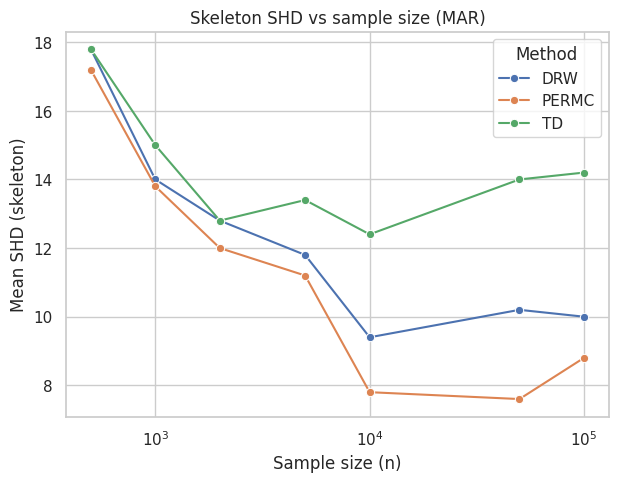

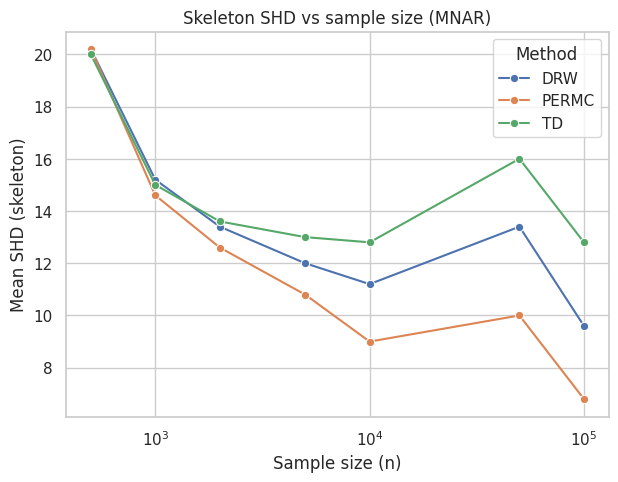

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

for mode in ["MAR", "MNAR"]:
    plt.figure(figsize=(7, 5))
    sub = summary[summary["mode"] == mode]

    sns.lineplot(
        data=sub,
        x="n",
        y="mean_shd",
        hue="method",
        marker="o"
    )

    plt.title(f"Skeleton SHD vs sample size ({mode})")
    plt.xlabel("Sample size (n)")
    plt.ylabel("Mean SHD (skeleton)")
    plt.legend(title="Method")
    plt.xscale("log")  # optional, if you like log-scale on n
    plt.show()


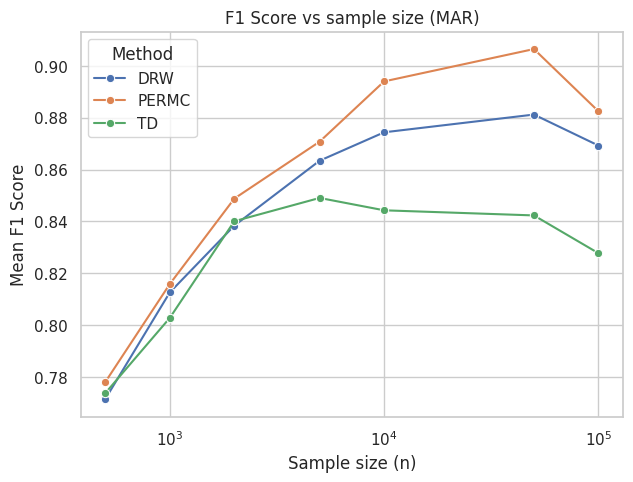

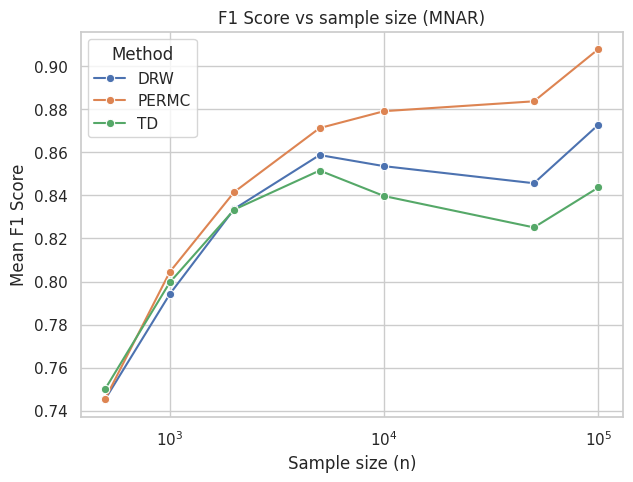

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

for mode in ["MAR", "MNAR"]:
    plt.figure(figsize=(7, 5))
    sub = summary_f1[summary_f1["mode"] == mode]

    sns.lineplot(
        data=sub,
        x="n",
        y="mean_f1",
        hue="method",
        marker="o"
    )

    plt.title(f"F1 Score vs sample size ({mode})")
    plt.xlabel("Sample size (n)")
    plt.ylabel("Mean F1 Score")
    plt.legend(title="Method")
    plt.xscale("log")   # optional, matches your SHD plot
    plt.show()


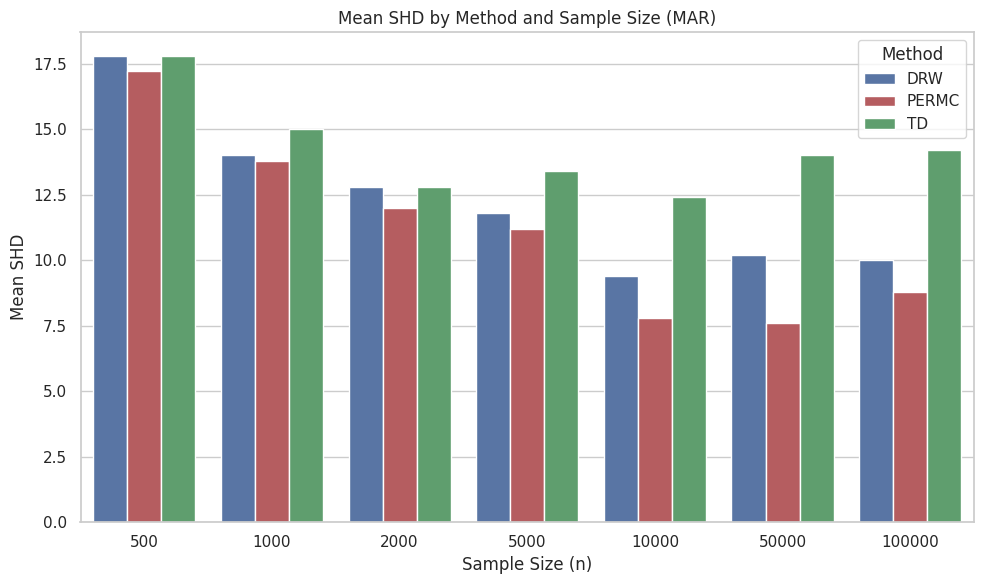

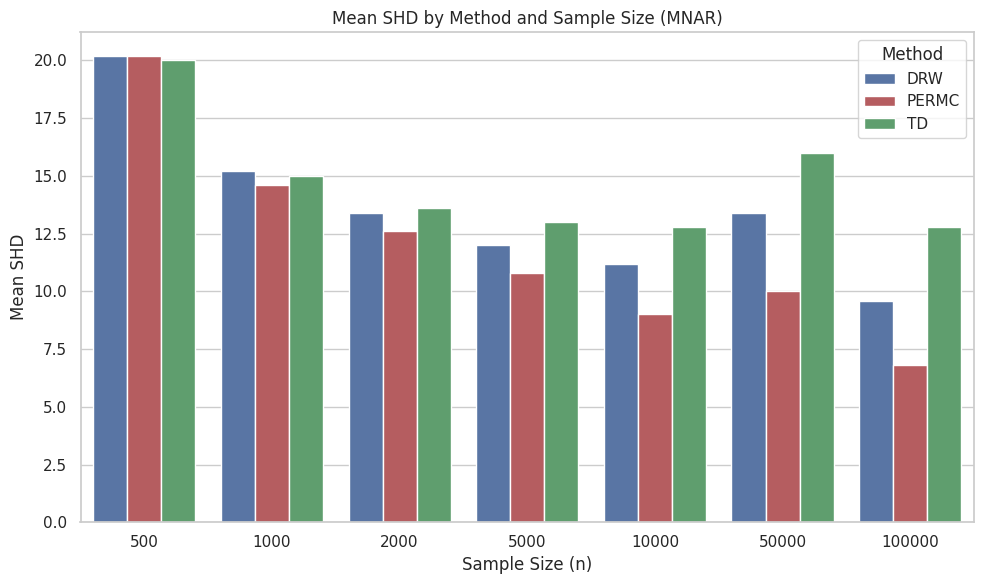

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

def plot_grouped_histogram(df, mode):
    df_mode = df[df["mode"] == mode]

    plt.figure(figsize=(10, 6))

    # Create grouped bar chart
    sns.barplot(
        data=df_mode,
        x="n",
        y="mean_shd",
        hue="method",
        palette=["#4C72B0", "#C44E52", "#55A868"],  # blue, green, red
        errorbar="sd"
    )

    plt.title(f"Mean SHD by Method and Sample Size ({mode})")
    plt.xlabel("Sample Size (n)")
    plt.ylabel("Mean SHD")
    plt.legend(title="Method")
    plt.tight_layout()
    plt.show()

# Plot for MAR
plot_grouped_histogram(summary, "MAR")

# Plot for MNAR
plot_grouped_histogram(summary, "MNAR")


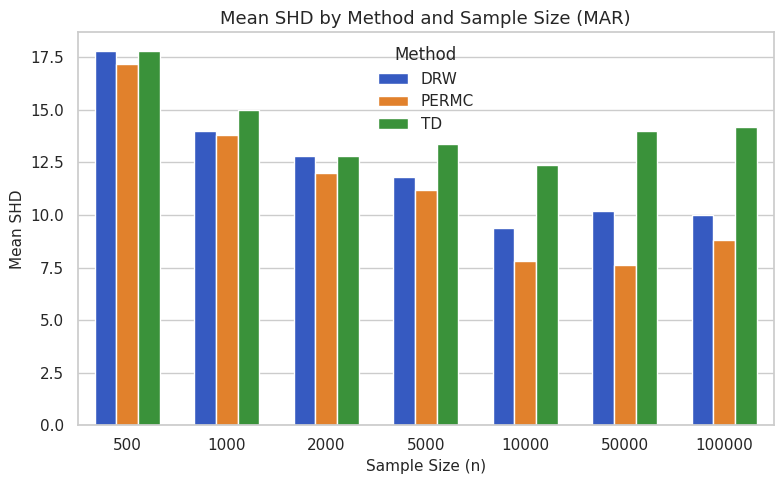

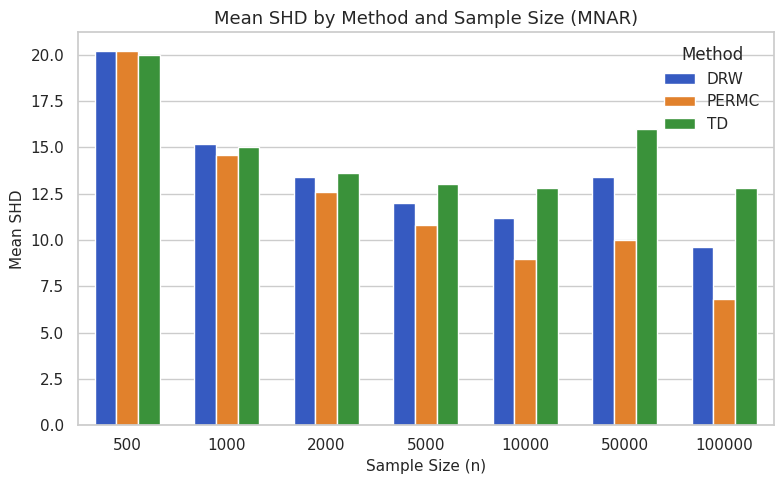

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

def plot_grouped_histogram(df, mode):
    df_mode = df[df["mode"] == mode]

    # Smaller figure
    plt.figure(figsize=(8, 5))

    sns.barplot(
        data=df_mode,
        x="n",
        y="mean_shd",
        hue="method",
        palette=[
            "#1f4fd8",  # saturated blue
            "#ff7f0e",  # red-orange
            "#2ca02c"   # saturated green
        ],
        errorbar="sd",
        width=0.65   # slightly thinner bars
    )

    plt.title(f"Mean SHD by Method and Sample Size ({mode})", fontsize=13)
    plt.xlabel("Sample Size (n)", fontsize=11)
    plt.ylabel("Mean SHD", fontsize=11)

    plt.legend(title="Method", frameon=False)
    plt.tight_layout()
    plt.show()

# Plot for MAR
plot_grouped_histogram(summary, "MAR")

# Plot for MNAR
plot_grouped_histogram(summary, "MNAR")


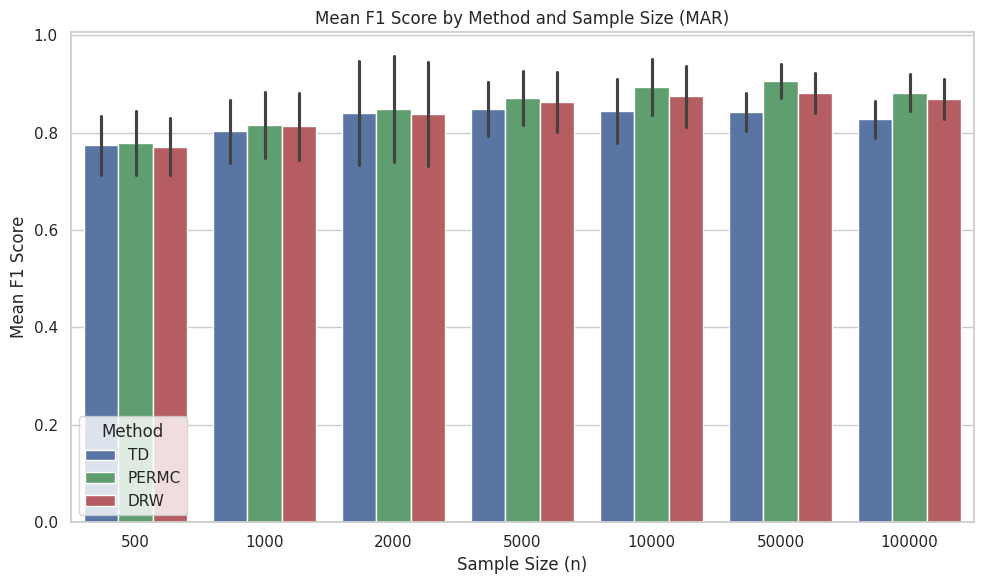

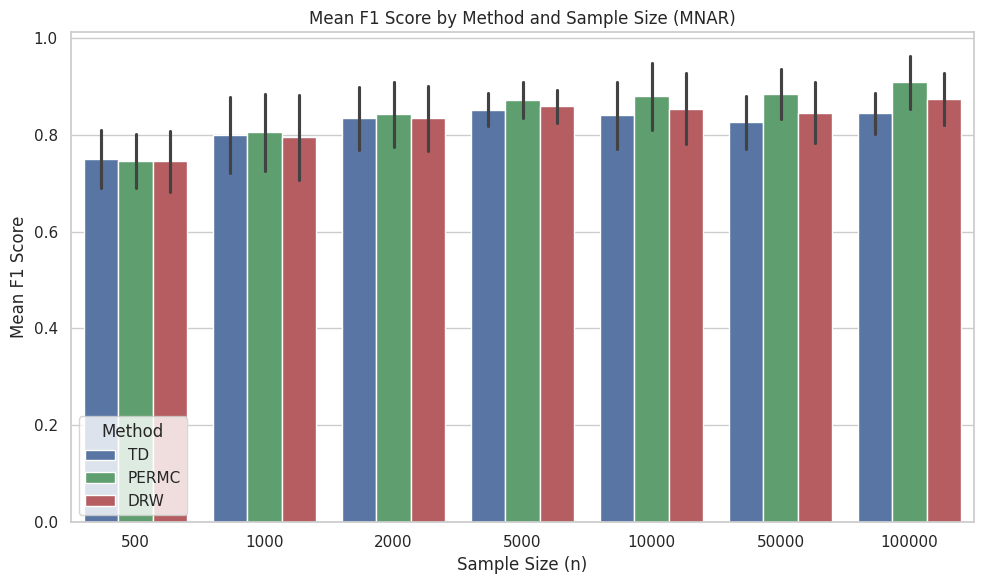

In [ ]:
def plot_grouped_histogram_f1(df, mode):
    df_mode = df[df["mode"] == mode]

    plt.figure(figsize=(10, 6))

    sns.barplot(
        data=df_mode,
        x="n",
        y="f1",
        hue="method",
        palette=["#4C72B0", "#55A868", "#C44E52"],
        errorbar="sd"
    )

    plt.title(f"Mean F1 Score by Method and Sample Size ({mode})")
    plt.xlabel("Sample Size (n)")
    plt.ylabel("Mean F1 Score")
    plt.legend(title="Method")
    plt.tight_layout()
    plt.show()

plot_grouped_histogram_f1(df_results, "MAR")
plot_grouped_histogram_f1(df_results, "MNAR")
